In [1]:
import numpy as np
import pandas as pd

import pymoo.gradient.toolbox as anp

from pymoo.core.problem import Problem
from pymoo.util.normalization import normalize
from pymoo.util.reference_direction import UniformReferenceDirectionFactory
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.util.remote import Remote

from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.selection.tournament import TournamentSelection

from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.nsga2 import NSGA2

from pymoo.algorithms.moo.nsga2 import binary_tournament
from pymoo.algorithms.moo.nsga3 import comp_by_cv_then_random

from pymoo.util.display.column import Column
from pymoo.util.display.output import Output
from pymoo.util.display.display import Display

from pymoo.problems import get_problem

from pymoo.visualization.scatter import Scatter

from pymoo.optimize import minimize

from scipy.spatial import distance

import csv
import time

In [2]:
class measure_time(Output):

    def __init__(self):
        super().__init__()
        self.x_time = Column("x_time", width=13)
        self.columns += [self.x_time]

    def update(self, algorithm):
        super().update(algorithm)
        writer.writerow([time.time() - start_time])
        self.x_time.set(time.time() - start_time)


In [3]:
class ZDT(Problem):

    def __init__(self, n_var=30, **kwargs):
        super().__init__(n_var=n_var, n_obj=2, xl=0, xu=1, vtype=float, **kwargs)

In [4]:
class ZDT1(ZDT):

    def _calc_pareto_front(self, n_pareto_points=100):
        x = np.linspace(0, 1, n_pareto_points)
        return np.array([x, 1 - np.sqrt(x)]).T

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:, 0]
        g = 1 + 9.0 / (self.n_var - 1) * anp.sum(x[:, 1:], axis=1)
        f2 = g * (1 - anp.power((f1 / g), 0.5))

        out["F"] = anp.column_stack([f1, f2])

In [5]:
class ZDT2(ZDT):

    def _calc_pareto_front(self, n_pareto_points=100):
        x = np.linspace(0, 1, n_pareto_points)
        return np.array([x, 1 - np.power(x, 2)]).T

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:, 0]
        c = anp.sum(x[:, 1:], axis=1)
        g = 1.0 + 9.0 * c / (self.n_var - 1)
        f2 = g * (1 - anp.power((f1 * 1.0 / g), 2))

        out["F"] = anp.column_stack([f1, f2])

In [6]:
class ZDT3(ZDT):

    def _calc_pareto_front(self, n_points=100, flatten=True):
        regions = [[0, 0.0830015349],
                   [0.182228780, 0.2577623634],
                   [0.4093136748, 0.4538821041],
                   [0.6183967944, 0.6525117038],
                   [0.8233317983, 0.8518328654]]

        pf = []

        for r in regions:
            x1 = np.linspace(r[0], r[1], int(n_points / len(regions)))
            x2 = 1 - np.sqrt(x1) - x1 * np.sin(10 * np.pi * x1)
            pf.append(np.array([x1, x2]).T)

        if not flatten:
            pf = np.concatenate([pf[None,...] for pf in pf])
        else:
            pf = np.row_stack(pf)

        return pf

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:, 0]
        c = anp.sum(x[:, 1:], axis=1)
        g = 1.0 + 9.0 * c / (self.n_var - 1)
        f2 = g * (1 - anp.power(f1 * 1.0 / g, 0.5) - (f1 * 1.0 / g) * anp.sin(10 * anp.pi * f1))

        out["F"] = anp.column_stack([f1, f2])

In [7]:
class ZDT4(ZDT):
    def __init__(self, n_var=10):
        super().__init__(n_var)
        self.xl = -5 * np.ones(self.n_var)
        self.xl[0] = 0.0
        self.xu = 5 * np.ones(self.n_var)
        self.xu[0] = 1.0
        self.func = self._evaluate

    def _calc_pareto_front(self, n_pareto_points=100):
        x = np.linspace(0, 1, n_pareto_points)
        return np.array([x, 1 - np.sqrt(x)]).T

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:, 0]
        g = 1.0
        g += 10 * (self.n_var - 1)
        for i in range(1, self.n_var):
            g += x[:, i] * x[:, i] - 10.0 * anp.cos(4.0 * anp.pi * x[:, i])
        h = 1.0 - anp.sqrt(f1 / g)
        f2 = g * h

        out["F"] = anp.column_stack([f1, f2])

In [8]:
class ZDT5(ZDT):

    def __init__(self, m=11, n=5, normalize=True, **kwargs):
        self.m = m
        self.n = n
        self.normalize = normalize
        super().__init__(n_var=(30 + n * (m - 1)), **kwargs)

    def _calc_pareto_front(self, n_pareto_points=100):
        x = 1 + np.linspace(0, 1, n_pareto_points) * 30
        pf = np.column_stack([x, (self.m-1) / x])
        if self.normalize:
            pf = normalize(pf)
        return pf

    def _evaluate(self, x, out, *args, **kwargs):
        x = x.astype(float)

        _x = [x[:, :30]]
        for i in range(self.m - 1):
            _x.append(x[:, 30 + i * self.n: 30 + (i + 1) * self.n])

        u = anp.column_stack([x_i.sum(axis=1) for x_i in _x])
        v = (2 + u) * (u < self.n) + 1 * (u == self.n)
        g = v[:, 1:].sum(axis=1)

        f1 = 1 + u[:, 0]
        f2 = g * (1 / f1)

        if self.normalize:
            f1 = normalize(f1, 1, 31)
            f2 = normalize(f2, (self.m-1) * 1/31, (self.m-1))

        out["F"] = anp.column_stack([f1, f2])

In [10]:
class ZDT6(ZDT):

    def __init__(self, n_var=10, **kwargs):
        super().__init__(n_var=n_var, **kwargs)

    def _calc_pareto_front(self, n_pareto_points=100):
        x = np.linspace(0.2807753191, 1, n_pareto_points)
        return np.array([x, 1 - np.power(x, 2)]).T

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = 1 - anp.exp(-4 * x[:, 0]) * anp.power(anp.sin(6 * anp.pi * x[:, 0]), 6)
        g = 1 + 9.0 * anp.power(anp.sum(x[:, 1:], axis=1) / (self.n_var - 1.0), 0.25)
        f2 = g * (1 - anp.power(f1 / g, 2))

        out["F"] = anp.column_stack([f1, f2])

In [14]:
NOBJ = 2
MU = 100
BOUND_LOW, BOUND_UP = 0.0, 1.0
NGEN = 500
CXPB = 0.8
MUTPB = 0.2

ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=99)


algorithm_nsga2 = NSGA2(pop_size=MU, 
                  sampling=FloatRandomSampling(), 
                  selection = TournamentSelection(func_comp=binary_tournament), 
                  crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                  mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                  eliminate_duplicates=False)

algorithm_nsga3 = NSGA3(pop_size=MU, 
                  sampling=FloatRandomSampling(), 
                  selection=TournamentSelection(func_comp=comp_by_cv_then_random),
                  crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                  mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                  ref_dirs=ref_dirs,
                  eliminate_duplicates=False)

## ZDT 1

In [11]:
NDIM = 3
problem = ZDT1(n_var=NDIM)

In [12]:
with open('pymoo_time_nsga2_zdt1_100_500_2_3.csv', 'w', newline='') as f, open('pymoo_fitness_nsga2_zdt1_100_500_2_3.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga2, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
        writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0259671211
     2 |      200 |  0.0344498158
     3 |      300 |  0.0434641838
     4 |      400 |  0.0524017811
     5 |      500 |  0.0614156723
     6 |      600 |  0.0683987141
     7 |      700 |  0.0753784180
     8 |      800 |  0.0813620090
     9 |      900 |  0.0883495808
    10 |     1000 |  0.0943300724
    11 |     1100 |  0.1013150215
    12 |     1200 |  0.1072945595
    13 |     1300 |  0.1142752171
    14 |     1400 |  0.1202642918
    15 |     1500 |  0.1272394657
    16 |     1600 |  0.1332237720
    17 |     1700 |  0.1392145157
    18 |     1800 |  0.1451909542
    19 |     1900 |  0.1511824131
    20 |     2000 |  0.1581189632
    21 |     2100 |  0.1641027927
    22 |     2200 |  0.1710860729
    23 |     2300 |  0.1780672073
    24 |     2400 |  0.1850485802
    25 |     2500 |  0.1910331249
    26 |     2600 |  0.1990113258
    27 |     2700 |  0.2049956322
    28 |     2800 |  0.2119767666
    29 |     2

   248 |    24800 |  1.7528522015
   249 |    24900 |  1.7618672848
   250 |    25000 |  1.7727982998
   251 |    25100 |  1.7788214684
   252 |    25200 |  1.7848110199
   253 |    25300 |  1.7917892933
   254 |    25400 |  1.7977695465
   255 |    25500 |  1.8037557602
   256 |    25600 |  1.8137295246
   257 |    25700 |  1.8197128773
   258 |    25800 |  1.8256964684
   259 |    25900 |  1.8316824436
   260 |    26000 |  1.8376667500
   261 |    26100 |  1.8446452618
   262 |    26200 |  1.8506307602
   263 |    26300 |  1.8566186428
   264 |    26400 |  1.8626003265
   265 |    26500 |  1.8685886860
   266 |    26600 |  1.8745932579
   267 |    26700 |  1.8805494308
   268 |    26800 |  1.8865365982
   269 |    26900 |  1.8935186863
   270 |    27000 |  1.8995325565
   271 |    27100 |  1.9054450989
   272 |    27200 |  1.9154186249
   273 |    27300 |  1.9233949184
   274 |    27400 |  1.9293785095
   275 |    27500 |  1.9354000092
   276 |    27600 |  1.9423866272
   277 |    27

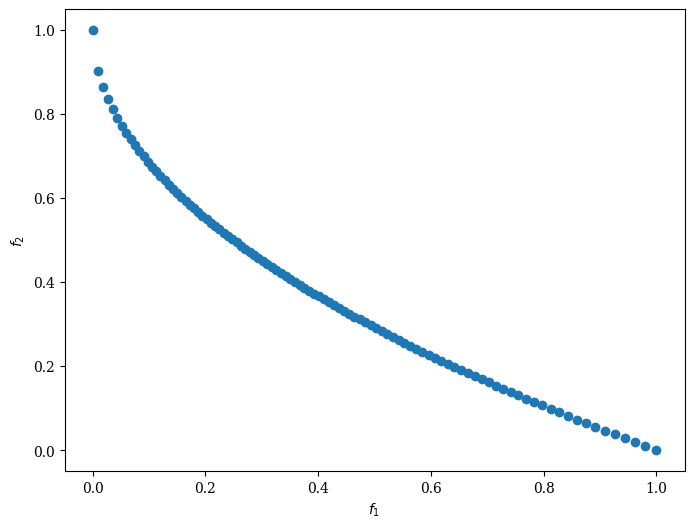

In [17]:
Scatter().add(res.F).show()

In [13]:
with open('pymoo_time_nsga3_zdt1_100_500_2_3.csv', 'w', newline='') as f, open('pymoo_fitness_nsga3_zdt1_100_500_2_3.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga3, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0149595737
     2 |      200 |  0.0259289742
     3 |      300 |  0.0368995667
     4 |      400 |  0.0458781719
     5 |      500 |  0.0548894405
     6 |      600 |  0.0648276806
     7 |      700 |  0.0738031864
     8 |      800 |  0.0837764740
     9 |      900 |  0.0937497616
    10 |     1000 |  0.1037225723
    11 |     1100 |  0.1136963367
    12 |     1200 |  0.1236696243
    13 |     1300 |  0.1336410046
    14 |     1400 |  0.1436138153
    15 |     1500 |  0.1525900364
    16 |     1600 |  0.1615657806
    17 |     1700 |  0.1715390682
    18 |     1800 |  0.1805171967
    19 |     1900 |  0.1914880276
    20 |     2000 |  0.2024588585
    21 |     2100 |  0.2134296894
    22 |     2200 |  0.2243998051
    23 |     2300 |  0.2363665104
    24 |     2400 |  0.2523653507
    25 |     2500 |  0.2652881145
    26 |     2600 |  0.2753126621
    27 |     2700 |  0.2862696648
    28 |     2800 |  0.2966883183
    29 |     2

   242 |    24200 |  2.6379792690
   243 |    24300 |  2.6509430408
   244 |    24400 |  2.6628746986
   245 |    24500 |  2.6738438606
   246 |    24600 |  2.6858119965
   247 |    24700 |  2.6967828274
   248 |    24800 |  2.7087504864
   249 |    24900 |  2.7207190990
   250 |    25000 |  2.7316892147
   251 |    25100 |  2.7436573505
   252 |    25200 |  2.7546281815
   253 |    25300 |  2.7665958405
   254 |    25400 |  2.7785637379
   255 |    25500 |  2.7895343304
   256 |    25600 |  2.8025007248
   257 |    25700 |  2.8135092258
   258 |    25800 |  2.8294725418
   259 |    25900 |  2.8403992653
   260 |    26000 |  2.8563554287
   261 |    26100 |  2.8713159561
   262 |    26200 |  2.8813259602
   263 |    26300 |  2.8923013210
   264 |    26400 |  2.9072175026
   265 |    26500 |  2.9222168922
   266 |    26600 |  2.9381361008
   267 |    26700 |  2.9520974159
   268 |    26800 |  2.9630680084
   269 |    26900 |  2.9730412960
   270 |    27000 |  2.9850096703
   271 |    27

   492 |    49200 |  5.4816527367
   493 |    49300 |  5.4966139793
   494 |    49400 |  5.5065863132
   495 |    49500 |  5.5175573826
   496 |    49600 |  5.5275719166
   497 |    49700 |  5.5385420322
   498 |    49800 |  5.5494730473
   499 |    49900 |  5.5614411831
   500 |    50000 |  5.5724451542


## ZDT 2

In [ ]:
NDIM = 4
problem = ZDT2(n_var=NDIM)

In [16]:
with open('pymoo_time_nsga2_zdt2_100_500_2_4.csv', 'w', newline='') as f, open('pymoo_fitness_nsga2_zdt2_100_500_2_4.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga2, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0127997398
     2 |      200 |  0.0189175606
     3 |      300 |  0.0341627598
     4 |      400 |  0.0421190262
     5 |      500 |  0.0515344143
     6 |      600 |  0.0585150719
     7 |      700 |  0.0665736198
     8 |      800 |  0.0665736198
     9 |      900 |  0.0821955204
    10 |     1000 |  0.0821955204
    11 |     1100 |  0.0957500935
    12 |     1200 |  0.0957500935
    13 |     1300 |  0.1113774776
    14 |     1400 |  0.1113774776
    15 |     1500 |  0.1113774776
    16 |     1600 |  0.1270425320
    17 |     1700 |  0.1270425320
    18 |     1800 |  0.1426734924
    19 |     1900 |  0.1426734924
    20 |     2000 |  0.1582801342
    21 |     2100 |  0.1582801342
    22 |     2200 |  0.1582801342
    23 |     2300 |  0.1739065647
    24 |     2400 |  0.1739065647
    25 |     2500 |  0.1895239353
    26 |     2600 |  0.1960773468
    27 |     2700 |  0.1960773468
    28 |     2800 |  0.2117538452
    29 |     2

   259 |    25900 |  1.7516489029
   260 |    26000 |  1.7631375790
   261 |    26100 |  1.7706956863
   262 |    26200 |  1.7766773701
   263 |    26300 |  1.7842278481
   264 |    26400 |  1.7901821136
   265 |    26500 |  1.7961976528
   266 |    26600 |  1.8028652668
   267 |    26700 |  1.8088500500
   268 |    26800 |  1.8158302307
   269 |    26900 |  1.8168642521
   270 |    27000 |  1.8168642521
   271 |    27100 |  1.8325266838
   272 |    27200 |  1.8325266838
   273 |    27300 |  1.8325266838
   274 |    27400 |  1.8481581211
   275 |    27500 |  1.8481581211
   276 |    27600 |  1.8637766838
   277 |    27700 |  1.8637766838
   278 |    27800 |  1.8708546162
   279 |    27900 |  1.8708546162
   280 |    28000 |  1.8865239620
   281 |    28100 |  1.8865239620
   282 |    28200 |  1.8865239620
   283 |    28300 |  1.9021432400
   284 |    28400 |  1.9177589417
   285 |    28500 |  1.9177589417
   286 |    28600 |  1.9333446026
   287 |    28700 |  1.9333446026
   288 |    28

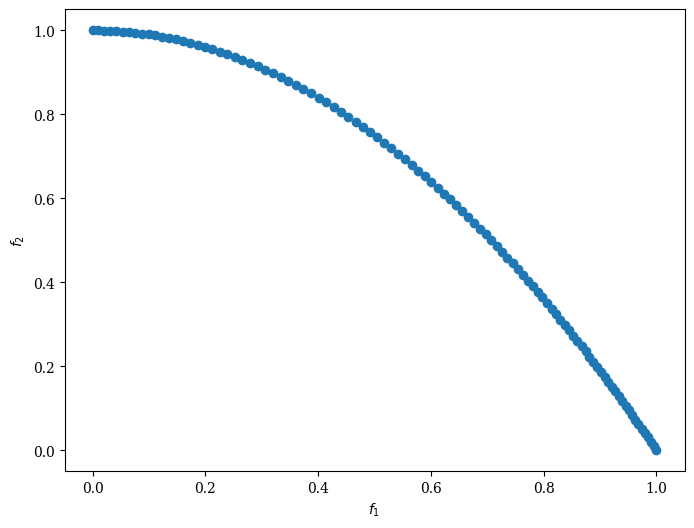

In [23]:
Scatter().add(res.F).show()

In [17]:
with open('pymoo_time_nsga3_zdt2_100_500_2_4.csv', 'w', newline='') as f, open('pymoo_fitness_nsga3_zdt2_100_500_2_4.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])

    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga3, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)

    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0084128380
     2 |      200 |  0.0102736950
     3 |      300 |  0.0252618790
     4 |      400 |  0.0252618790
     5 |      500 |  0.0497035980
     6 |      600 |  0.0596764088
     7 |      700 |  0.0686521530
     8 |      800 |  0.0766596794
     9 |      900 |  0.0766596794
    10 |     1000 |  0.0923252106
    11 |     1100 |  0.0923252106
    12 |     1200 |  0.1079499722
    13 |     1300 |  0.1079499722
    14 |     1400 |  0.1235680580
    15 |     1500 |  0.1392199993
    16 |     1600 |  0.1457755566
    17 |     1700 |  0.1457755566
    18 |     1800 |  0.1614427567
    19 |     1900 |  0.1614427567
    20 |     2000 |  0.1770222187
    21 |     2100 |  0.1926460266
    22 |     2200 |  0.1926460266
    23 |     2300 |  0.2082693577
    24 |     2400 |  0.2082693577
    25 |     2500 |  0.2354249954
    26 |     2600 |  0.2460119724
    27 |     2700 |  0.2603480816
    28 |     2800 |  0.2693176270
    29 |     2

   246 |    24600 |  2.6199271679
   247 |    24700 |  2.6382522583
   248 |    24800 |  2.6503732204
   249 |    24900 |  2.6604764462
   250 |    25000 |  2.6704559326
   251 |    25100 |  2.6810667515
   252 |    25200 |  2.6920380592
   253 |    25300 |  2.6931178570
   254 |    25400 |  2.7087411880
   255 |    25500 |  2.7087411880
   256 |    25600 |  2.7243654728
   257 |    25700 |  2.7399864197
   258 |    25800 |  2.7399864197
   259 |    25900 |  2.7606482506
   260 |    26000 |  2.7606482506
   261 |    26100 |  2.7763144970
   262 |    26200 |  2.7918961048
   263 |    26300 |  2.7918961048
   264 |    26400 |  2.8075635433
   265 |    26500 |  2.8231863976
   266 |    26600 |  2.8424994946
   267 |    26700 |  2.8525116444
   268 |    26800 |  2.8624901772
   269 |    26900 |  2.8724668026
   270 |    27000 |  2.8764810562
   271 |    27100 |  2.8921501637
   272 |    27200 |  2.8921501637
   273 |    27300 |  2.9077718258
   274 |    27400 |  2.9233922958
   275 |    27

   499 |    49900 |  5.3918399811
   500 |    50000 |  5.4106695652


## ZDT 3

In [18]:
NDIM = 5
problem = ZDT3(n_var=NDIM)

In [19]:
with open('pymoo_time_nsga2_zdt3_100_500_2_5.csv', 'w', newline='') as f, open('pymoo_fitness_nsga2_zdt3_100_500_2_5.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga2, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0112507343
     2 |      200 |  0.0137588978
     3 |      300 |  0.0261995792
     4 |      400 |  0.0261995792
     5 |      500 |  0.0501546860
     6 |      600 |  0.0571358204
     7 |      700 |  0.0651946068
     8 |      800 |  0.0711841583
     9 |      900 |  0.0771925449
    10 |     1000 |  0.0771925449
    11 |     1100 |  0.0771925449
    12 |     1200 |  0.0928528309
    13 |     1300 |  0.0928528309
    14 |     1400 |  0.1084830761
    15 |     1500 |  0.1084830761
    16 |     1600 |  0.1241042614
    17 |     1700 |  0.1241042614
    18 |     1800 |  0.1241042614
    19 |     1900 |  0.1397261620
    20 |     2000 |  0.1397261620
    21 |     2100 |  0.1553452015
    22 |     2200 |  0.1553452015
    23 |     2300 |  0.1553452015
    24 |     2400 |  0.1703591347
    25 |     2500 |  0.1703591347
    26 |     2600 |  0.1860289574
    27 |     2700 |  0.1860289574
    28 |     2800 |  0.2016477585
    29 |     2

   258 |    25800 |  1.7257816792
   259 |    25900 |  1.7367520332
   260 |    26000 |  1.7427954674
   261 |    26100 |  1.7427954674
   262 |    26200 |  1.7427954674
   263 |    26300 |  1.7645332813
   264 |    26400 |  1.7715144157
   265 |    26500 |  1.7786693573
   266 |    26600 |  1.7856509686
   267 |    26700 |  1.7926325798
   268 |    26800 |  1.7937064171
   269 |    26900 |  1.7937064171
   270 |    27000 |  1.8093307018
   271 |    27100 |  1.8093307018
   272 |    27200 |  1.8093307018
   273 |    27300 |  1.8249552250
   274 |    27400 |  1.8249552250
   275 |    27500 |  1.8405771255
   276 |    27600 |  1.8405771255
   277 |    27700 |  1.8405771255
   278 |    27800 |  1.8561980724
   279 |    27900 |  1.8561980724
   280 |    28000 |  1.8718194962
   281 |    28100 |  1.8738288879
   282 |    28200 |  1.8738288879
   283 |    28300 |  1.8894603252
   284 |    28400 |  1.8894603252
   285 |    28500 |  1.8894603252
   286 |    28600 |  1.9050817490
   287 |    28

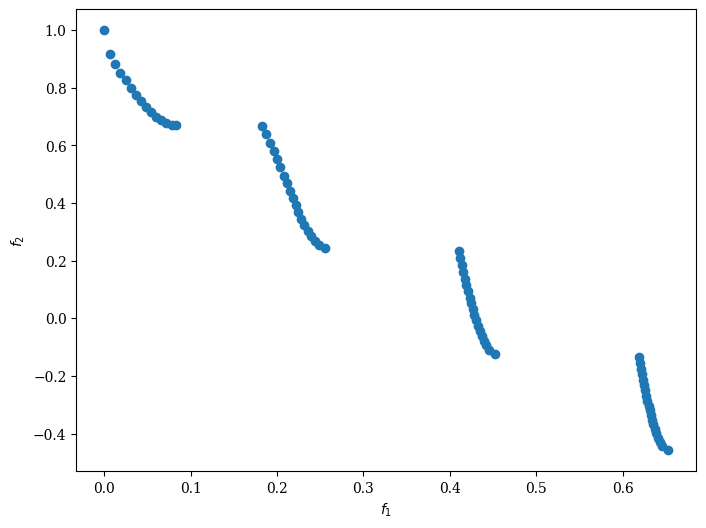

In [30]:
Scatter().add(res.F).show()

In [20]:
with open('pymoo_time_nsga3_zdt3_100_500_2_5.csv', 'w', newline='') as f, open('pymoo_fitness_nsga3_zdt3_100_500_2_5.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])

    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga3, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)

    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0081174374
     2 |      200 |  0.0215470791
     3 |      300 |  0.0219249725
     4 |      400 |  0.0401964188
     5 |      500 |  0.0491666794
     6 |      600 |  0.0591318607
     7 |      700 |  0.0680644512
     8 |      800 |  0.0731327534
     9 |      900 |  0.0841836929
    10 |     1000 |  0.0841836929
    11 |     1100 |  0.0998544693
    12 |     1200 |  0.0998544693
    13 |     1300 |  0.1154797077
    14 |     1400 |  0.1310944557
    15 |     1500 |  0.1310944557
    16 |     1600 |  0.1467154026
    17 |     1700 |  0.1467154026
    18 |     1800 |  0.1623394489
    19 |     1900 |  0.1779606342
    20 |     2000 |  0.1845138073
    21 |     2100 |  0.1845138073
    22 |     2200 |  0.2002182007
    23 |     2300 |  0.2002182007
    24 |     2400 |  0.2285819054
    25 |     2500 |  0.2422695160
    26 |     2600 |  0.2512454987
    27 |     2700 |  0.2652311325
    28 |     2800 |  0.2714266777
    29 |     2

   248 |    24800 |  2.5909385681
   249 |    24900 |  2.6120376587
   250 |    25000 |  2.6223628521
   251 |    25100 |  2.6333777905
   252 |    25200 |  2.6433475018
   253 |    25300 |  2.6553161144
   254 |    25400 |  2.6563911438
   255 |    25500 |  2.6720154285
   256 |    25600 |  2.6720154285
   257 |    25700 |  2.6876373291
   258 |    25800 |  2.7032604218
   259 |    25900 |  2.7032604218
   260 |    26000 |  2.7188806534
   261 |    26100 |  2.7303938866
   262 |    26200 |  2.7460229397
   263 |    26300 |  2.7460229397
   264 |    26400 |  2.7616453171
   265 |    26500 |  2.7772669792
   266 |    26600 |  2.7772669792
   267 |    26700 |  2.7928876877
   268 |    26800 |  2.8115065098
   269 |    26900 |  2.8214800358
   270 |    27000 |  2.8305532932
   271 |    27100 |  2.8440907001
   272 |    27200 |  2.8550305367
   273 |    27300 |  2.8660027981
   274 |    27400 |  2.8730697632
   275 |    27500 |  2.8730697632
   276 |    27600 |  2.8886935711
   277 |    27

   491 |    49100 |  5.1810121536
   492 |    49200 |  5.1939744949
   493 |    49300 |  5.2049462795
   494 |    49400 |  5.2229013443
   495 |    49500 |  5.2368600368
   496 |    49600 |  5.2498261929
   497 |    49700 |  5.2617936134
   498 |    49800 |  5.2757582664
   499 |    49900 |  5.2857306004
   500 |    50000 |  5.2997334003


## ZDT 4

In [21]:
NDIM = 7
problem = ZDT4(n_var=NDIM)

In [22]:
with open('pymoo_time_nsga2_zdt4_100_500_2_7.csv', 'w', newline='') as f, open('pymoo_fitness_nsga2_zdt4_100_500_2_7.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga2, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0098598003
     2 |      200 |  0.0281214714
     3 |      300 |  0.0284695625
     4 |      400 |  0.0463175774
     5 |      500 |  0.0532979965
     6 |      600 |  0.0616881847
     7 |      700 |  0.0696668625
     8 |      800 |  0.0786442757
     9 |      900 |  0.0797238350
    10 |     1000 |  0.0953841209
    11 |     1100 |  0.0953841209
    12 |     1200 |  0.1109712124
    13 |     1300 |  0.1109712124
    14 |     1400 |  0.1265923977
    15 |     1500 |  0.1265923977
    16 |     1600 |  0.1422133446
    17 |     1700 |  0.1452236176
    18 |     1800 |  0.1452236176
    19 |     1900 |  0.1608545780
    20 |     2000 |  0.1608545780
    21 |     2100 |  0.1764767170
    22 |     2200 |  0.1764767170
    23 |     2300 |  0.1920983791
    24 |     2400 |  0.1920983791
    25 |     2500 |  0.2077195644
    26 |     2600 |  0.2077195644
    27 |     2700 |  0.2233407497
    28 |     2800 |  0.2385694981
    29 |     2

   250 |    25000 |  1.7494914532
   251 |    25100 |  1.7628951073
   252 |    25200 |  1.7628951073
   253 |    25300 |  1.7628951073
   254 |    25400 |  1.7830617428
   255 |    25500 |  1.7890458107
   256 |    25600 |  1.7960197926
   257 |    25700 |  1.8039972782
   258 |    25800 |  1.8099820614
   259 |    25900 |  1.8130488396
   260 |    26000 |  1.8130488396
   261 |    26100 |  1.8286728859
   262 |    26200 |  1.8286728859
   263 |    26300 |  1.8286728859
   264 |    26400 |  1.8442971706
   265 |    26500 |  1.8442971706
   266 |    26600 |  1.8599135876
   267 |    26700 |  1.8599135876
   268 |    26800 |  1.8599135876
   269 |    26900 |  1.8755350113
   270 |    27000 |  1.8755350113
   271 |    27100 |  1.8911561966
   272 |    27200 |  1.8981647491
   273 |    27300 |  1.8981647491
   274 |    27400 |  1.9137907028
   275 |    27500 |  1.9137907028
   276 |    27600 |  1.9137907028
   277 |    27700 |  1.9294116497
   278 |    27800 |  1.9294116497
   279 |    27

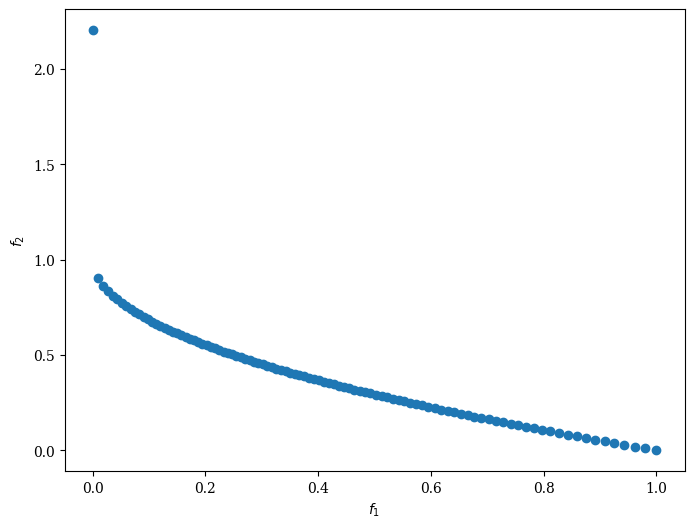

In [35]:
Scatter().add(res.F).show()

In [23]:
with open('pymoo_time_nsga3_zdt4_100_500_2_7.csv', 'w', newline='') as f, open('pymoo_fitness_nsga3_zdt4_100_500_2_7.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writer.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga3, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0033504963
     2 |      200 |  0.0147168636
     3 |      300 |  0.0147168636
     4 |      400 |  0.0390968323
     5 |      500 |  0.0491025448
     6 |      600 |  0.0580763817
     7 |      700 |  0.0660991669
     8 |      800 |  0.0660991669
     9 |      900 |  0.0817859173
    10 |     1000 |  0.0817859173
    11 |     1100 |  0.0973911285
    12 |     1200 |  0.0973911285
    13 |     1300 |  0.1129641533
    14 |     1400 |  0.1286323071
    15 |     1500 |  0.1286323071
    16 |     1600 |  0.1462948322
    17 |     1700 |  0.1462948322
    18 |     1800 |  0.1619679928
    19 |     1900 |  0.1775887012
    20 |     2000 |  0.1874368191
    21 |     2100 |  0.1978275776
    22 |     2200 |  0.2067635059
    23 |     2300 |  0.2204120159
    24 |     2400 |  0.2311828136
    25 |     2500 |  0.2399682999
    26 |     2600 |  0.2547578812
    27 |     2700 |  0.2646920681
    28 |     2800 |  0.2737071514
    29 |     2

   242 |    24200 |  2.5969195366
   243 |    24300 |  2.6171584129
   244 |    24400 |  2.6174762249
   245 |    24500 |  2.6399261951
   246 |    24600 |  2.6503093243
   247 |    24700 |  2.6503093243
   248 |    24800 |  2.6743221283
   249 |    24900 |  2.6852154732
   250 |    25000 |  2.6961860657
   251 |    25100 |  2.6992621422
   252 |    25200 |  2.7148859501
   253 |    25300 |  2.7148859501
   254 |    25400 |  2.7305090427
   255 |    25500 |  2.7461314201
   256 |    25600 |  2.7501394749
   257 |    25700 |  2.7657659054
   258 |    25800 |  2.7657659054
   259 |    25900 |  2.7813880444
   260 |    26000 |  2.7970552444
   261 |    26100 |  2.8142971992
   262 |    26200 |  2.8243095875
   263 |    26300 |  2.8353025913
   264 |    26400 |  2.8452758789
   265 |    26500 |  2.8512637615
   266 |    26600 |  2.8672780991
   267 |    26700 |  2.8679950237
   268 |    26800 |  2.8900666237
   269 |    26900 |  2.8977267742
   270 |    27000 |  2.8977267742
   271 |    27

   495 |    49500 |  5.3945190907
   496 |    49600 |  5.4158792496
   497 |    49700 |  5.4177711010
   498 |    49800 |  5.4388022423
   499 |    49900 |  5.4488356113
   500 |    50000 |  5.4588081837


## ZDT 5

In [25]:
problem = ZDT5()
algorithm_nsga2_bin = NSGA2(pop_size=MU, 
                      sampling=BinaryRandomSampling(),
                      selection=TournamentSelection(func_comp=binary_tournament),
                      crossover=TwoPointCrossover(),
                      mutation=BitflipMutation(),
                      eliminate_duplicates=False)

algorithm_nsga3_bin = NSGA3(pop_size=MU, 
                            sampling=BinaryRandomSampling(), 
                            selection=TournamentSelection(func_comp=comp_by_cv_then_random),
                            crossover=TwoPointCrossover(),
                            mutation=BitflipMutation(),
                            ref_dirs=ref_dirs,
                            eliminate_duplicates=False)

In [26]:
with open('pymoo_time_nsga2_zdt5_100_500_2_80.csv', 'w', newline='') as f, open('pymoo_fitness_nsga2_zdt5_100_500_2_80.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writer.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga2_bin, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0583815575
     2 |      200 |  0.1175594330
     3 |      300 |  0.1175594330
     4 |      400 |  0.1331870556
     5 |      500 |  0.1331870556
     6 |      600 |  0.1498894691
     7 |      700 |  0.1498894691
     8 |      800 |  0.1655204296
     9 |      900 |  0.1655204296
    10 |     1000 |  0.1811416149
    11 |     1100 |  0.1811416149
    12 |     1200 |  0.1967575550
    13 |     1300 |  0.1967575550
    14 |     1400 |  0.1967575550
    15 |     1500 |  0.2123785019
    16 |     1600 |  0.2123785019
    17 |     1700 |  0.2279999256
    18 |     1800 |  0.2279999256
    19 |     1900 |  0.2436263561
    20 |     2000 |  0.2501704693
    21 |     2100 |  0.2501704693
    22 |     2200 |  0.2704141140
    23 |     2300 |  0.2840757370
    24 |     2400 |  0.2941536903
    25 |     2500 |  0.3011391163
    26 |     2600 |  0.3089878559
    27 |     2700 |  0.3170113564
    28 |     2800 |  0.3193807602
    29 |     2

   239 |    23900 |  2.0071551800
   240 |    24000 |  2.0137584209
   241 |    24100 |  2.0252737999
   242 |    24200 |  2.0332572460
   243 |    24300 |  2.0462172031
   244 |    24400 |  2.0542745590
   245 |    24500 |  2.0698971748
   246 |    24600 |  2.0698971748
   247 |    24700 |  2.0855586529
   248 |    24800 |  2.0855586529
   249 |    24900 |  2.1042385101
   250 |    25000 |  2.1042385101
   251 |    25100 |  2.1042385101
   252 |    25200 |  2.1198992729
   253 |    25300 |  2.1198992729
   254 |    25400 |  2.1355309486
   255 |    25500 |  2.1355309486
   256 |    25600 |  2.1511552334
   257 |    25700 |  2.1511552334
   258 |    25800 |  2.1667730808
   259 |    25900 |  2.1667730808
   260 |    26000 |  2.1824076176
   261 |    26100 |  2.1824076176
   262 |    26200 |  2.1980283260
   263 |    26300 |  2.2046039104
   264 |    26400 |  2.2046039104
   265 |    26500 |  2.2209737301
   266 |    26600 |  2.2309508324
   267 |    26700 |  2.2402336597
   268 |    26

   484 |    48400 |  3.9361548424
   485 |    48500 |  3.9409513474
   486 |    48600 |  3.9545831680
   487 |    48700 |  3.9625592232
   488 |    48800 |  3.9704942703
   489 |    48900 |  3.9804675579
   490 |    49000 |  3.9874918461
   491 |    49100 |  3.9874918461
   492 |    49200 |  4.0031633377
   493 |    49300 |  4.0031633377
   494 |    49400 |  4.0187795162
   495 |    49500 |  4.0187795162
   496 |    49600 |  4.0303382874
   497 |    49700 |  4.0303382874
   498 |    49800 |  4.0460073948
   499 |    49900 |  4.0460073948
   500 |    50000 |  4.0616292953


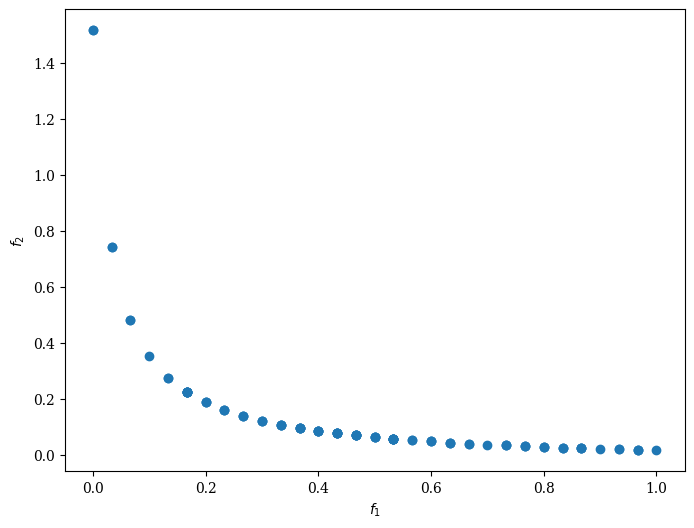

In [29]:
Scatter().add(res.F).show()

In [31]:
with open('pymoo_time_nsga3_zdt5_100_500_2_80.csv', 'w', newline='') as f, open('pymoo_fitness_nsga3_zdt5_100_500_2_80.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga3_bin, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0129644871
     2 |      200 |  0.0279266834
     3 |      300 |  0.0388967991
     4 |      400 |  0.0489056110
     5 |      500 |  0.0588414669
     6 |      600 |  0.0688533783
     7 |      700 |  0.0788259506
     8 |      800 |  0.0887989998
     9 |      900 |  0.0977754593
    10 |     1000 |  0.1067581177
    11 |     1100 |  0.1167242527
    12 |     1200 |  0.1267039776
    13 |     1300 |  0.1356799603
    14 |     1400 |  0.1456470490
    15 |     1500 |  0.1546297073
    16 |     1600 |  0.1636009216
    17 |     1700 |  0.1735799313
    18 |     1800 |  0.1835100651
    19 |     1900 |  0.1944780350
    20 |     2000 |  0.2034542561
    21 |     2100 |  0.2134273052
    22 |     2200 |  0.2234008312
    23 |     2300 |  0.2353696823
    24 |     2400 |  0.2473745346
    25 |     2500 |  0.2583100796
    26 |     2600 |  0.2672834396
    27 |     2700 |  0.2782545090
    28 |     2800 |  0.2882280350
    29 |     2

   256 |    25600 |  2.8532338142
   257 |    25700 |  2.8681552410
   258 |    25800 |  2.8791282177
   259 |    25900 |  2.8910958767
   260 |    26000 |  2.9021108150
   261 |    26100 |  2.9130761623
   262 |    26200 |  2.9230582714
   263 |    26300 |  2.9340198040
   264 |    26400 |  2.9439969063
   265 |    26500 |  2.9549677372
   266 |    26600 |  2.9649412632
   267 |    26700 |  2.9759116173
   268 |    26800 |  2.9858860970
   269 |    26900 |  2.9968557358
   270 |    27000 |  3.0068292618
   271 |    27100 |  3.0177936554
   272 |    27200 |  3.0277662277
   273 |    27300 |  3.0377504826
   274 |    27400 |  3.0487153530
   275 |    27500 |  3.0586919785
   276 |    27600 |  3.0696504116
   277 |    27700 |  3.0846223831
   278 |    27800 |  3.0956940651
   279 |    27900 |  3.1056730747
   280 |    28000 |  3.1165997982
   281 |    28100 |  3.1275703907
   282 |    28200 |  3.1375439167
   283 |    28300 |  3.1475169659
   284 |    28400 |  3.1584875584
   285 |    28

## ZDT 6

In [32]:
NDIM = 10
problem = ZDT6(n_var=NDIM)

In [33]:
with open('pymoo_time_nsga2_zdt6_100_500_2_10.csv', 'w', newline='') as f, open('pymoo_fitness_nsga2_zdt6_100_500_2_10.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga2, ('n_gen', 500), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0125243664
     2 |      200 |  0.0150172710
     3 |      300 |  0.0320770741
     4 |      400 |  0.0400600433
     5 |      500 |  0.0500509739
     6 |      600 |  0.0590269566
     7 |      700 |  0.0631198883
     8 |      800 |  0.0631198883
     9 |      900 |  0.0787439346
    10 |     1000 |  0.0787439346
    11 |     1100 |  0.0943672657
    12 |     1200 |  0.0943672657
    13 |     1300 |  0.1099891663
    14 |     1400 |  0.1099891663
    15 |     1500 |  0.1256079674
    16 |     1600 |  0.1256079674
    17 |     1700 |  0.1443164349
    18 |     1800 |  0.1443164349
    19 |     1900 |  0.1599884033
    20 |     2000 |  0.1599884033
    21 |     2100 |  0.1756076813
    22 |     2200 |  0.1756076813
    23 |     2300 |  0.1912286282
    24 |     2400 |  0.1912286282
    25 |     2500 |  0.2068567276
    26 |     2600 |  0.2068567276
    27 |     2700 |  0.2260231972
    28 |     2800 |  0.2365255356
    29 |     2

   244 |    24400 |  1.7524209023
   245 |    24500 |  1.7591898441
   246 |    24600 |  1.7666335106
   247 |    24700 |  1.7707686424
   248 |    24800 |  1.7839031219
   249 |    24900 |  1.7898864746
   250 |    25000 |  1.7968606949
   251 |    25100 |  1.8028450012
   252 |    25200 |  1.8088293076
   253 |    25300 |  1.8112854958
   254 |    25400 |  1.8112854958
   255 |    25500 |  1.8269062042
   256 |    25600 |  1.8269062042
   257 |    25700 |  1.8425309658
   258 |    25800 |  1.8425309658
   259 |    25900 |  1.8581507206
   260 |    26000 |  1.8591592312
   261 |    26100 |  1.8591592312
   262 |    26200 |  1.8747861385
   263 |    26300 |  1.8747861385
   264 |    26400 |  1.8904058933
   265 |    26500 |  1.8904058933
   266 |    26600 |  1.8904058933
   267 |    26700 |  1.9060266018
   268 |    26800 |  1.9060266018
   269 |    26900 |  1.9216477871
   270 |    27000 |  1.9216477871
   271 |    27100 |  1.9373080730
   272 |    27200 |  1.9373080730
   273 |    27

   491 |    49100 |  3.6725518703
   492 |    49200 |  3.6820836067
   493 |    49300 |  3.6878399849
   494 |    49400 |  3.6985111237
   495 |    49500 |  3.7055289745
   496 |    49600 |  3.7125146389
   497 |    49700 |  3.7194917202
   498 |    49800 |  3.7254776955
   499 |    49900 |  3.7334353924
   500 |    50000 |  3.7394199371


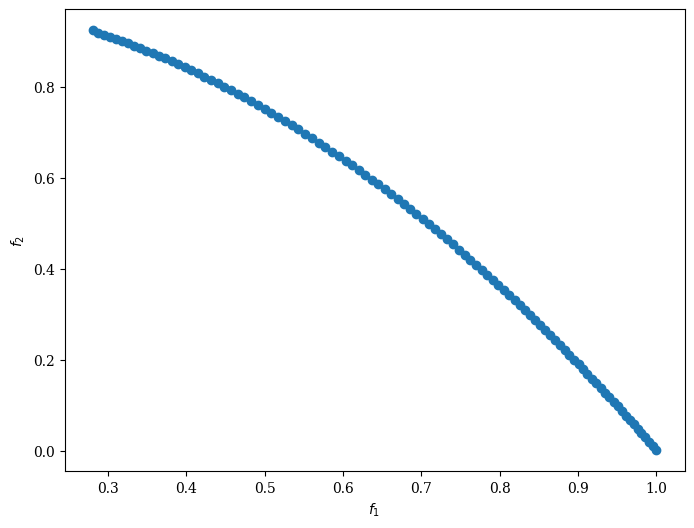

In [46]:
Scatter().add(res.F).show()

In [34]:
with open('pymoo_time_nsga3_zdt6_100_500_2_10.csv', 'w', newline='') as f, open('pymoo_fitness_nsga3_zdt6_100_500_2_10.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga3, ('n_gen', 500), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0089318752
     2 |      200 |  0.0126392841
     3 |      300 |  0.0305666924
     4 |      400 |  0.0305666924
     5 |      500 |  0.0518441200
     6 |      600 |  0.0628235340
     7 |      700 |  0.0727961063
     8 |      800 |  0.0798542500
     9 |      900 |  0.0798542500
    10 |     1000 |  0.0954780579
    11 |     1100 |  0.1111426353
    12 |     1200 |  0.1111426353
    13 |     1300 |  0.1267716885
    14 |     1400 |  0.1308174133
    15 |     1500 |  0.1464850903
    16 |     1600 |  0.1464850903
    17 |     1700 |  0.1621091366
    18 |     1800 |  0.1621091366
    19 |     1900 |  0.1777281761
    20 |     2000 |  0.1933510303
    21 |     2100 |  0.1933510303
    22 |     2200 |  0.2089762688
    23 |     2300 |  0.2089762688
    24 |     2400 |  0.2336859703
    25 |     2500 |  0.2482059002
    26 |     2600 |  0.2571856976
    27 |     2700 |  0.2677931786
    28 |     2800 |  0.2777655125
    29 |     2

   256 |    25600 |  2.6093807220
   257 |    25700 |  2.6305484772
   258 |    25800 |  2.6325950623
   259 |    25900 |  2.6556653976
   260 |    26000 |  2.6676313877
   261 |    26100 |  2.6801416874
   262 |    26200 |  2.6901087761
   263 |    26300 |  2.6947808266
   264 |    26400 |  2.7104375362
   265 |    26500 |  2.7174878120
   266 |    26600 |  2.7331550121
   267 |    26700 |  2.7331550121
   268 |    26800 |  2.7487375736
   269 |    26900 |  2.7643566132
   270 |    27000 |  2.7643566132
   271 |    27100 |  2.7800145149
   272 |    27200 |  2.7956411839
   273 |    27300 |  2.8112211227
   274 |    27400 |  2.8202092648
   275 |    27500 |  2.8380424976
   276 |    27600 |  2.8501148224
   277 |    27700 |  2.8600871563
   278 |    27800 |  2.8631558418
   279 |    27900 |  2.8787803650
   280 |    28000 |  2.8787803650
   281 |    28100 |  2.8944458961
   282 |    28200 |  2.9100255966
   283 |    28300 |  2.9180731773
   284 |    28400 |  2.9337415695
   285 |    28

In [17]:
algorithm_nsga2 = NSGA2(pop_size=MU, 
                  sampling=FloatRandomSampling(), 
                  selection = TournamentSelection(func_comp=binary_tournament), 
                  crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                  mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                  eliminate_duplicates=False)

algorithm_nsga3 = NSGA3(pop_size=MU, 
                  sampling=FloatRandomSampling(), 
                  selection=TournamentSelection(func_comp=comp_by_cv_then_random),
                  crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                  mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                  ref_dirs=ref_dirs,
                  eliminate_duplicates=False)

algorithm_nsga2_bin = NSGA2(pop_size=MU, 
                      sampling=BinaryRandomSampling(),
                      selection=TournamentSelection(func_comp=binary_tournament),
                      crossover=TwoPointCrossover(),
                      mutation=BitflipMutation(),
                      eliminate_duplicates=False)

algorithm_nsga3_bin = NSGA3(pop_size=MU, 
                            sampling=BinaryRandomSampling(), 
                            selection=TournamentSelection(func_comp=comp_by_cv_then_random),
                            crossover=TwoPointCrossover(),
                            mutation=BitflipMutation(),
                            ref_dirs=ref_dirs,
                            eliminate_duplicates=False)

In [18]:
for i in range(1, 11):
    print(f"Iteration {i}")
    
    NDIM = 3
    problem = ZDT1(n_var=NDIM)
    with open(f'pymoo_time_nsga2_zdt1_100_500_2_3-{i}.csv', 'w', newline='') as f, open(f'pymoo_fitness_nsga2_zdt1_100_500_2_3-{i}.csv','w', newline='') as g:
        writer = csv.writer(f)
        writer.writerow(["Execution Time"])
        
        writerFitness = csv.writer(g)
        writerFitness.writerow(["f1","f2"])
        start_time = time.time()
        res = minimize(problem, algorithm_nsga2, ('n_gen', NGEN), seed=i, output=measure_time(), verbose=True, save_history=False)
        
        for fitness in res.F:
            writerFitness.writerow(fitness)

    with open(f'pymoo_time_nsga3_zdt1_100_500_2_3-{i}.csv', 'w', newline='') as f, open(f'pymoo_fitness_nsga3_zdt1_100_500_2_3-{i}.csv','w', newline='') as g:
        writer = csv.writer(f)
        writer.writerow(["Execution Time"])
        
        writerFitness = csv.writer(g)
        writerFitness.writerow(["f1","f2"])
        start_time = time.time()
        res = minimize(problem, algorithm_nsga3, ('n_gen', NGEN), seed=i, output=measure_time(), verbose=True, save_history=False)
        
        for fitness in res.F:
                writerFitness.writerow(fitness)


    NDIM = 4
    problem = ZDT2(n_var=NDIM)
    with open(f'pymoo_time_nsga2_zdt2_100_500_2_4-{i}.csv', 'w', newline='') as f, open(f'pymoo_fitness_nsga2_zdt2_100_500_2_4-{i}.csv','w', newline='') as g:
        writer = csv.writer(f)
        writer.writerow(["Execution Time"])
    
        writerFitness = csv.writer(g)
        writerFitness.writerow(["f1","f2"])
        start_time = time.time()
        res = minimize(problem, algorithm_nsga2, ('n_gen', NGEN), seed=i, output=measure_time(), verbose=True, save_history=False)
        
        for fitness in res.F:
            writerFitness.writerow(fitness)

    with open(f'pymoo_time_nsga3_zdt2_100_500_2_4-{i}.csv', 'w', newline='') as f, open(f'pymoo_fitness_nsga3_zdt2_100_500_2_4-{i}.csv','w', newline='') as g:
        writer = csv.writer(f)
        writer.writerow(["Execution Time"])

        writerFitness = csv.writer(g)
        writerFitness.writerow(["f1","f2"])
        start_time = time.time()
        res = minimize(problem, algorithm_nsga3, ('n_gen', NGEN), seed=i, output=measure_time(), verbose=True, save_history=False)

        for fitness in res.F:
                writerFitness.writerow(fitness)


    NDIM = 5
    problem = ZDT3(n_var=NDIM)
    with open(f'pymoo_time_nsga2_zdt3_100_500_2_5-{i}.csv', 'w', newline='') as f, open(f'pymoo_fitness_nsga2_zdt3_100_500_2_5-{i}.csv','w', newline='') as g:
        writer = csv.writer(f)
        writer.writerow(["Execution Time"])

        writerFitness = csv.writer(g)
        writerFitness.writerow(["f1","f2"])
        start_time = time.time()
        res = minimize(problem, algorithm_nsga2, ('n_gen', NGEN), seed=i, output=measure_time(), verbose=True, save_history=False)

        for fitness in res.F:
                writerFitness.writerow(fitness)

    with open(f'pymoo_time_nsga3_zdt3_100_500_2_5-{i}.csv', 'w', newline='') as f, open(f'pymoo_fitness_nsga3_zdt3_100_500_2_5-{i}.csv','w', newline='') as g:
        writer = csv.writer(f)
        writer.writerow(["Execution Time"])

        writerFitness = csv.writer(g)
        writerFitness.writerow(["f1","f2"])
        start_time = time.time()
        res = minimize(problem, algorithm_nsga3, ('n_gen', NGEN), seed=i, output=measure_time(), verbose=True, save_history=False)

        for fitness in res.F:
                writerFitness.writerow(fitness)


    NDIM = 7
    problem = ZDT4(n_var=NDIM)
    with open(f'pymoo_time_nsga2_zdt4_100_500_2_7-{i}.csv', 'w', newline='') as f, open(f'pymoo_fitness_nsga2_zdt4_100_500_2_7-{i}.csv','w', newline='') as g:
        writer = csv.writer(f)
        writer.writerow(["Execution Time"])

        writerFitness = csv.writer(g)
        writerFitness.writerow(["f1","f2"])
        start_time = time.time()
        res = minimize(problem, algorithm_nsga2, ('n_gen', NGEN), seed=i, output=measure_time(), verbose=True, save_history=False)

        for fitness in res.F:
                writerFitness.writerow(fitness)

    with open(f'pymoo_time_nsga3_zdt4_100_500_2_7-{i}.csv', 'w', newline='') as f, open(f'pymoo_fitness_nsga3_zdt4_100_500_2_7-{i}.csv','w', newline='') as g:
        writer = csv.writer(f)
        writer.writerow(["Execution Time"])

        writerFitness = csv.writer(g)
        writer.writerow(["f1","f2"])
        start_time = time.time()
        res = minimize(problem, algorithm_nsga3, ('n_gen', NGEN), seed=i, output=measure_time(), verbose=True, save_history=False)

        for fitness in res.F:
                writerFitness.writerow(fitness)


    problem = ZDT5()
    with open(f'pymoo_time_nsga2_zdt5_100_500_2_80-{i}.csv', 'w', newline='') as f, open(f'pymoo_fitness_nsga2_zdt5_100_500_2_80-{i}.csv','w', newline='') as g:
        writer = csv.writer(f)
        writer.writerow(["Execution Time"])

        writerFitness = csv.writer(g)
        writer.writerow(["f1","f2"])
        start_time = time.time()
        res = minimize(problem, algorithm_nsga2_bin, ('n_gen', NGEN), seed=i, output=measure_time(), verbose=True, save_history=False)

        for fitness in res.F:
                writerFitness.writerow(fitness)

    with open(f'pymoo_time_nsga3_zdt5_100_500_2_80-{i}.csv', 'w', newline='') as f, open(f'pymoo_fitness_nsga3_zdt5_100_500_2_80-{i}.csv','w', newline='') as g:
        writer = csv.writer(f)
        writer.writerow(["Execution Time"])

        writerFitness = csv.writer(g)
        writerFitness.writerow(["f1","f2"])
        start_time = time.time()
        res = minimize(problem, algorithm_nsga3_bin, ('n_gen', NGEN), seed=i, output=measure_time(), verbose=True, save_history=False)

        for fitness in res.F:
                writerFitness.writerow(fitness)


    NDIM = 10
    problem = ZDT6(n_var=NDIM)
    with open(f'pymoo_time_nsga2_zdt6_100_500_2_10-{i}.csv', 'w', newline='') as f, open(f'pymoo_fitness_nsga2_zdt6_100_500_2_10-{i}.csv','w', newline='') as g:
        writer = csv.writer(f)
        writer.writerow(["Execution Time"])

        writerFitness = csv.writer(g)
        writerFitness.writerow(["f1","f2"])
        start_time = time.time()
        res = minimize(problem, algorithm_nsga2, ('n_gen', 500), seed=i, output=measure_time(), verbose=True, save_history=False)

        for fitness in res.F:
                writerFitness.writerow(fitness)

    with open(f'pymoo_time_nsga3_zdt6_100_500_2_10-{i}.csv', 'w', newline='') as f, open(f'pymoo_fitness_nsga3_zdt6_100_500_2_10-{i}.csv','w', newline='') as g:
        writer = csv.writer(f)
        writer.writerow(["Execution Time"])

        writerFitness = csv.writer(g)
        writerFitness.writerow(["f1","f2"])
        start_time = time.time()
        res = minimize(problem, algorithm_nsga3, ('n_gen', 500), seed=i, output=measure_time(), verbose=True, save_history=False)

        for fitness in res.F:
                writerFitness.writerow(fitness)

Iteration 1
n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0202760696
     2 |      200 |  0.0322494507
     3 |      300 |  0.0362613201
     4 |      400 |  0.0487928391
     5 |      500 |  0.0568437576
     6 |      600 |  0.0659141541
     7 |      700 |  0.0712740421
     8 |      800 |  0.0830078125
     9 |      900 |  0.0870623589
    10 |     1000 |  0.1001985073
    11 |     1100 |  0.1052443981
    12 |     1200 |  0.1171977520
    13 |     1300 |  0.1222512722
    14 |     1400 |  0.1303021908
    15 |     1500 |  0.1383523941
    16 |     1600 |  0.1464538574
    17 |     1700 |  0.1504986286
    18 |     1800 |  0.1612734795
    19 |     1900 |  0.1721482277
    20 |     2000 |  0.1788735390
    21 |     2100 |  0.1869235039
    22 |     2200 |  0.1955494881
    23 |     2300 |  0.1994752884
    24 |     2400 |  0.2119853497
    25 |     2500 |  0.2250592709
    26 |     2600 |  0.2334392071
    27 |     2700 |  0.2385902405
    28 |     2800 |  0.2470710278
  

   251 |    25100 |  2.5913839340
   252 |    25200 |  2.6049365997
   253 |    25300 |  2.6191329956
   254 |    25400 |  2.6231460571
   255 |    25500 |  2.6393785477
   256 |    25600 |  2.6505463123
   257 |    25700 |  2.6589684486
   258 |    25800 |  2.6694195271
   259 |    25900 |  2.6827545166
   260 |    26000 |  2.6897358894
   261 |    26100 |  2.6992890835
   262 |    26200 |  2.7053592205
   263 |    26300 |  2.7175650597
   264 |    26400 |  2.7255752087
   265 |    26500 |  2.7352569103
   266 |    26600 |  2.7432692051
   267 |    26700 |  2.7511456013
   268 |    26800 |  2.7591974735
   269 |    26900 |  2.7699944973
   270 |    27000 |  2.7819302082
   271 |    27100 |  2.7897720337
   272 |    27200 |  2.7986276150
   273 |    27300 |  2.8088395596
   274 |    27400 |  2.8175487518
   275 |    27500 |  2.8345015049
   276 |    27600 |  2.8402595520
   277 |    27700 |  2.8518948555
   278 |    27800 |  2.8651425838
   279 |    27900 |  2.8737919331
   280 |    28

   496 |    49600 |  4.9507608414
   497 |    49700 |  4.9661016464
   498 |    49800 |  4.9766707420
   499 |    49900 |  4.9850170612
   500 |    50000 |  5.0047857761
n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0095095634
     2 |      200 |  0.0191953182
     3 |      300 |  0.0356566906
     4 |      400 |  0.0429365635
     5 |      500 |  0.0558211803
     6 |      600 |  0.0648369789
     7 |      700 |  0.0749444962
     8 |      800 |  0.0847835541
     9 |      900 |  0.0951187611
    10 |     1000 |  0.1088075638
    11 |     1100 |  0.1204965115
    12 |     1200 |  0.1295077801
    13 |     1300 |  0.1402442455
    14 |     1400 |  0.1537144184
    15 |     1500 |  0.1639013290
    16 |     1600 |  0.1749029160
    17 |     1700 |  0.1831190586
    18 |     1800 |  0.1949093342
    19 |     1900 |  0.2107107639
    20 |     2000 |  0.2237279415
    21 |     2100 |  0.2361085415
    22 |     2200 |  0.2468323708
    23 |     2300 |  0.2606735229
    24 |     2

   246 |    24600 |  6.3368208408
   247 |    24700 |  6.3502881527
   248 |    24800 |  6.3700666428
   249 |    24900 |  6.4015564919
   250 |    25000 |  6.4189071655
   251 |    25100 |  6.4363486767
   252 |    25200 |  6.4486513138
   253 |    25300 |  6.4616522789
   254 |    25400 |  6.4746723175
   255 |    25500 |  6.4846756458
   256 |    25600 |  6.5009353161
   257 |    25700 |  6.5127594471
   258 |    25800 |  6.5264818668
   259 |    25900 |  6.5383746624
   260 |    26000 |  6.5599584579
   261 |    26100 |  6.5705955029
   262 |    26200 |  6.5870256424
   263 |    26300 |  6.5998497009
   264 |    26400 |  6.6008520126
   265 |    26500 |  6.6188247204
   266 |    26600 |  6.6385571957
   267 |    26700 |  6.6561312675
   268 |    26800 |  6.6723773479
   269 |    26900 |  6.6832938194
   270 |    27000 |  6.7027115822
   271 |    27100 |  6.7162308693
   272 |    27200 |  6.7316162586
   273 |    27300 |  6.7485482693
   274 |    27400 |  6.7540836334
   275 |    27

   490 |    49000 |  9.8401291370
   491 |    49100 |  9.8511939049
   492 |    49200 |  9.8694887161
   493 |    49300 |  9.8806622028
   494 |    49400 |  9.8857839108
   495 |    49500 |  9.9034442902
   496 |    49600 |  9.9199056625
   497 |    49700 |  9.9392471313
   498 |    49800 |  9.9533462524
   499 |    49900 |  9.9553403854
   500 |    50000 |  9.9708139896
n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0030276775
     2 |      200 |  0.0184185505
     3 |      300 |  0.0284833908
     4 |      400 |  0.0357332230
     5 |      500 |  0.0507175922
     6 |      600 |  0.0542659760
     7 |      700 |  0.0694024563
     8 |      800 |  0.0822892189
     9 |      900 |  0.0860416889
    10 |     1000 |  0.1037745476
    11 |     1100 |  0.1037745476
    12 |     1200 |  0.1209712029
    13 |     1300 |  0.1209712029
    14 |     1400 |  0.1338577271
    15 |     1500 |  0.1487951279
    16 |     1600 |  0.1554989815
    17 |     1700 |  0.1678566933
    18 |     1

   247 |    24700 |  2.2359719276
   248 |    24800 |  2.2489643097
   249 |    24900 |  2.2508382797
   250 |    25000 |  2.2573916912
   251 |    25100 |  2.2674198151
   252 |    25200 |  2.2674198151
   253 |    25300 |  2.2840471268
   254 |    25400 |  2.2840471268
   255 |    25500 |  2.3003783226
   256 |    25600 |  2.3003783226
   257 |    25700 |  2.3155069351
   258 |    25800 |  2.3179371357
   259 |    25900 |  2.3279929161
   260 |    26000 |  2.3340280056
   261 |    26100 |  2.3340280056
   262 |    26200 |  2.3516900539
   263 |    26300 |  2.3588540554
   264 |    26400 |  2.3682477474
   265 |    26500 |  2.3682477474
   266 |    26600 |  2.3836927414
   267 |    26700 |  2.3846871853
   268 |    26800 |  2.3966560364
   269 |    26900 |  2.4016082287
   270 |    27000 |  2.4016082287
   271 |    27100 |  2.4202964306
   272 |    27200 |  2.4202964306
   273 |    27300 |  2.4347567558
   274 |    27400 |  2.4347567558
   275 |    27500 |  2.4514248371
   276 |    27

   494 |    49400 |  4.1820261478
   495 |    49500 |  4.1853742599
   496 |    49600 |  4.1976292133
   497 |    49700 |  4.1996107101
   498 |    49800 |  4.2118198872
   499 |    49900 |  4.2148127556
   500 |    50000 |  4.2255585194
n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0009889603
     2 |      200 |  0.0169816017
     3 |      300 |  0.0271143913
     4 |      400 |  0.0327394009
     5 |      500 |  0.0464956760
     6 |      600 |  0.0493199825
     7 |      700 |  0.0670661926
     8 |      800 |  0.0670661926
     9 |      900 |  0.0847697258
    10 |     1000 |  0.1005818844
    11 |     1100 |  0.1005818844
    12 |     1200 |  0.1188158989
    13 |     1300 |  0.1321628094
    14 |     1400 |  0.1444201469
    15 |     1500 |  0.1498553753
    16 |     1600 |  0.1656994820
    17 |     1700 |  0.1692905426
    18 |     1800 |  0.1844213009
    19 |     1900 |  0.2006034851
    20 |     2000 |  0.2127358913
    21 |     2100 |  0.2167124748
    22 |     2

   241 |    24100 |  3.4862976074
   242 |    24200 |  3.5090126991
   243 |    24300 |  3.5359027386
   244 |    24400 |  3.5598351955
   245 |    24500 |  3.5878000259
   246 |    24600 |  3.6126937866
   247 |    24700 |  3.6376273632
   248 |    24800 |  3.6616315842
   249 |    24900 |  3.6795821190
   250 |    25000 |  3.6955397129
   251 |    25100 |  3.7134938240
   252 |    25200 |  3.7315094471
   253 |    25300 |  3.7444519997
   254 |    25400 |  3.7574124336
   255 |    25500 |  3.7693800926
   256 |    25600 |  3.7803130150
   257 |    25700 |  3.7932794094
   258 |    25800 |  3.8052837849
   259 |    25900 |  3.8172142506
   260 |    26000 |  3.8281843662
   261 |    26100 |  3.8391547203
   262 |    26200 |  3.8513588905
   263 |    26300 |  3.8623316288
   264 |    26400 |  3.8753368855
   265 |    26500 |  3.8872642517
   266 |    26600 |  3.8992857933
   267 |    26700 |  3.9112370014
   268 |    26800 |  3.9251611233
   269 |    26900 |  3.9381291866
   270 |    27

   482 |    48200 |  6.7894198895
   483 |    48300 |  6.8013875484
   484 |    48400 |  6.8133940697
   485 |    48500 |  6.8243257999
   486 |    48600 |  6.8373305798
   487 |    48700 |  6.8492987156
   488 |    48800 |  6.8602304459
   489 |    48900 |  6.8721978664
   490 |    49000 |  6.8861627579
   491 |    49100 |  6.8981311321
   492 |    49200 |  6.9110958576
   493 |    49300 |  6.9230632782
   494 |    49400 |  6.9360632896
   495 |    49500 |  6.9469981194
   496 |    49600 |  6.9590036869
   497 |    49700 |  6.9709711075
   498 |    49800 |  6.9829072952
   499 |    49900 |  6.9939105511
   500 |    50000 |  7.0068380833
n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0079767704
     2 |      200 |  0.0159552097
     3 |      300 |  0.0249714851
     4 |      400 |  0.0319569111
     5 |      500 |  0.0428833961
     6 |      600 |  0.0498645306
     7 |      700 |  0.0588402748
     8 |      800 |  0.0658216476
     9 |      900 |  0.0757970810
    10 |     1

   235 |    23500 |  2.4161980152
   236 |    23600 |  2.4269812107
   237 |    23700 |  2.4349603653
   238 |    23800 |  2.4469292164
   239 |    23900 |  2.4559068680
   240 |    24000 |  2.4648468494
   241 |    24100 |  2.4775583744
   242 |    24200 |  2.4838588238
   243 |    24300 |  2.4948019981
   244 |    24400 |  2.5057761669
   245 |    24500 |  2.5157485008
   246 |    24600 |  2.5256297588
   247 |    24700 |  2.5327003002
   248 |    24800 |  2.5446708202
   249 |    24900 |  2.5506527424
   250 |    25000 |  2.5617117882
   251 |    25100 |  2.5676958561
   252 |    25200 |  2.5797045231
   253 |    25300 |  2.5876433849
   254 |    25400 |  2.5946619511
   255 |    25500 |  2.6026160717
   256 |    25600 |  2.6116194725
   257 |    25700 |  2.6195640564
   258 |    25800 |  2.6305665970
   259 |    25900 |  2.6411149502
   260 |    26000 |  2.6491308212
   261 |    26100 |  2.6590669155
   262 |    26200 |  2.6650879383
   263 |    26300 |  2.6750245094
   264 |    26

   481 |    48100 |  4.8120300770
   482 |    48200 |  4.8220047951
   483 |    48300 |  4.8300194740
   484 |    48400 |  4.8399934769
   485 |    48500 |  4.8469364643
   486 |    48600 |  4.8589050770
   487 |    48700 |  4.8668847084
   488 |    48800 |  4.8778905869
   489 |    48900 |  4.8848373890
   490 |    49000 |  4.8948080540
   491 |    49100 |  4.9049570560
   492 |    49200 |  4.9127597809
   493 |    49300 |  4.9217371941
   494 |    49400 |  4.9307122231
   495 |    49500 |  4.9406855106
   496 |    49600 |  4.9477064610
   497 |    49700 |  4.9586396217
   498 |    49800 |  4.9656205177
   499 |    49900 |  4.9762027264
   500 |    50000 |  4.9821872711
n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0069804192
     2 |      200 |  0.0199470520
     3 |      300 |  0.0329120159
     4 |      400 |  0.0488693714
     5 |      500 |  0.0598771572
     6 |      600 |  0.0718090534
     7 |      700 |  0.0847771168
     8 |      800 |  0.0937483311
     9 |      

   226 |    22600 |  3.0856842995
   227 |    22700 |  3.1029119492
   228 |    22800 |  3.1178674698
   229 |    22900 |  3.1308312416
   230 |    23000 |  3.1457929611
   231 |    23100 |  3.1587605476
   232 |    23200 |  3.1767098904
   233 |    23300 |  3.1942932606
   234 |    23400 |  3.2082180977
   235 |    23500 |  3.2212846279
   236 |    23600 |  3.2351467609
   237 |    23700 |  3.2550930977
   238 |    23800 |  3.2710537910
   239 |    23900 |  3.2880430222
   240 |    24000 |  3.3045928478
   241 |    24100 |  3.3225088120
   242 |    24200 |  3.3354723454
   243 |    24300 |  3.3534283638
   244 |    24400 |  3.3674299717
   245 |    24500 |  3.3774008751
   246 |    24600 |  3.3923196793
   247 |    24700 |  3.4033284187
   248 |    24800 |  3.4152965546
   249 |    24900 |  3.4252758026
   250 |    25000 |  3.4381968975
   251 |    25100 |  3.4502029419
   252 |    25200 |  3.4631447792
   253 |    25300 |  3.4771299362
   254 |    25400 |  3.4882254601
   255 |    25

   482 |    48200 |  6.3559100628
   483 |    48300 |  6.3689701557
   484 |    48400 |  6.3806335926
   485 |    48500 |  6.3916270733
   486 |    48600 |  6.4045546055
   487 |    48700 |  6.4185559750
   488 |    48800 |  6.4305195808
   489 |    48900 |  6.4414556026
   490 |    49000 |  6.4544227123
   491 |    49100 |  6.4664294720
   492 |    49200 |  6.4764049053
   493 |    49300 |  6.4934463501
   494 |    49400 |  6.5063226223
   495 |    49500 |  6.5212812424
   496 |    49600 |  6.5352056026
   497 |    49700 |  6.5501666069
   498 |    49800 |  6.5611350536
   499 |    49900 |  6.5741026402
   500 |    50000 |  6.5880632401
n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0080153942
     2 |      200 |  0.0159990788
     3 |      300 |  0.0251734257
     4 |      400 |  0.0329105854
     5 |      500 |  0.0409288406
     6 |      600 |  0.0489130020
     7 |      700 |  0.0591428280
     8 |      800 |  0.0668199062
     9 |      900 |  0.0767951012
    10 |     1

   240 |    24000 |  2.3960647583
   241 |    24100 |  2.4120218754
   242 |    24200 |  2.4279792309
   243 |    24300 |  2.4439394474
   244 |    24400 |  2.4578983784
   245 |    24500 |  2.4668743610
   246 |    24600 |  2.4768869877
   247 |    24700 |  2.4848268032
   248 |    24800 |  2.4958009720
   249 |    24900 |  2.5027801991
   250 |    25000 |  2.5127546787
   251 |    25100 |  2.5250341892
   252 |    25200 |  2.5429682732
   253 |    25300 |  2.5499529839
   254 |    25400 |  2.5599243641
   255 |    25500 |  2.5659058094
   256 |    25600 |  2.5758416653
   257 |    25700 |  2.5818254948
   258 |    25800 |  2.5918390751
   259 |    25900 |  2.5989201069
   260 |    26000 |  2.6107497215
   261 |    26100 |  2.6187636852
   262 |    26200 |  2.6280758381
   263 |    26300 |  2.6360523701
   264 |    26400 |  2.6466438770
   265 |    26500 |  2.6559998989
   266 |    26600 |  2.6630196571
   267 |    26700 |  2.6719622612
   268 |    26800 |  2.6809711456
   269 |    26

   500 |    50000 |  4.7720506191
n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0080158710
     2 |      200 |  0.0169961452
     3 |      300 |  0.0259292126
     4 |      400 |  0.0349051952
     5 |      500 |  0.0459134579
     6 |      600 |  0.0548515320
     7 |      700 |  0.0648646355
     8 |      800 |  0.0757954121
     9 |      900 |  0.0837743282
    10 |     1000 |  0.0947849751
    11 |     1100 |  0.1037507057
    12 |     1200 |  0.1137330532
    13 |     1300 |  0.1227076054
    14 |     1400 |  0.1316962242
    15 |     1500 |  0.1416578293
    16 |     1600 |  0.1506373882
    17 |     1700 |  0.1596095562
    18 |     1800 |  0.1695899963
    19 |     1900 |  0.1795554161
    20 |     2000 |  0.1914882660
    21 |     2100 |  0.2055938244
    22 |     2200 |  0.2194530964
    23 |     2300 |  0.2313804626
    24 |     2400 |  0.2413544655
    25 |     2500 |  0.2523233891
    26 |     2600 |  0.2653722763
    27 |     2700 |  0.2763433456
    28 |     2

   240 |    24000 |  3.0976469517
   241 |    24100 |  3.1116495132
   242 |    24200 |  3.1245765686
   243 |    24300 |  3.1355457306
   244 |    24400 |  3.1485114098
   245 |    24500 |  3.1604785919
   246 |    24600 |  3.1710057259
   247 |    24700 |  3.1809790134
   248 |    24800 |  3.1909527779
   249 |    24900 |  3.2019250393
   250 |    25000 |  3.2148933411
   251 |    25100 |  3.2268579006
   252 |    25200 |  3.2378289700
   253 |    25300 |  3.2497971058
   254 |    25400 |  3.2607674599
   255 |    25500 |  3.2737309933
   256 |    25600 |  3.2837040424
   257 |    25700 |  3.2936775684
   258 |    25800 |  3.3076412678
   259 |    25900 |  3.3245944977
   260 |    26000 |  3.3385574818
   261 |    26100 |  3.3495817184
   262 |    26200 |  3.3625314236
   263 |    26300 |  3.3849542141
   264 |    26400 |  3.3989548683
   265 |    26500 |  3.4138777256
   266 |    26600 |  3.4278404713
   267 |    26700 |  3.4444692135
   268 |    26800 |  3.4577631950
   269 |    26

   497 |    49700 |  6.5953559875
   498 |    49800 |  6.6112771034
   499 |    49900 |  6.6232445240
   500 |    50000 |  6.6342587471
n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0089769363
     2 |      200 |  0.0189495087
     3 |      300 |  0.0269644260
     4 |      400 |  0.0359029770
     5 |      500 |  0.0438811779
     6 |      600 |  0.0528583527
     7 |      700 |  0.0608384609
     8 |      800 |  0.0728435516
     9 |      900 |  0.0808217525
    10 |     1000 |  0.0878031254
    11 |     1100 |  0.0971698761
    12 |     1200 |  0.1037211418
    13 |     1300 |  0.1117000580
    14 |     1400 |  0.1186809540
    15 |     1500 |  0.1256623268
    16 |     1600 |  0.1346409321
    17 |     1700 |  0.1426200867
    18 |     1800 |  0.1505982876
    19 |     1900 |  0.1595733166
    20 |     2000 |  0.1675529480
    21 |     2100 |  0.1785254478
    22 |     2200 |  0.1914868355
    23 |     2300 |  0.1995012760
    24 |     2400 |  0.2084770203
    25 |     2

   248 |    24800 |  2.3349313736
   249 |    24900 |  2.3644506931
   250 |    25000 |  2.3873727322
   251 |    25100 |  2.3999743462
   252 |    25200 |  2.4090797901
   253 |    25300 |  2.4152882099
   254 |    25400 |  2.4356195927
   255 |    25500 |  2.4366178513
   256 |    25600 |  2.4534158707
   257 |    25700 |  2.4534158707
   258 |    25800 |  2.4721715450
   259 |    25900 |  2.4808857441
   260 |    26000 |  2.4808857441
   261 |    26100 |  2.4808857441
   262 |    26200 |  2.4996383190
   263 |    26300 |  2.4996383190
   264 |    26400 |  2.5163443089
   265 |    26500 |  2.5163443089
   266 |    26600 |  2.5346534252
   267 |    26700 |  2.5346534252
   268 |    26800 |  2.5522871017
   269 |    26900 |  2.5683672428
   270 |    27000 |  2.5711977482
   271 |    27100 |  2.5820095539
   272 |    27200 |  2.5900886059
   273 |    27300 |  2.5996403694
   274 |    27400 |  2.6049454212
   275 |    27500 |  2.6151421070
   276 |    27600 |  2.6151421070
   277 |    27

   495 |    49500 |  4.5326082706
   496 |    49600 |  4.5474126339
   497 |    49700 |  4.5523860455
   498 |    49800 |  4.5672600269
   499 |    49900 |  4.5682590008
   500 |    50000 |  4.5819604397
n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0084993839
     2 |      200 |  0.0173461437
     3 |      300 |  0.0253756046
     4 |      400 |  0.0381803513
     5 |      500 |  0.0451934338
     6 |      600 |  0.0633726120
     7 |      700 |  0.0633726120
     8 |      800 |  0.0886011124
     9 |      900 |  0.0966551304
    10 |     1000 |  0.0966551304
    11 |     1100 |  0.1286587715
    12 |     1200 |  0.1286587715
    13 |     1300 |  0.1463665962
    14 |     1400 |  0.1463665962
    15 |     1500 |  0.1710765362
    16 |     1600 |  0.1878311634
    17 |     1700 |  0.2047672272
    18 |     1800 |  0.2208230495
    19 |     1900 |  0.2356064320
    20 |     2000 |  0.2532067299
    21 |     2100 |  0.2695152760
    22 |     2200 |  0.2890229225
    23 |     2

   233 |    23300 |  3.2093827724
   234 |    23400 |  3.2288129330
   235 |    23500 |  3.2439086437
   236 |    23600 |  3.2592887878
   237 |    23700 |  3.2729992867
   238 |    23800 |  3.2838473320
   239 |    23900 |  3.2999191284
   240 |    24000 |  3.3128244877
   241 |    24100 |  3.3296792507
   242 |    24200 |  3.3443725109
   243 |    24300 |  3.3497164249
   244 |    24400 |  3.3671395779
   245 |    24500 |  3.3898682594
   246 |    24600 |  3.4022140503
   247 |    24700 |  3.4295921326
   248 |    24800 |  3.4476153851
   249 |    24900 |  3.4622390270
   250 |    25000 |  3.4680817127
   251 |    25100 |  3.4868342876
   252 |    25200 |  3.5151422024
   253 |    25300 |  3.5335774422
   254 |    25400 |  3.5655901432
   255 |    25500 |  3.5784256458
   256 |    25600 |  3.5784256458
   257 |    25700 |  3.5989484787
   258 |    25800 |  3.6094269753
   259 |    25900 |  3.6094269753
   260 |    26000 |  3.6272730827
   261 |    26100 |  3.6475226879
   262 |    26

   478 |    47800 |  6.9476058483
   479 |    47900 |  6.9645125866
   480 |    48000 |  6.9803977013
   481 |    48100 |  6.9965450764
   482 |    48200 |  7.0121638775
   483 |    48300 |  7.0273299217
   484 |    48400 |  7.0448801517
   485 |    48500 |  7.0529258251
   486 |    48600 |  7.0590195656
   487 |    48700 |  7.0767614841
   488 |    48800 |  7.0767614841
   489 |    48900 |  7.1032567024
   490 |    49000 |  7.1208112240
   491 |    49100 |  7.1368682384
   492 |    49200 |  7.1476054192
   493 |    49300 |  7.1665694714
   494 |    49400 |  7.1808462143
   495 |    49500 |  7.1948633194
   496 |    49600 |  7.2024116516
   497 |    49700 |  7.2126989365
   498 |    49800 |  7.2275006771
   499 |    49900 |  7.2355868816
   500 |    50000 |  7.2516345978
n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0038504601
     2 |      200 |  0.0038504601
     3 |      300 |  0.0216019154
     4 |      400 |  0.0216019154
     5 |      500 |  0.0371758938
     6 |      

   232 |    23200 |  2.0595254898
   233 |    23300 |  2.0719475746
   234 |    23400 |  2.0836200714
   235 |    23500 |  2.0880582333
   236 |    23600 |  2.0984416008
   237 |    23700 |  2.1039915085
   238 |    23800 |  2.1039915085
   239 |    23900 |  2.1148812771
   240 |    24000 |  2.1214168072
   241 |    24100 |  2.1214168072
   242 |    24200 |  2.1370379925
   243 |    24300 |  2.1370379925
   244 |    24400 |  2.1495931149
   245 |    24500 |  2.1547987461
   246 |    24600 |  2.1547987461
   247 |    24700 |  2.1692717075
   248 |    24800 |  2.1712651253
   249 |    24900 |  2.1712651253
   250 |    25000 |  2.1890141964
   251 |    25100 |  2.1890141964
   252 |    25200 |  2.2047383785
   253 |    25300 |  2.2047383785
   254 |    25400 |  2.2213668823
   255 |    25500 |  2.2223649025
   256 |    25600 |  2.2223649025
   257 |    25700 |  2.2370223999
   258 |    25800 |  2.2370223999
   259 |    25900 |  2.2547709942
   260 |    26000 |  2.2547709942
   261 |    26

   477 |    47700 |  4.0146682262
   478 |    47800 |  4.0253624916
   479 |    47900 |  4.0411973000
   480 |    48000 |  4.0525887012
   481 |    48100 |  4.0635757446
   482 |    48200 |  4.0758249760
   483 |    48300 |  4.0783736706
   484 |    48400 |  4.0888285637
   485 |    48500 |  4.0999372005
   486 |    48600 |  4.1048600674
   487 |    48700 |  4.1195375919
   488 |    48800 |  4.1205384731
   489 |    48900 |  4.1370639801
   490 |    49000 |  4.1370639801
   491 |    49100 |  4.1487634182
   492 |    49200 |  4.1545760632
   493 |    49300 |  4.1545760632
   494 |    49400 |  4.1712508202
   495 |    49500 |  4.1774361134
   496 |    49600 |  4.1868104935
   497 |    49700 |  4.1878452301
   498 |    49800 |  4.1878452301
   499 |    49900 |  4.2046532631
   500 |    50000 |  4.2046532631
n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0074131489
     2 |      200 |  0.0199780464
     3 |      300 |  0.0275840759
     4 |      400 |  0.0426151752
     5 |      

   216 |    21600 |  2.6425364017
   217 |    21700 |  2.6577818394
   218 |    21800 |  2.6776518822
   219 |    21900 |  2.6914565563
   220 |    22000 |  2.7043397427
   221 |    22100 |  2.7101318836
   222 |    22200 |  2.7217879295
   223 |    22300 |  2.7382779121
   224 |    22400 |  2.7463328838
   225 |    22500 |  2.7534592152
   226 |    22600 |  2.7707312107
   227 |    22700 |  2.7838928699
   228 |    22800 |  2.7958455086
   229 |    22900 |  2.8107843399
   230 |    23000 |  2.8275218010
   231 |    23100 |  2.8406548500
   232 |    23200 |  2.8530023098
   233 |    23300 |  2.8609337807
   234 |    23400 |  2.8809344769
   235 |    23500 |  2.8953635693
   236 |    23600 |  2.9109587669
   237 |    23700 |  2.9232048988
   238 |    23800 |  2.9279847145
   239 |    23900 |  2.9457705021
   240 |    24000 |  2.9546854496
   241 |    24100 |  2.9709181786
   242 |    24200 |  2.9789638519
   243 |    24300 |  2.9890151024
   244 |    24400 |  3.0047767162
   245 |    24

   461 |    46100 |  5.9106998444
   462 |    46200 |  5.9232060909
   463 |    46300 |  5.9322640896
   464 |    46400 |  5.9415585995
   465 |    46500 |  5.9592089653
   466 |    46600 |  5.9751133919
   467 |    46700 |  5.9889097214
   468 |    46800 |  5.9928996563
   469 |    46900 |  6.0088975430
   470 |    47000 |  6.0244977474
   471 |    47100 |  6.0390102863
   472 |    47200 |  6.0527825356
   473 |    47300 |  6.0613636971
   474 |    47400 |  6.0722260475
   475 |    47500 |  6.0872919559
   476 |    47600 |  6.0974702835
   477 |    47700 |  6.1110098362
   478 |    47800 |  6.1222524643
   479 |    47900 |  6.1365308762
   480 |    48000 |  6.1483573914
   481 |    48100 |  6.1529741287
   482 |    48200 |  6.1705782413
   483 |    48300 |  6.1798033714
   484 |    48400 |  6.1984176636
   485 |    48500 |  6.2111008167
   486 |    48600 |  6.2256569862
   487 |    48700 |  6.2388250828
   488 |    48800 |  6.2520170212
   489 |    48900 |  6.2603266239
   490 |    49

   204 |    20400 |  1.6526217461
   205 |    20500 |  1.6559987068
   206 |    20600 |  1.6711056232
   207 |    20700 |  1.6725292206
   208 |    20800 |  1.6805472374
   209 |    20900 |  1.6904017925
   210 |    21000 |  1.6904017925
   211 |    21100 |  1.7006058693
   212 |    21200 |  1.7062642574
   213 |    21300 |  1.7062642574
   214 |    21400 |  1.7230200768
   215 |    21500 |  1.7240178585
   216 |    21600 |  1.7240178585
   217 |    21700 |  1.7417905331
   218 |    21800 |  1.7417905331
   219 |    21900 |  1.7417905331
   220 |    22000 |  1.7595992088
   221 |    22100 |  1.7629513741
   222 |    22200 |  1.7629513741
   223 |    22300 |  1.7786221504
   224 |    22400 |  1.7786221504
   225 |    22500 |  1.7896299362
   226 |    22600 |  1.7896299362
   227 |    22700 |  1.7896299362
   228 |    22800 |  1.8091354370
   229 |    22900 |  1.8091354370
   230 |    23000 |  1.8091354370
   231 |    23100 |  1.8269195557
   232 |    23200 |  1.8269195557
   233 |    23

   454 |    45400 |  3.5760021210
   455 |    45500 |  3.5848927498
   456 |    45600 |  3.6000745296
   457 |    45700 |  3.6058807373
   458 |    45800 |  3.6139340401
   459 |    45900 |  3.6139340401
   460 |    46000 |  3.6235477924
   461 |    46100 |  3.6315991879
   462 |    46200 |  3.6396863461
   463 |    46300 |  3.6417205334
   464 |    46400 |  3.6417205334
   465 |    46500 |  3.6595437527
   466 |    46600 |  3.6605412960
   467 |    46700 |  3.6605412960
   468 |    46800 |  3.6762199402
   469 |    46900 |  3.6762199402
   470 |    47000 |  3.6762199402
   471 |    47100 |  3.6908004284
   472 |    47200 |  3.6908004284
   473 |    47300 |  3.7085909843
   474 |    47400 |  3.7095844746
   475 |    47500 |  3.7095844746
   476 |    47600 |  3.7270467281
   477 |    47700 |  3.7270467281
   478 |    47800 |  3.7270467281
   479 |    47900 |  3.7455575466
   480 |    48000 |  3.7455575466
   481 |    48100 |  3.7657504082
   482 |    48200 |  3.7657504082
   483 |    48

   201 |    20100 |  2.7600848675
   202 |    20200 |  2.7765865326
   203 |    20300 |  2.7885918617
   204 |    20400 |  2.7995254993
   205 |    20500 |  2.8184847832
   206 |    20600 |  2.8344323635
   207 |    20700 |  2.8513877392
   208 |    20800 |  2.8646962643
   209 |    20900 |  2.8767054081
   210 |    21000 |  2.8886742592
   211 |    21100 |  2.9069294930
   212 |    21200 |  2.9195892811
   213 |    21300 |  2.9375040531
   214 |    21400 |  2.9544582367
   215 |    21500 |  2.9773981571
   216 |    21600 |  2.9963514805
   217 |    21700 |  3.0103106499
   218 |    21800 |  3.0212812424
   219 |    21900 |  3.0322899818
   220 |    22000 |  3.0472137928
   221 |    22100 |  3.0581822395
   222 |    22200 |  3.0721743107
   223 |    22300 |  3.0871338844
   224 |    22400 |  3.0991022587
   225 |    22500 |  3.1100735664
   226 |    22600 |  3.1300208569
   227 |    22700 |  3.1449818611
   228 |    22800 |  3.1605250835
   229 |    22900 |  3.1714258194
   230 |    23

   451 |    45100 |  6.0490291119
   452 |    45200 |  6.0779905319
   453 |    45300 |  6.0998928547
   454 |    45400 |  6.1148514748
   455 |    45500 |  6.1258220673
   456 |    45600 |  6.1367933750
   457 |    45700 |  6.1467659473
   458 |    45800 |  6.1587347984
   459 |    45900 |  6.1697049141
   460 |    46000 |  6.1826703548
   461 |    46100 |  6.1946382523
   462 |    46200 |  6.2135922909
   463 |    46300 |  6.2345685959
   464 |    46400 |  6.2475407124
   465 |    46500 |  6.2595093250
   466 |    46600 |  6.2984015942
   467 |    46700 |  6.3333103657
   468 |    46800 |  6.3632326126
   469 |    46900 |  6.3961434364
   470 |    47000 |  6.4320476055
   471 |    47100 |  6.4630022049
   472 |    47200 |  6.4911003113
   473 |    47300 |  6.5230531693
   474 |    47400 |  6.5579192638
   475 |    47500 |  6.5864996910
   476 |    47600 |  6.6164174080
   477 |    47700 |  6.6343264580
   478 |    47800 |  6.6513149738
   479 |    47900 |  6.6742522717
   480 |    48

   197 |    19700 |  2.1237056255
   198 |    19800 |  2.1346740723
   199 |    19900 |  2.1416552067
   200 |    20000 |  2.1476395130
   201 |    20100 |  2.1556198597
   202 |    20200 |  2.1626014709
   203 |    20300 |  2.1695826054
   204 |    20400 |  2.1765642166
   205 |    20500 |  2.1845414639
   206 |    20600 |  2.1915588379
   207 |    20700 |  2.2004988194
   208 |    20800 |  2.2074818611
   209 |    20900 |  2.2154600620
   210 |    21000 |  2.2224788666
   211 |    21100 |  2.2304227352
   212 |    21200 |  2.2383971214
   213 |    21300 |  2.2453787327
   214 |    21400 |  2.2533569336
   215 |    21500 |  2.2673196793
   216 |    21600 |  2.2743413448
   217 |    21700 |  2.2832803726
   218 |    21800 |  2.2942473888
   219 |    21900 |  2.3042206764
   220 |    22000 |  2.3112230301
   221 |    22100 |  2.3182439804
   222 |    22200 |  2.3271808624
   223 |    22300 |  2.3331644535
   224 |    22400 |  2.3421409130
   225 |    22500 |  2.3521134853
   226 |    22

   446 |    44600 |  4.0982055664
   447 |    44700 |  4.1121284962
   448 |    44800 |  4.1250936985
   449 |    44900 |  4.1426455975
   450 |    45000 |  4.1580090523
   451 |    45100 |  4.1720085144
   452 |    45200 |  4.1889257431
   453 |    45300 |  4.2069160938
   454 |    45400 |  4.2198405266
   455 |    45500 |  4.2338030338
   456 |    45600 |  4.2467677593
   457 |    45700 |  4.2627289295
   458 |    45800 |  4.2827508450
   459 |    45900 |  4.3036177158
   460 |    46000 |  4.3125934601
   461 |    46100 |  4.3260767460
   462 |    46200 |  4.3360526562
   463 |    46300 |  4.3440327644
   464 |    46400 |  4.3550014496
   465 |    46500 |  4.3660099506
   466 |    46600 |  4.3719928265
   467 |    46700 |  4.3779768944
   468 |    46800 |  4.3879144192
   469 |    46900 |  4.3988847733
   470 |    47000 |  4.4088971615
   471 |    47100 |  4.4178698063
   472 |    47200 |  4.4279429913
   473 |    47300 |  4.4348521233
   474 |    47400 |  4.4408099651
   475 |    47

   188 |    18800 |  2.3053596020
   189 |    18900 |  2.3163304329
   190 |    19000 |  2.3273010254
   191 |    19100 |  2.3373126984
   192 |    19200 |  2.3482830524
   193 |    19300 |  2.3582601547
   194 |    19400 |  2.3692307472
   195 |    19500 |  2.3791627884
   196 |    19600 |  2.3891739845
   197 |    19700 |  2.4001088142
   198 |    19800 |  2.4140694141
   199 |    19900 |  2.4320225716
   200 |    20000 |  2.4560017586
   201 |    20100 |  2.4831120968
   202 |    20200 |  2.5159883499
   203 |    20300 |  2.5469019413
   204 |    20400 |  2.5758605003
   205 |    20500 |  2.5888259411
   206 |    20600 |  2.6077377796
   207 |    20700 |  2.6346669197
   208 |    20800 |  2.6496634483
   209 |    20900 |  2.6608114243
   210 |    21000 |  2.6725656986
   211 |    21100 |  2.6836524010
   212 |    21200 |  2.6966180801
   213 |    21300 |  2.7075889111
   214 |    21400 |  2.7185590267
   215 |    21500 |  2.7305271626
   216 |    21600 |  2.7415339947
   217 |    21

   440 |    44000 |  5.3771131039
   441 |    44100 |  5.3925480843
   442 |    44200 |  5.4025588036
   443 |    44300 |  5.4145262241
   444 |    44400 |  5.4245033264
   445 |    44500 |  5.4344730377
   446 |    44600 |  5.4464430809
   447 |    44700 |  5.4564142227
   448 |    44800 |  5.4663906097
   449 |    44900 |  5.4783186913
   450 |    45000 |  5.4883286953
   451 |    45100 |  5.4983017445
   452 |    45200 |  5.5102705956
   453 |    45300 |  5.5212402344
   454 |    45400 |  5.5322113037
   455 |    45500 |  5.5461385250
   456 |    45600 |  5.5581061840
   457 |    45700 |  5.5701103210
   458 |    45800 |  5.5810799599
   459 |    45900 |  5.5910594463
   460 |    46000 |  5.6069734097
   461 |    46100 |  5.6199402809
   462 |    46200 |  5.6319067478
   463 |    46300 |  5.6428768635
   464 |    46400 |  5.6538481712
   465 |    46500 |  5.6668136120
   466 |    46600 |  5.6807768345
   467 |    46700 |  5.6928527355
   468 |    46800 |  5.7092986107
   469 |    46

   187 |    18700 |  1.4489271641
   188 |    18800 |  1.4579381943
   189 |    18900 |  1.4639234543
   190 |    19000 |  1.4738593102
   191 |    19100 |  1.4848680496
   192 |    19200 |  1.4918501377
   193 |    19300 |  1.4988312721
   194 |    19400 |  1.5048472881
   195 |    19500 |  1.5117962360
   196 |    19600 |  1.5177803040
   197 |    19700 |  1.5239953995
   198 |    19800 |  1.5299756527
   199 |    19900 |  1.5359213352
   200 |    20000 |  1.5429410934
   201 |    20100 |  1.5489301682
   202 |    20200 |  1.5559096336
   203 |    20300 |  1.5619170666
   204 |    20400 |  1.5679509640
   205 |    20500 |  1.5748550892
   206 |    20600 |  1.5808432102
   207 |    20700 |  1.5888195038
   208 |    20800 |  1.5948288441
   209 |    20900 |  1.6007897854
   210 |    21000 |  1.6077668667
   211 |    21100 |  1.6137564182
   212 |    21200 |  1.6199958324
   213 |    21300 |  1.6260256767
   214 |    21400 |  1.6330034733
   215 |    21500 |  1.6409406662
   216 |    21

   429 |    42900 |  3.1938109398
   430 |    43000 |  3.2017893791
   431 |    43100 |  3.2087705135
   432 |    43200 |  3.2147545815
   433 |    43300 |  3.2217357159
   434 |    43400 |  3.2277197838
   435 |    43500 |  3.2337458134
   436 |    43600 |  3.2407250404
   437 |    43700 |  3.2477078438
   438 |    43800 |  3.2546842098
   439 |    43900 |  3.2656619549
   440 |    44000 |  3.2786238194
   441 |    44100 |  3.2915859222
   442 |    44200 |  3.2985324860
   443 |    44300 |  3.3075084686
   444 |    44400 |  3.3145475388
   445 |    44500 |  3.3224678040
   446 |    44600 |  3.3294494152
   447 |    44700 |  3.3374283314
   448 |    44800 |  3.3444085121
   449 |    44900 |  3.3503940105
   450 |    45000 |  3.3585317135
   451 |    45100 |  3.3653533459
   452 |    45200 |  3.3723347187
   453 |    45300 |  3.3793160915
   454 |    45400 |  3.3862988949
   455 |    45500 |  3.3932790756
   456 |    45600 |  3.4012565613
   457 |    45700 |  3.4092357159
   458 |    45

   178 |    17800 |  2.1243903637
   179 |    17900 |  2.1353762150
   180 |    18000 |  2.1463468075
   181 |    18100 |  2.1572825909
   182 |    18200 |  2.1684584618
   183 |    18300 |  2.1911938190
   184 |    18400 |  2.2101399899
   185 |    18500 |  2.2201116085
   186 |    18600 |  2.2300846577
   187 |    18700 |  2.2420527935
   188 |    18800 |  2.2520260811
   189 |    18900 |  2.2619996071
   190 |    19000 |  2.2729706764
   191 |    19100 |  2.2831504345
   192 |    19200 |  2.2941217422
   193 |    19300 |  2.3071224689
   194 |    19400 |  2.3190913200
   195 |    19500 |  2.3380537033
   196 |    19600 |  2.3619787693
   197 |    19700 |  2.3848412037
   198 |    19800 |  2.4057660103
   199 |    19900 |  2.4197440147
   200 |    20000 |  2.4297134876
   201 |    20100 |  2.4406816959
   202 |    20200 |  2.4506611824
   203 |    20300 |  2.4606282711
   204 |    20400 |  2.4730165005
   205 |    20500 |  2.4835691452
   206 |    20600 |  2.4935419559
   207 |    20

   431 |    43100 |  5.1910943985
   432 |    43200 |  5.2020685673
   433 |    43300 |  5.2129976749
   434 |    43400 |  5.2240095139
   435 |    43500 |  5.2389309406
   436 |    43600 |  5.2608723640
   437 |    43700 |  5.2730689049
   438 |    43800 |  5.2838485241
   439 |    43900 |  5.2948176861
   440 |    44000 |  5.3057622910
   441 |    44100 |  5.3157629967
   442 |    44200 |  5.3267319202
   443 |    44300 |  5.3367075920
   444 |    44400 |  5.3486726284
   445 |    44500 |  5.3596439362
   446 |    44600 |  5.3696210384
   447 |    44700 |  5.3805894852
   448 |    44800 |  5.3915576935
   449 |    44900 |  5.4015355110
   450 |    45000 |  5.4164557457
   451 |    45100 |  5.4294183254
   452 |    45200 |  5.4393923283
   453 |    45300 |  5.4623315334
   454 |    45400 |  5.4802827835
   455 |    45500 |  5.4942457676
   456 |    45600 |  5.5082094669
   457 |    45700 |  5.5191800594
   458 |    45800 |  5.5311481953
   459 |    45900 |  5.5421190262
   460 |    46

   181 |    18100 |  1.8098318577
   182 |    18200 |  1.8229801655
   183 |    18300 |  1.8298478127
   184 |    18400 |  1.8367984295
   185 |    18500 |  1.8437800407
   186 |    18600 |  1.8497259617
   187 |    18700 |  1.8567068577
   188 |    18800 |  1.8636879921
   189 |    18900 |  1.8706698418
   190 |    19000 |  1.8766534328
   191 |    19100 |  1.8836362362
   192 |    19200 |  1.8916149139
   193 |    19300 |  1.8985965252
   194 |    19400 |  1.9056127071
   195 |    19500 |  1.9125998020
   196 |    19600 |  1.9205358028
   197 |    19700 |  1.9265198708
   198 |    19800 |  1.9325041771
   199 |    19900 |  1.9394860268
   200 |    20000 |  1.9464666843
   201 |    20100 |  1.9524505138
   202 |    20200 |  1.9584343433
   203 |    20300 |  1.9654157162
   204 |    20400 |  1.9714004993
   205 |    20500 |  1.9775402546
   206 |    20600 |  1.9835240841
   207 |    20700 |  1.9895081520
   208 |    20800 |  1.9964897633
   209 |    20900 |  2.0024735928
   210 |    21

   451 |    45100 |  3.7739822865
   452 |    45200 |  3.7849526405
   453 |    45300 |  3.7929329872
   454 |    45400 |  3.8009111881
   455 |    45500 |  3.8078925610
   456 |    45600 |  3.8148717880
   457 |    45700 |  3.8234119415
   458 |    45800 |  3.8313903809
   459 |    45900 |  3.8383717537
   460 |    46000 |  3.8453531265
   461 |    46100 |  3.8533322811
   462 |    46200 |  3.8603136539
   463 |    46300 |  3.8672945499
   464 |    46400 |  3.8742761612
   465 |    46500 |  3.8824937344
   466 |    46600 |  3.8892397881
   467 |    46700 |  3.8962175846
   468 |    46800 |  3.9041955471
   469 |    46900 |  3.9101803303
   470 |    47000 |  3.9187660217
   471 |    47100 |  3.9256937504
   472 |    47200 |  3.9356656075
   473 |    47300 |  3.9436461926
   474 |    47400 |  3.9516248703
   475 |    47500 |  3.9596025944
   476 |    47600 |  3.9665844440
   477 |    47700 |  3.9735660553
   478 |    47800 |  3.9825401306
   479 |    47900 |  3.9915463924
   480 |    48

   196 |    19600 |  2.2512645721
   197 |    19700 |  2.2609343529
   198 |    19800 |  2.2747862339
   199 |    19900 |  2.2861523628
   200 |    20000 |  2.2966573238
   201 |    20100 |  2.3042907715
   202 |    20200 |  2.3162953854
   203 |    20300 |  2.3242900372
   204 |    20400 |  2.3354921341
   205 |    20500 |  2.3474938869
   206 |    20600 |  2.3554980755
   207 |    20700 |  2.3687548637
   208 |    20800 |  2.3789160252
   209 |    20900 |  2.3921158314
   210 |    21000 |  2.4041650295
   211 |    21100 |  2.4121651649
   212 |    21200 |  2.4243798256
   213 |    21300 |  2.4304180145
   214 |    21400 |  2.4437730312
   215 |    21500 |  2.4559087753
   216 |    21600 |  2.4724507332
   217 |    21700 |  2.4799456596
   218 |    21800 |  2.4925792217
   219 |    21900 |  2.5006239414
   220 |    22000 |  2.5122487545
   221 |    22100 |  2.5244340897
   222 |    22200 |  2.5358064175
   223 |    22300 |  2.5439059734
   224 |    22400 |  2.5559065342
   225 |    22

   445 |    44500 |  5.0347590446
   446 |    44600 |  5.0471341610
   447 |    44700 |  5.0582554340
   448 |    44800 |  5.0704376698
   449 |    44900 |  5.0797145367
   450 |    45000 |  5.0912401676
   451 |    45100 |  5.0993332863
   452 |    45200 |  5.1113312244
   453 |    45300 |  5.1224462986
   454 |    45400 |  5.1305055618
   455 |    45500 |  5.1425027847
   456 |    45600 |  5.1505010128
   457 |    45700 |  5.1626472473
   458 |    45800 |  5.1698167324
   459 |    45900 |  5.1818208694
   460 |    46000 |  5.1898205280
   461 |    46100 |  5.2000303268
   462 |    46200 |  5.2142777443
   463 |    46300 |  5.2223622799
   464 |    46400 |  5.2325108051
   465 |    46500 |  5.2445681095
   466 |    46600 |  5.2542383671
   467 |    46700 |  5.2690386772
   468 |    46800 |  5.2776470184
   469 |    46900 |  5.2897069454
   470 |    47000 |  5.2974004745
   471 |    47100 |  5.3111917973
   472 |    47200 |  5.3192033768
   473 |    47300 |  5.3294594288
   474 |    47

   203 |    20300 |  1.7982437611
   204 |    20400 |  1.8032529354
   205 |    20500 |  1.8116290569
   206 |    20600 |  1.8196442127
   207 |    20700 |  1.8332779408
   208 |    20800 |  1.8413248062
   209 |    20900 |  1.8494513035
   210 |    21000 |  1.8529608250
   211 |    21100 |  1.8529608250
   212 |    21200 |  1.8719379902
   213 |    21300 |  1.8719379902
   214 |    21400 |  1.8719379902
   215 |    21500 |  1.8887648582
   216 |    21600 |  1.8887648582
   217 |    21700 |  1.9076039791
   218 |    21800 |  1.9076039791
   219 |    21900 |  1.9261114597
   220 |    22000 |  1.9325761795
   221 |    22100 |  1.9325761795
   222 |    22200 |  1.9532299042
   223 |    22300 |  1.9532299042
   224 |    22400 |  1.9690165520
   225 |    22500 |  1.9712705612
   226 |    22600 |  1.9863471985
   227 |    22700 |  1.9863471985
   228 |    22800 |  2.0137870312
   229 |    22900 |  2.0277721882
   230 |    23000 |  2.0312910080
   231 |    23100 |  2.0450210571
   232 |    23

   444 |    44400 |  3.7790117264
   445 |    44500 |  3.7838289738
   446 |    44600 |  3.7971651554
   447 |    44700 |  3.7971651554
   448 |    44800 |  3.8116071224
   449 |    44900 |  3.8126418591
   450 |    45000 |  3.8207025528
   451 |    45100 |  3.8285310268
   452 |    45200 |  3.8365859985
   453 |    45300 |  3.8457081318
   454 |    45400 |  3.8457081318
   455 |    45500 |  3.8634717464
   456 |    45600 |  3.8644692898
   457 |    45700 |  3.8755257130
   458 |    45800 |  3.8755257130
   459 |    45900 |  3.8924341202
   460 |    46000 |  3.8924341202
   461 |    46100 |  3.8924341202
   462 |    46200 |  3.9115271568
   463 |    46300 |  3.9356017113
   464 |    46400 |  3.9436097145
   465 |    46500 |  3.9609808922
   466 |    46600 |  3.9722092152
   467 |    46700 |  3.9847691059
   468 |    46800 |  4.0003843307
   469 |    46900 |  4.0149693489
   470 |    47000 |  4.0286996365
   471 |    47100 |  4.0448060036
   472 |    47200 |  4.0515508652
   473 |    47

   186 |    18600 |  2.1825926304
   187 |    18700 |  2.1991908550
   188 |    18800 |  2.2094817162
   189 |    18900 |  2.2242224216
   190 |    19000 |  2.2342967987
   191 |    19100 |  2.2342967987
   192 |    19200 |  2.2510516644
   193 |    19300 |  2.2510516644
   194 |    19400 |  2.2749793530
   195 |    19500 |  2.2749793530
   196 |    19600 |  2.2939937115
   197 |    19700 |  2.2939937115
   198 |    19800 |  2.3142063618
   199 |    19900 |  2.3142063618
   200 |    20000 |  2.3320708275
   201 |    20100 |  2.3498911858
   202 |    20200 |  2.3498911858
   203 |    20300 |  2.3677656651
   204 |    20400 |  2.3753156662
   205 |    20500 |  2.3912220001
   206 |    20600 |  2.4080901146
   207 |    20700 |  2.4117660522
   208 |    20800 |  2.4339513779
   209 |    20900 |  2.4420039654
   210 |    21000 |  2.4582693577
   211 |    21100 |  2.4797201157
   212 |    21200 |  2.4994492531
   213 |    21300 |  2.5162992477
   214 |    21400 |  2.5543341637
   215 |    21

   439 |    43900 |  5.2399110794
   440 |    44000 |  5.2521286011
   441 |    44100 |  5.2670538425
   442 |    44200 |  5.2761378288
   443 |    44300 |  5.2833676338
   444 |    44400 |  5.2914180756
   445 |    44500 |  5.3005354404
   446 |    44600 |  5.3183357716
   447 |    44700 |  5.3183357716
   448 |    44800 |  5.3361363411
   449 |    44900 |  5.3486955166
   450 |    45000 |  5.3486955166
   451 |    45100 |  5.3665306568
   452 |    45200 |  5.3665306568
   453 |    45300 |  5.3822038174
   454 |    45400 |  5.4000658989
   455 |    45500 |  5.4000658989
   456 |    45600 |  5.4179441929
   457 |    45700 |  5.4179441929
   458 |    45800 |  5.4358372688
   459 |    45900 |  5.4519655704
   460 |    46000 |  5.4694008827
   461 |    46100 |  5.4825155735
   462 |    46200 |  5.4905653000
   463 |    46300 |  5.5004711151
   464 |    46400 |  5.5097720623
   465 |    46500 |  5.5178787708
   466 |    46600 |  5.5335428715
   467 |    46700 |  5.5363507271
   468 |    46

   197 |    19700 |  1.5343592167
   198 |    19800 |  1.5475115776
   199 |    19900 |  1.5555081367
   200 |    20000 |  1.5628242493
   201 |    20100 |  1.5746600628
   202 |    20200 |  1.5852727890
   203 |    20300 |  1.5959386826
   204 |    20400 |  1.6066138744
   205 |    20500 |  1.6163921356
   206 |    20600 |  1.6282420158
   207 |    20700 |  1.6377110481
   208 |    20800 |  1.6481413841
   209 |    20900 |  1.6596951485
   210 |    21000 |  1.6653919220
   211 |    21100 |  1.6747055054
   212 |    21200 |  1.6747055054
   213 |    21300 |  1.6747055054
   214 |    21400 |  1.6915180683
   215 |    21500 |  1.6915180683
   216 |    21600 |  1.7074129581
   217 |    21700 |  1.7084512711
   218 |    21800 |  1.7084512711
   219 |    21900 |  1.7263369560
   220 |    22000 |  1.7273311615
   221 |    22100 |  1.7273311615
   222 |    22200 |  1.7477197647
   223 |    22300 |  1.7564234734
   224 |    22400 |  1.7584187984
   225 |    22500 |  1.7584187984
   226 |    22

   443 |    44300 |  3.2880883217
   444 |    44400 |  3.3022089005
   445 |    44500 |  3.3058357239
   446 |    44600 |  3.3230986595
   447 |    44700 |  3.3251805305
   448 |    44800 |  3.3332366943
   449 |    44900 |  3.3441891670
   450 |    45000 |  3.3516738415
   451 |    45100 |  3.3532860279
   452 |    45200 |  3.3532860279
   453 |    45300 |  3.3720822334
   454 |    45400 |  3.3720822334
   455 |    45500 |  3.3880512714
   456 |    45600 |  3.3890869617
   457 |    45700 |  3.3890869617
   458 |    45800 |  3.4070429802
   459 |    45900 |  3.4070429802
   460 |    46000 |  3.4070429802
   461 |    46100 |  3.4248528481
   462 |    46200 |  3.4248528481
   463 |    46300 |  3.4416377544
   464 |    46400 |  3.4416377544
   465 |    46500 |  3.4584856033
   466 |    46600 |  3.4594862461
   467 |    46700 |  3.4594862461
   468 |    46800 |  3.4751646519
   469 |    46900 |  3.4751646519
   470 |    47000 |  3.4898688793
   471 |    47100 |  3.4988415241
   472 |    47

   187 |    18700 |  2.0207574368
   188 |    18800 |  2.0326254368
   189 |    18900 |  2.0414686203
   190 |    19000 |  2.0466928482
   191 |    19100 |  2.0623209476
   192 |    19200 |  2.0715687275
   193 |    19300 |  2.0808255672
   194 |    19400 |  2.0989022255
   195 |    19500 |  2.0989022255
   196 |    19600 |  2.1166739464
   197 |    19700 |  2.1166739464
   198 |    19800 |  2.1323840618
   199 |    19900 |  2.1414413452
   200 |    20000 |  2.1571812630
   201 |    20100 |  2.1603202820
   202 |    20200 |  2.1780700684
   203 |    20300 |  2.1780700684
   204 |    20400 |  2.1937415600
   205 |    20500 |  2.2121632099
   206 |    20600 |  2.2121632099
   207 |    20700 |  2.2340188026
   208 |    20800 |  2.2504649162
   209 |    20900 |  2.2622907162
   210 |    21000 |  2.2709689140
   211 |    21100 |  2.2790017128
   212 |    21200 |  2.2892425060
   213 |    21300 |  2.2973630428
   214 |    21400 |  2.2973630428
   215 |    21500 |  2.3143327236
   216 |    21

   434 |    43400 |  4.8850705624
   435 |    43500 |  4.8996431828
   436 |    43600 |  4.9102010727
   437 |    43700 |  4.9216573238
   438 |    43800 |  4.9289619923
   439 |    43900 |  4.9462442398
   440 |    44000 |  4.9594886303
   441 |    44100 |  4.9718124866
   442 |    44200 |  4.9838562012
   443 |    44300 |  4.9838562012
   444 |    44400 |  5.0069363117
   445 |    44500 |  5.0069363117
   446 |    44600 |  5.0411198139
   447 |    44700 |  5.0431523323
   448 |    44800 |  5.0596063137
   449 |    44900 |  5.0596063137
   450 |    45000 |  5.0805773735
   451 |    45100 |  5.0805773735
   452 |    45200 |  5.1101815701
   453 |    45300 |  5.1224699020
   454 |    45400 |  5.1270608902
   455 |    45500 |  5.1448926926
   456 |    45600 |  5.1530318260
   457 |    45700 |  5.1530318260
   458 |    45800 |  5.1697967052
   459 |    45900 |  5.1808524132
   460 |    46000 |  5.1986997128
   461 |    46100 |  5.1986997128
   462 |    46200 |  5.2155206203
   463 |    46

   172 |    17200 |  1.2057600021
   173 |    17300 |  1.2130227089
   174 |    17400 |  1.2207796574
   175 |    17500 |  1.2307758331
   176 |    17600 |  1.2407610416
   177 |    17700 |  1.2537231445
   178 |    17800 |  1.2677755356
   179 |    17900 |  1.2785322666
   180 |    18000 |  1.2929825783
   181 |    18100 |  1.2939794064
   182 |    18200 |  1.3035025597
   183 |    18300 |  1.3035025597
   184 |    18400 |  1.3196423054
   185 |    18500 |  1.3206393719
   186 |    18600 |  1.3206393719
   187 |    18700 |  1.3382513523
   188 |    18800 |  1.3382513523
   189 |    18900 |  1.3520586491
   190 |    19000 |  1.3581230640
   191 |    19100 |  1.3581230640
   192 |    19200 |  1.3695871830
   193 |    19300 |  1.3695871830
   194 |    19400 |  1.3695871830
   195 |    19500 |  1.3883273602
   196 |    19600 |  1.3883273602
   197 |    19700 |  1.4051818848
   198 |    19800 |  1.4061791897
   199 |    19900 |  1.4061791897
   200 |    20000 |  1.4253571033
   201 |    20

   441 |    44100 |  3.1736137867
   442 |    44200 |  3.1801276207
   443 |    44300 |  3.1977880001
   444 |    44400 |  3.2003803253
   445 |    44500 |  3.2084255219
   446 |    44600 |  3.2129156590
   447 |    44700 |  3.2209339142
   448 |    44800 |  3.2209339142
   449 |    44900 |  3.2340803146
   450 |    45000 |  3.2411522865
   451 |    45100 |  3.2411522865
   452 |    45200 |  3.2544851303
   453 |    45300 |  3.2615485191
   454 |    45400 |  3.2615485191
   455 |    45500 |  3.2755224705
   456 |    45600 |  3.2851512432
   457 |    45700 |  3.2929399014
   458 |    45800 |  3.2939376831
   459 |    45900 |  3.3041229248
   460 |    46000 |  3.3041229248
   461 |    46100 |  3.3190519810
   462 |    46200 |  3.3242220879
   463 |    46300 |  3.3344912529
   464 |    46400 |  3.3426821232
   465 |    46500 |  3.3500399590
   466 |    46600 |  3.3538591862
   467 |    46700 |  3.3538591862
   468 |    46800 |  3.3696649075
   469 |    46900 |  3.3696649075
   470 |    47

   182 |    18200 |  2.2034456730
   183 |    18300 |  2.2192473412
   184 |    18400 |  2.2295279503
   185 |    18500 |  2.2375826836
   186 |    18600 |  2.2455375195
   187 |    18700 |  2.2609946728
   188 |    18800 |  2.2701623440
   189 |    18900 |  2.2701623440
   190 |    19000 |  2.2880444527
   191 |    19100 |  2.2880444527
   192 |    19200 |  2.3049447536
   193 |    19300 |  2.3227918148
   194 |    19400 |  2.3288469315
   195 |    19500 |  2.3288469315
   196 |    19600 |  2.3469970226
   197 |    19700 |  2.3626780510
   198 |    19800 |  2.3626780510
   199 |    19900 |  2.3814311028
   200 |    20000 |  2.3814311028
   201 |    20100 |  2.3993296623
   202 |    20200 |  2.4151558876
   203 |    20300 |  2.4310028553
   204 |    20400 |  2.4363920689
   205 |    20500 |  2.4537606239
   206 |    20600 |  2.4622492790
   207 |    20700 |  2.4702982903
   208 |    20800 |  2.4794168472
   209 |    20900 |  2.4794168472
   210 |    21000 |  2.4989118576
   211 |    21

   438 |    43800 |  5.0985112190
   439 |    43900 |  5.1136047840
   440 |    44000 |  5.1216623783
   441 |    44100 |  5.1286773682
   442 |    44200 |  5.1453945637
   443 |    44300 |  5.1453945637
   444 |    44400 |  5.1633095741
   445 |    44500 |  5.1633095741
   446 |    44600 |  5.1801984310
   447 |    44700 |  5.1958725452
   448 |    44800 |  5.1958725452
   449 |    44900 |  5.2142040730
   450 |    45000 |  5.2298285961
   451 |    45100 |  5.2298285961
   452 |    45200 |  5.2465617657
   453 |    45300 |  5.2465617657
   454 |    45400 |  5.2634568214
   455 |    45500 |  5.2803609371
   456 |    45600 |  5.2803609371
   457 |    45700 |  5.2960288525
   458 |    45800 |  5.3139758110
   459 |    45900 |  5.3288090229
   460 |    46000 |  5.3298435211
   461 |    46100 |  5.3465647697
   462 |    46200 |  5.3620984554
   463 |    46300 |  5.3701486588
   464 |    46400 |  5.3793096542
   465 |    46500 |  5.3793096542
   466 |    46600 |  5.3982806206
   467 |    46

   201 |    20100 |  1.5127460957
   202 |    20200 |  1.5187141895
   203 |    20300 |  1.5329020023
   204 |    20400 |  1.5420029163
   205 |    20500 |  1.5535988808
   206 |    20600 |  1.5585937500
   207 |    20700 |  1.5666124821
   208 |    20800 |  1.5817141533
   209 |    20900 |  1.5924372673
   210 |    21000 |  1.6030826569
   211 |    21100 |  1.6150631905
   212 |    21200 |  1.6265249252
   213 |    21300 |  1.6373779774
   214 |    21400 |  1.6484737396
   215 |    21500 |  1.6548070908
   216 |    21600 |  1.6640522480
   217 |    21700 |  1.6778068542
   218 |    21800 |  1.6870052814
   219 |    21900 |  1.6870052814
   220 |    22000 |  1.6870052814
   221 |    22100 |  1.7048885822
   222 |    22200 |  1.7048885822
   223 |    22300 |  1.7048885822
   224 |    22400 |  1.7271363735
   225 |    22500 |  1.7392187119
   226 |    22600 |  1.7423779964
   227 |    22700 |  1.7548980713
   228 |    22800 |  1.7589316368
   229 |    22900 |  1.7681193352
   230 |    23

   447 |    44700 |  3.4564793110
   448 |    44800 |  3.4702870846
   449 |    44900 |  3.4827768803
   450 |    45000 |  3.4944560528
   451 |    45100 |  3.5039985180
   452 |    45200 |  3.5150642395
   453 |    45300 |  3.5249505043
   454 |    45400 |  3.5363056660
   455 |    45500 |  3.5438237190
   456 |    45600 |  3.5506081581
   457 |    45700 |  3.5600049496
   458 |    45800 |  3.5700168610
   459 |    45900 |  3.5798203945
   460 |    46000 |  3.5898408890
   461 |    46100 |  3.5988578796
   462 |    46200 |  3.6101868153
   463 |    46300 |  3.6210761070
   464 |    46400 |  3.6310751438
   465 |    46500 |  3.6411342621
   466 |    46600 |  3.6523597240
   467 |    46700 |  3.6615288258
   468 |    46800 |  3.6754024029
   469 |    46900 |  3.6880822182
   470 |    47000 |  3.6960973740
   471 |    47100 |  3.6960973740
   472 |    47200 |  3.7086462975
   473 |    47300 |  3.7167007923
   474 |    47400 |  3.7167007923
   475 |    47500 |  3.7257742882
   476 |    47

   188 |    18800 |  2.3621170521
   189 |    18900 |  2.3822021484
   190 |    19000 |  2.3870770931
   191 |    19100 |  2.4012510777
   192 |    19200 |  2.4117891788
   193 |    19300 |  2.4212348461
   194 |    19400 |  2.4389533997
   195 |    19500 |  2.4389533997
   196 |    19600 |  2.4567308426
   197 |    19700 |  2.4567308426
   198 |    19800 |  2.4811754227
   199 |    19900 |  2.4811754227
   200 |    20000 |  2.4999940395
   201 |    20100 |  2.4999940395
   202 |    20200 |  2.5222215652
   203 |    20300 |  2.5222215652
   204 |    20400 |  2.5378532410
   205 |    20500 |  2.5378532410
   206 |    20600 |  2.5556125641
   207 |    20700 |  2.5762917995
   208 |    20800 |  2.5886368752
   209 |    20900 |  2.5953915119
   210 |    21000 |  2.6034398079
   211 |    21100 |  2.6220643520
   212 |    21200 |  2.6302037239
   213 |    21300 |  2.6302037239
   214 |    21400 |  2.6479172707
   215 |    21500 |  2.6479172707
   216 |    21600 |  2.6656973362
   217 |    21

   429 |    42900 |  5.0249125957
   430 |    43000 |  5.0451192856
   431 |    43100 |  5.0538134575
   432 |    43200 |  5.0625166893
   433 |    43300 |  5.0705623627
   434 |    43400 |  5.0796060562
   435 |    43500 |  5.0954229832
   436 |    43600 |  5.0954229832
   437 |    43700 |  5.1289513111
   438 |    43800 |  5.1299483776
   439 |    43900 |  5.1477305889
   440 |    44000 |  5.1617786884
   441 |    44100 |  5.1617786884
   442 |    44200 |  5.1795346737
   443 |    44300 |  5.1936292648
   444 |    44400 |  5.1936292648
   445 |    44500 |  5.2114119530
   446 |    44600 |  5.2114119530
   447 |    44700 |  5.2282907963
   448 |    44800 |  5.2473728657
   449 |    44900 |  5.2606406212
   450 |    45000 |  5.2718987465
   451 |    45100 |  5.2813892365
   452 |    45200 |  5.2950880527
   453 |    45300 |  5.2960853577
   454 |    45400 |  5.3141021729
   455 |    45500 |  5.3297870159
   456 |    45600 |  5.3477911949
   457 |    45700 |  5.3654346466
   458 |    45

   170 |    17000 |  1.3288528919
   171 |    17100 |  1.3424530029
   172 |    17200 |  1.3497068882
   173 |    17300 |  1.3497068882
   174 |    17400 |  1.3601861000
   175 |    17500 |  1.3681988716
   176 |    17600 |  1.3769989014
   177 |    17700 |  1.3769989014
   178 |    17800 |  1.3850111961
   179 |    17900 |  1.3951036930
   180 |    18000 |  1.3951036930
   181 |    18100 |  1.3951036930
   182 |    18200 |  1.4096174240
   183 |    18300 |  1.4096174240
   184 |    18400 |  1.4266653061
   185 |    18500 |  1.4266653061
   186 |    18600 |  1.4266653061
   187 |    18700 |  1.4423434734
   188 |    18800 |  1.4423434734
   189 |    18900 |  1.4423434734
   190 |    19000 |  1.4601650238
   191 |    19100 |  1.4601650238
   192 |    19200 |  1.4759347439
   193 |    19300 |  1.4779653549
   194 |    19400 |  1.4779653549
   195 |    19500 |  1.4948394299
   196 |    19600 |  1.4948394299
   197 |    19700 |  1.4948394299
   198 |    19800 |  1.5120131969
   199 |    19

   437 |    43700 |  3.2767355442
   438 |    43800 |  3.2900376320
   439 |    43900 |  3.2937285900
   440 |    44000 |  3.3017840385
   441 |    44100 |  3.3089187145
   442 |    44200 |  3.3169388771
   443 |    44300 |  3.3169388771
   444 |    44400 |  3.3258764744
   445 |    44500 |  3.3258764744
   446 |    44600 |  3.3415524960
   447 |    44700 |  3.3415524960
   448 |    44800 |  3.3415524960
   449 |    44900 |  3.3545670509
   450 |    45000 |  3.3545670509
   451 |    45100 |  3.3721268177
   452 |    45200 |  3.3721268177
   453 |    45300 |  3.3721268177
   454 |    45400 |  3.3878090382
   455 |    45500 |  3.3878090382
   456 |    45600 |  3.4046099186
   457 |    45700 |  3.4056053162
   458 |    45800 |  3.4056053162
   459 |    45900 |  3.4233925343
   460 |    46000 |  3.4233925343
   461 |    46100 |  3.4233925343
   462 |    46200 |  3.4390683174
   463 |    46300 |  3.4390683174
   464 |    46400 |  3.4390683174
   465 |    46500 |  3.4566957951
   466 |    46

   191 |    19100 |  2.2579157352
   192 |    19200 |  2.2714226246
   193 |    19300 |  2.2805500031
   194 |    19400 |  2.2930560112
   195 |    19500 |  2.3034243584
   196 |    19600 |  2.3136181831
   197 |    19700 |  2.3136181831
   198 |    19800 |  2.3304746151
   199 |    19900 |  2.3358852863
   200 |    20000 |  2.3536946774
   201 |    20100 |  2.3678305149
   202 |    20200 |  2.3873627186
   203 |    20300 |  2.3943834305
   204 |    20400 |  2.4111657143
   205 |    20500 |  2.4131605625
   206 |    20600 |  2.4310057163
   207 |    20700 |  2.4361670017
   208 |    20800 |  2.4475829601
   209 |    20900 |  2.4475829601
   210 |    21000 |  2.4701189995
   211 |    21100 |  2.4897348881
   212 |    21200 |  2.4977459908
   213 |    21300 |  2.5046949387
   214 |    21400 |  2.5168030262
   215 |    21500 |  2.5269658566
   216 |    21600 |  2.5377624035
   217 |    21700 |  2.5522580147
   218 |    21800 |  2.5679554939
   219 |    21900 |  2.5715925694
   220 |    22

   442 |    44200 |  5.0782155991
   443 |    44300 |  5.0908348560
   444 |    44400 |  5.0939135551
   445 |    44500 |  5.1055762768
   446 |    44600 |  5.1220560074
   447 |    44700 |  5.1323084831
   448 |    44800 |  5.1404087543
   449 |    44900 |  5.1404087543
   450 |    45000 |  5.1582691669
   451 |    45100 |  5.1739487648
   452 |    45200 |  5.1739487648
   453 |    45300 |  5.1875028610
   454 |    45400 |  5.2056336403
   455 |    45500 |  5.2056336403
   456 |    45600 |  5.2234246731
   457 |    45700 |  5.2390568256
   458 |    45800 |  5.2390568256
   459 |    45900 |  5.2600731850
   460 |    46000 |  5.2600731850
   461 |    46100 |  5.2757482529
   462 |    46200 |  5.2898800373
   463 |    46300 |  5.3090522289
   464 |    46400 |  5.3202149868
   465 |    46500 |  5.3320477009
   466 |    46600 |  5.3377478123
   467 |    46700 |  5.3554677963
   468 |    46800 |  5.3635187149
   469 |    46900 |  5.3736436367
   470 |    47000 |  5.3904137611
   471 |    47

   185 |    18500 |  1.4512526989
   186 |    18600 |  1.4580011368
   187 |    18700 |  1.4745798111
   188 |    18800 |  1.4776608944
   189 |    18900 |  1.4857151508
   190 |    19000 |  1.4915385246
   191 |    19100 |  1.4995958805
   192 |    19200 |  1.4995958805
   193 |    19300 |  1.5107564926
   194 |    19400 |  1.5107564926
   195 |    19500 |  1.5265192986
   196 |    19600 |  1.5285549164
   197 |    19700 |  1.5285549164
   198 |    19800 |  1.5463783741
   199 |    19900 |  1.5509040356
   200 |    20000 |  1.5509040356
   201 |    20100 |  1.5677874088
   202 |    20200 |  1.5677874088
   203 |    20300 |  1.5926256180
   204 |    20400 |  1.6031737328
   205 |    20500 |  1.6128709316
   206 |    20600 |  1.6258502007
   207 |    20700 |  1.6355495453
   208 |    20800 |  1.6483528614
   209 |    20900 |  1.6592917442
   210 |    21000 |  1.6785328388
   211 |    21100 |  1.6924226284
   212 |    21200 |  1.7092547417
   213 |    21300 |  1.7102518082
   214 |    21

   426 |    42600 |  3.2052531242
   427 |    42700 |  3.2125475407
   428 |    42800 |  3.2226841450
   429 |    42900 |  3.2243435383
   430 |    43000 |  3.2345364094
   431 |    43100 |  3.2420821190
   432 |    43200 |  3.2503368855
   433 |    43300 |  3.2513351440
   434 |    43400 |  3.2594981194
   435 |    43500 |  3.2594981194
   436 |    43600 |  3.2762210369
   437 |    43700 |  3.2782170773
   438 |    43800 |  3.2782170773
   439 |    43900 |  3.2938923836
   440 |    44000 |  3.2938923836
   441 |    44100 |  3.2938923836
   442 |    44200 |  3.3106944561
   443 |    44300 |  3.3106944561
   444 |    44400 |  3.3212502003
   445 |    44500 |  3.3212502003
   446 |    44600 |  3.3405258656
   447 |    44700 |  3.3405258656
   448 |    44800 |  3.3405258656
   449 |    44900 |  3.3561618328
   450 |    45000 |  3.3561618328
   451 |    45100 |  3.3729584217
   452 |    45200 |  3.3729584217
   453 |    45300 |  3.3729584217
   454 |    45400 |  3.3903794289
   455 |    45

   170 |    17000 |  2.0466620922
   171 |    17100 |  2.0666136742
   172 |    17200 |  2.0845611095
   173 |    17300 |  2.0965290070
   174 |    17400 |  2.1104915142
   175 |    17500 |  2.1214993000
   176 |    17600 |  2.1321966648
   177 |    17700 |  2.1434469223
   178 |    17800 |  2.1544132233
   179 |    17900 |  2.1663794518
   180 |    18000 |  2.1773552895
   181 |    18100 |  2.1883192062
   182 |    18200 |  2.1982567310
   183 |    18300 |  2.2092692852
   184 |    18400 |  2.2212300301
   185 |    18500 |  2.2322027683
   186 |    18600 |  2.2421762943
   187 |    18700 |  2.2531523705
   188 |    18800 |  2.2681128979
   189 |    18900 |  2.2850258350
   190 |    19000 |  2.2970302105
   191 |    19100 |  2.3080005646
   192 |    19200 |  2.3179812431
   193 |    19300 |  2.3289484978
   194 |    19400 |  2.3389170170
   195 |    19500 |  2.3488957882
   196 |    19600 |  2.3638501167
   197 |    19700 |  2.3738286495
   198 |    19800 |  2.3838028908
   199 |    19

   426 |    42600 |  5.1313936710
   427 |    42700 |  5.1443963051
   428 |    42800 |  5.1563243866
   429 |    42900 |  5.1673338413
   430 |    43000 |  5.1772797108
   431 |    43100 |  5.1892771721
   432 |    43200 |  5.2002468109
   433 |    43300 |  5.2092247009
   434 |    43400 |  5.2201552391
   435 |    43500 |  5.2311608791
   436 |    43600 |  5.2411406040
   437 |    43700 |  5.2510719299
   438 |    43800 |  5.2620668411
   439 |    43900 |  5.2720546722
   440 |    44000 |  5.2820334435
   441 |    44100 |  5.3358960152
   442 |    44200 |  5.3512198925
   443 |    44300 |  5.3632278442
   444 |    44400 |  5.3741576672
   445 |    44500 |  5.3841307163
   446 |    44600 |  5.3951427937
   447 |    44700 |  5.4150943756
   448 |    44800 |  5.4330008030
   449 |    44900 |  5.4430146217
   450 |    45000 |  5.4539577961
   451 |    45100 |  5.4639308453
   452 |    45200 |  5.4739019871
   453 |    45300 |  5.4848725796
   454 |    45400 |  5.4958453178
   455 |    45

   181 |    18100 |  1.7177252769
   182 |    18200 |  1.7278330326
   183 |    18300 |  1.7381474972
   184 |    18400 |  1.7450695038
   185 |    18500 |  1.7538704872
   186 |    18600 |  1.7621297836
   187 |    18700 |  1.7713634968
   188 |    18800 |  1.7775595188
   189 |    18900 |  1.7856416702
   190 |    19000 |  1.7937905788
   191 |    19100 |  1.8001673222
   192 |    19200 |  1.8097965717
   193 |    19300 |  1.8158881664
   194 |    19400 |  1.8251175880
   195 |    19500 |  1.8301601410
   196 |    19600 |  1.8395094872
   197 |    19700 |  1.8476569653
   198 |    19800 |  1.8552367687
   199 |    19900 |  1.8633148670
   200 |    20000 |  1.8712315559
   201 |    20100 |  1.8792803288
   202 |    20200 |  1.8881487846
   203 |    20300 |  1.9011580944
   204 |    20400 |  1.9091575146
   205 |    20500 |  1.9171581268
   206 |    20600 |  1.9284346104
   207 |    20700 |  1.9385101795
   208 |    20800 |  1.9435594082
   209 |    20900 |  1.9548501968
   210 |    21

   438 |    43800 |  3.8602349758
   439 |    43900 |  3.8754143715
   440 |    44000 |  3.8901968002
   441 |    44100 |  3.9040195942
   442 |    44200 |  3.9108612537
   443 |    44300 |  3.9219794273
   444 |    44400 |  3.9300312996
   445 |    44500 |  3.9379055500
   446 |    44600 |  3.9460151196
   447 |    44700 |  3.9541211128
   448 |    44800 |  3.9601333141
   449 |    44900 |  3.9662387371
   450 |    45000 |  3.9742956161
   451 |    45100 |  3.9835839272
   452 |    45200 |  3.9897007942
   453 |    45300 |  4.0000433922
   454 |    45400 |  4.0039975643
   455 |    45500 |  4.0151879787
   456 |    45600 |  4.0234360695
   457 |    45700 |  4.0285041332
   458 |    45800 |  4.0365674496
   459 |    45900 |  4.0445144176
   460 |    46000 |  4.0525255203
   461 |    46100 |  4.0586369038
   462 |    46200 |  4.0666935444
   463 |    46300 |  4.0800735950
   464 |    46400 |  4.0917563438
   465 |    46500 |  4.1019189358
   466 |    46600 |  4.1098418236
   467 |    46

   186 |    18600 |  2.2624535561
   187 |    18700 |  2.2812056541
   188 |    18800 |  2.2948303223
   189 |    18900 |  2.3088414669
   190 |    19000 |  2.3233511448
   191 |    19100 |  2.3358080387
   192 |    19200 |  2.3478674889
   193 |    19300 |  2.3625762463
   194 |    19400 |  2.3728308678
   195 |    19500 |  2.3820996284
   196 |    19600 |  2.3944432735
   197 |    19700 |  2.4044468403
   198 |    19800 |  2.4124467373
   199 |    19900 |  2.4256525040
   200 |    20000 |  2.4346597195
   201 |    20100 |  2.4426600933
   202 |    20200 |  2.4546599388
   203 |    20300 |  2.4637806416
   204 |    20400 |  2.4811887741
   205 |    20500 |  2.4962301254
   206 |    20600 |  2.5063383579
   207 |    20700 |  2.5175552368
   208 |    20800 |  2.5266547203
   209 |    20900 |  2.5359094143
   210 |    21000 |  2.5479125977
   211 |    21100 |  2.5559124947
   212 |    21200 |  2.5660209656
   213 |    21300 |  2.5793564320
   214 |    21400 |  2.5883984566
   215 |    21

   438 |    43800 |  5.1410529613
   439 |    43900 |  5.1613218784
   440 |    44000 |  5.1693785191
   441 |    44100 |  5.1792149544
   442 |    44200 |  5.1931090355
   443 |    44300 |  5.2011580467
   444 |    44400 |  5.2131636143
   445 |    44500 |  5.2211639881
   446 |    44600 |  5.2314915657
   447 |    44700 |  5.2452535629
   448 |    44800 |  5.2532577515
   449 |    44900 |  5.2652597427
   450 |    45000 |  5.2754180431
   451 |    45100 |  5.2834253311
   452 |    45200 |  5.2936823368
   453 |    45300 |  5.3078699112
   454 |    45400 |  5.3158748150
   455 |    45500 |  5.3261435032
   456 |    45600 |  5.3381969929
   457 |    45700 |  5.3474555016
   458 |    45800 |  5.3616991043
   459 |    45900 |  5.3767209053
   460 |    46000 |  5.3892843723
   461 |    46100 |  5.4003696442
   462 |    46200 |  5.4084875584
   463 |    46300 |  5.4205412865
   464 |    46400 |  5.4285430908
   465 |    46500 |  5.4416823387
   466 |    46600 |  5.4497389793
   467 |    46

   189 |    18900 |  1.6743285656
   190 |    19000 |  1.6887879372
   191 |    19100 |  1.6990084648
   192 |    19200 |  1.7070243359
   193 |    19300 |  1.7141976357
   194 |    19400 |  1.7182042599
   195 |    19500 |  1.7262046337
   196 |    19600 |  1.7312541008
   197 |    19700 |  1.7392621040
   198 |    19800 |  1.7464797497
   199 |    19900 |  1.7504904270
   200 |    20000 |  1.7584905624
   201 |    20100 |  1.7624897957
   202 |    20200 |  1.7705330849
   203 |    20300 |  1.7745540142
   204 |    20400 |  1.7825362682
   205 |    20500 |  1.7865614891
   206 |    20600 |  1.7936813831
   207 |    20700 |  1.8017392159
   208 |    20800 |  1.8097372055
   209 |    20900 |  1.8137381077
   210 |    21000 |  1.8218729496
   211 |    21100 |  1.8279664516
   212 |    21200 |  1.8319675922
   213 |    21300 |  1.8381178379
   214 |    21400 |  1.8461673260
   215 |    21500 |  1.8501951694
   216 |    21600 |  1.8603849411
   217 |    21700 |  1.8643846512
   218 |    21

   434 |    43400 |  3.4210743904
   435 |    43500 |  3.4358565807
   436 |    43600 |  3.4467296600
   437 |    43700 |  3.4598052502
   438 |    43800 |  3.4683241844
   439 |    43900 |  3.4797780514
   440 |    44000 |  3.4838640690
   441 |    44100 |  3.4899699688
   442 |    44200 |  3.4980175495
   443 |    44300 |  3.5020165443
   444 |    44400 |  3.5100240707
   445 |    44500 |  3.5140171051
   446 |    44600 |  3.5244059563
   447 |    44700 |  3.5284056664
   448 |    44800 |  3.5364060402
   449 |    44900 |  3.5404057503
   450 |    45000 |  3.5505323410
   451 |    45100 |  3.5545833111
   452 |    45200 |  3.5625836849
   453 |    45300 |  3.5684878826
   454 |    45400 |  3.5765435696
   455 |    45500 |  3.5805444717
   456 |    45600 |  3.5867648125
   457 |    45700 |  3.5948286057
   458 |    45800 |  3.6049673557
   459 |    45900 |  3.6130130291
   460 |    46000 |  3.6170179844
   461 |    46100 |  3.6285049915
   462 |    46200 |  3.6325199604
   463 |    46

   190 |    19000 |  2.1960668564
   191 |    19100 |  2.2147066593
   192 |    19200 |  2.2250916958
   193 |    19300 |  2.2351772785
   194 |    19400 |  2.2438392639
   195 |    19500 |  2.2540750504
   196 |    19600 |  2.2620778084
   197 |    19700 |  2.2773468494
   198 |    19800 |  2.2846150398
   199 |    19900 |  2.2971234322
   200 |    20000 |  2.3089818954
   201 |    20100 |  2.3182940483
   202 |    20200 |  2.3311402798
   203 |    20300 |  2.3443181515
   204 |    20400 |  2.3505973816
   205 |    20500 |  2.3637785912
   206 |    20600 |  2.3757369518
   207 |    20700 |  2.3854475021
   208 |    20800 |  2.3934478760
   209 |    20900 |  2.4066250324
   210 |    21000 |  2.4206843376
   211 |    21100 |  2.4325644970
   212 |    21200 |  2.4428346157
   213 |    21300 |  2.4530191422
   214 |    21400 |  2.4645819664
   215 |    21500 |  2.4765703678
   216 |    21600 |  2.4907522202
   217 |    21700 |  2.5019042492
   218 |    21800 |  2.5150105953
   219 |    21

   439 |    43900 |  5.0608365536
   440 |    44000 |  5.0760540962
   441 |    44100 |  5.0851519108
   442 |    44200 |  5.0989427567
   443 |    44300 |  5.1079866886
   444 |    44400 |  5.1181721687
   445 |    44500 |  5.1301760674
   446 |    44600 |  5.1422889233
   447 |    44700 |  5.1513411999
   448 |    44800 |  5.1633405685
   449 |    44900 |  5.1713407040
   450 |    45000 |  5.1824071407
   451 |    45100 |  5.1927826405
   452 |    45200 |  5.2047827244
   453 |    45300 |  5.2127826214
   454 |    45400 |  5.2239432335
   455 |    45500 |  5.2371044159
   456 |    45600 |  5.2451550961
   457 |    45700 |  5.2553086281
   458 |    45800 |  5.2684760094
   459 |    45900 |  5.2823476791
   460 |    46000 |  5.2956318855
   461 |    46100 |  5.3036763668
   462 |    46200 |  5.3133397102
   463 |    46300 |  5.3270156384
   464 |    46400 |  5.3363366127
   465 |    46500 |  5.3496356010
   466 |    46600 |  5.3576896191
   467 |    46700 |  5.3696949482
   468 |    46

   190 |    19000 |  1.4820950031
   191 |    19100 |  1.4917144775
   192 |    19200 |  1.5006580353
   193 |    19300 |  1.5093760490
   194 |    19400 |  1.5134201050
   195 |    19500 |  1.5214011669
   196 |    19600 |  1.5254516602
   197 |    19700 |  1.5350146294
   198 |    19800 |  1.5450892448
   199 |    19900 |  1.5501000881
   200 |    20000 |  1.5580992699
   201 |    20100 |  1.5620977879
   202 |    20200 |  1.5773239136
   203 |    20300 |  1.5863401890
   204 |    20400 |  1.5984137058
   205 |    20500 |  1.6091241837
   206 |    20600 |  1.6177346706
   207 |    20700 |  1.6282827854
   208 |    20800 |  1.6384363174
   209 |    20900 |  1.6475989819
   210 |    21000 |  1.6591236591
   211 |    21100 |  1.6712472439
   212 |    21200 |  1.6807241440
   213 |    21300 |  1.6938493252
   214 |    21400 |  1.7077171803
   215 |    21500 |  1.7153501511
   216 |    21600 |  1.7244169712
   217 |    21700 |  1.7304553986
   218 |    21800 |  1.7370278835
   219 |    21

   431 |    43100 |  3.2011833191
   432 |    43200 |  3.2083580494
   433 |    43300 |  3.2144958973
   434 |    43400 |  3.2232227325
   435 |    43500 |  3.2280611992
   436 |    43600 |  3.2369258404
   437 |    43700 |  3.2430920601
   438 |    43800 |  3.2471029758
   439 |    43900 |  3.2546997070
   440 |    44000 |  3.2627112865
   441 |    44100 |  3.2702026367
   442 |    44200 |  3.2753729820
   443 |    44300 |  3.2834386826
   444 |    44400 |  3.2874393463
   445 |    44500 |  3.2954432964
   446 |    44600 |  3.2994418144
   447 |    44700 |  3.3056361675
   448 |    44800 |  3.3136901855
   449 |    44900 |  3.3193149567
   450 |    45000 |  3.3273692131
   451 |    45100 |  3.3313703537
   452 |    45200 |  3.3416249752
   453 |    45300 |  3.3455941677
   454 |    45400 |  3.3535978794
   455 |    45500 |  3.3575975895
   456 |    45600 |  3.3656048775
   457 |    45700 |  3.3707258701
   458 |    45800 |  3.3747775555
   459 |    45900 |  3.3827834129
   460 |    46

   182 |    18200 |  2.1426076889
   183 |    18300 |  2.1544361115
   184 |    18400 |  2.1646263599
   185 |    18500 |  2.1811835766
   186 |    18600 |  2.1902263165
   187 |    18700 |  2.2029416561
   188 |    18800 |  2.2144174576
   189 |    18900 |  2.2224719524
   190 |    19000 |  2.2326738834
   191 |    19100 |  2.2427535057
   192 |    19200 |  2.2548122406
   193 |    19300 |  2.2628080845
   194 |    19400 |  2.2749788761
   195 |    19500 |  2.2849862576
   196 |    19600 |  2.2930216789
   197 |    19700 |  2.3050303459
   198 |    19800 |  2.3122241497
   199 |    19900 |  2.3264513016
   200 |    20000 |  2.3345000744
   201 |    20100 |  2.3437161446
   202 |    20200 |  2.3568851948
   203 |    20300 |  2.3713314533
   204 |    20400 |  2.3829958439
   205 |    20500 |  2.3921284676
   206 |    20600 |  2.4040617943
   207 |    20700 |  2.4164974689
   208 |    20800 |  2.4285476208
   209 |    20900 |  2.4388535023
   210 |    21000 |  2.4518315792
   211 |    21

   437 |    43700 |  5.0248143673
   438 |    43800 |  5.0366244316
   439 |    43900 |  5.0516388416
   440 |    44000 |  5.0633764267
   441 |    44100 |  5.0745704174
   442 |    44200 |  5.0821037292
   443 |    44300 |  5.0941562653
   444 |    44400 |  5.1043989658
   445 |    44500 |  5.1164414883
   446 |    44600 |  5.1244752407
   447 |    44700 |  5.1376047134
   448 |    44800 |  5.1466619968
   449 |    44900 |  5.1568114758
   450 |    45000 |  5.1760697365
   451 |    45100 |  5.1929829121
   452 |    45200 |  5.2069995403
   453 |    45300 |  5.2170734406
   454 |    45400 |  5.2290854454
   455 |    45500 |  5.2419049740
   456 |    45600 |  5.2616827488
   457 |    45700 |  5.2710137367
   458 |    45800 |  5.2868928909
   459 |    45900 |  5.3046483994
   460 |    46000 |  5.3166615963
   461 |    46100 |  5.3246607780
   462 |    46200 |  5.3387386799
   463 |    46300 |  5.3467829227
   464 |    46400 |  5.3635413647
   465 |    46500 |  5.3823397160
   466 |    46

   190 |    19000 |  1.3849434853
   191 |    19100 |  1.3980412483
   192 |    19200 |  1.4053533077
   193 |    19300 |  1.4142830372
   194 |    19400 |  1.4246206284
   195 |    19500 |  1.4328637123
   196 |    19600 |  1.4408791065
   197 |    19700 |  1.4448773861
   198 |    19800 |  1.4528779984
   199 |    19900 |  1.4589514732
   200 |    20000 |  1.4670000076
   201 |    20100 |  1.4731328487
   202 |    20200 |  1.4771769047
   203 |    20300 |  1.4851861000
   204 |    20400 |  1.4891786575
   205 |    20500 |  1.4971828461
   206 |    20600 |  1.5042924881
   207 |    20700 |  1.5083439350
   208 |    20800 |  1.5165302753
   209 |    20900 |  1.5216162205
   210 |    21000 |  1.5256206989
   211 |    21100 |  1.5349972248
   212 |    21200 |  1.5436072350
   213 |    21300 |  1.5515670776
   214 |    21400 |  1.5555672646
   215 |    21500 |  1.5635671616
   216 |    21600 |  1.5699772835
   217 |    21700 |  1.5818896294
   218 |    21800 |  1.5936384201
   219 |    21

   461 |    46100 |  3.3469974995
   462 |    46200 |  3.3599040508
   463 |    46300 |  3.3653817177
   464 |    46400 |  3.3735878468
   465 |    46500 |  3.3801386356
   466 |    46600 |  3.3895597458
   467 |    46700 |  3.3976120949
   468 |    46800 |  3.3976120949
   469 |    46900 |  3.4056603909
   470 |    47000 |  3.4056603909
   471 |    47100 |  3.4225187302
   472 |    47200 |  3.4235556126
   473 |    47300 |  3.4235556126
   474 |    47400 |  3.4392349720
   475 |    47500 |  3.4392349720
   476 |    47600 |  3.4392349720
   477 |    47700 |  3.4569249153
   478 |    47800 |  3.4569249153
   479 |    47900 |  3.4726731777
   480 |    48000 |  3.4746668339
   481 |    48100 |  3.4802181721
   482 |    48200 |  3.4802181721
   483 |    48300 |  3.4979646206
   484 |    48400 |  3.4979646206
   485 |    48500 |  3.4979646206
   486 |    48600 |  3.5157091618
   487 |    48700 |  3.5157091618
   488 |    48800 |  3.5157091618
   489 |    48900 |  3.5325884819
   490 |    49

   217 |    21700 |  2.6015791893
   218 |    21800 |  2.6078653336
   219 |    21900 |  2.6218161583
   220 |    22000 |  2.6357188225
   221 |    22100 |  2.6423914433
   222 |    22200 |  2.6536922455
   223 |    22300 |  2.6698656082
   224 |    22400 |  2.6718981266
   225 |    22500 |  2.6909313202
   226 |    22600 |  2.7003583908
   227 |    22700 |  2.7182157040
   228 |    22800 |  2.7273712158
   229 |    22900 |  2.7273712158
   230 |    23000 |  2.7443695068
   231 |    23100 |  2.7443695068
   232 |    23200 |  2.7611272335
   233 |    23300 |  2.7789440155
   234 |    23400 |  2.7809956074
   235 |    23500 |  2.7966201305
   236 |    23600 |  2.7966201305
   237 |    23700 |  2.8261878490
   238 |    23800 |  2.8357846737
   239 |    23900 |  2.8524780273
   240 |    24000 |  2.8616905212
   241 |    24100 |  2.8729414940
   242 |    24200 |  2.8846871853
   243 |    24300 |  2.9034914970
   244 |    24400 |  2.9238848686
   245 |    24500 |  2.9380605221
   246 |    24

   466 |    46600 |  5.4893524647
   467 |    46700 |  5.5025150776
   468 |    46800 |  5.5195906162
   469 |    46900 |  5.5297529697
   470 |    47000 |  5.5388157368
   471 |    47100 |  5.5535333157
   472 |    47200 |  5.5628144741
   473 |    47300 |  5.5628144741
   474 |    47400 |  5.5827238560
   475 |    47500 |  5.6005926132
   476 |    47600 |  5.6005926132
   477 |    47700 |  5.6238737106
   478 |    47800 |  5.6289167404
   479 |    47900 |  5.6458432674
   480 |    48000 |  5.6640129089
   481 |    48100 |  5.6712477207
   482 |    48200 |  5.6907877922
   483 |    48300 |  5.6973471642
   484 |    48400 |  5.7142155170
   485 |    48500 |  5.7322847843
   486 |    48600 |  5.7449727058
   487 |    48700 |  5.7523798943
   488 |    48800 |  5.7604327202
   489 |    48900 |  5.7705767155
   490 |    49000 |  5.7874405384
   491 |    49100 |  5.7874405384
   492 |    49200 |  5.8052973747
   493 |    49300 |  5.8052973747
   494 |    49400 |  5.8289837837
   495 |    49

   217 |    21700 |  1.5777881145
   218 |    21800 |  1.5976605415
   219 |    21900 |  1.6118209362
   220 |    22000 |  1.6240642071
   221 |    22100 |  1.6342470646
   222 |    22200 |  1.6472272873
   223 |    22300 |  1.6622679234
   224 |    22400 |  1.6740531921
   225 |    22500 |  1.6843910217
   226 |    22600 |  1.6975152493
   227 |    22700 |  1.7083311081
   228 |    22800 |  1.7239761353
   229 |    22900 |  1.7263488770
   230 |    23000 |  1.7449920177
   231 |    23100 |  1.7601952553
   232 |    23200 |  1.7769057751
   233 |    23300 |  1.7835638523
   234 |    23400 |  1.7835638523
   235 |    23500 |  1.7835638523
   236 |    23600 |  1.8063235283
   237 |    23700 |  1.8189899921
   238 |    23800 |  1.8216257095
   239 |    23900 |  1.8344728947
   240 |    24000 |  1.8484983444
   241 |    24100 |  1.8563170433
   242 |    24200 |  1.8636417389
   243 |    24300 |  1.8658454418
   244 |    24400 |  1.8796050549
   245 |    24500 |  1.8952848911
   246 |    24

   464 |    46400 |  3.5104820728
   465 |    46500 |  3.5136837959
   466 |    46600 |  3.5267863274
   467 |    46700 |  3.5267863274
   468 |    46800 |  3.5392563343
   469 |    46900 |  3.5474007130
   470 |    47000 |  3.5548880100
   471 |    47100 |  3.5558845997
   472 |    47200 |  3.5639469624
   473 |    47300 |  3.5738286972
   474 |    47400 |  3.5748662949
   475 |    47500 |  3.5748662949
   476 |    47600 |  3.5919594765
   477 |    47700 |  3.5919594765
   478 |    47800 |  3.5919594765
   479 |    47900 |  3.6097960472
   480 |    48000 |  3.6097960472
   481 |    48100 |  3.6254718304
   482 |    48200 |  3.6254718304
   483 |    48300 |  3.6254718304
   484 |    48400 |  3.6494729519
   485 |    48500 |  3.6494729519
   486 |    48600 |  3.6494729519
   487 |    48700 |  3.6651625633
   488 |    48800 |  3.6651625633
   489 |    48900 |  3.6823539734
   490 |    49000 |  3.6891670227
   491 |    49100 |  3.6891670227
   492 |    49200 |  3.6891670227
   493 |    49

   204 |    20400 |  2.3515002728
   205 |    20500 |  2.3666689396
   206 |    20600 |  2.3788614273
   207 |    20700 |  2.3859133720
   208 |    20800 |  2.4037194252
   209 |    20900 |  2.4128518105
   210 |    21000 |  2.4209814072
   211 |    21100 |  2.4306802750
   212 |    21200 |  2.4306802750
   213 |    21300 |  2.4463522434
   214 |    21400 |  2.4640946388
   215 |    21500 |  2.4640946388
   216 |    21600 |  2.4797697067
   217 |    21700 |  2.4797697067
   218 |    21800 |  2.4975459576
   219 |    21900 |  2.5143127441
   220 |    22000 |  2.5153460503
   221 |    22100 |  2.5306069851
   222 |    22200 |  2.5306069851
   223 |    22300 |  2.5474584103
   224 |    22400 |  2.5702288151
   225 |    22500 |  2.5822746754
   226 |    22600 |  2.5951766968
   227 |    22700 |  2.6036655903
   228 |    22800 |  2.6160240173
   229 |    22900 |  2.6241450310
   230 |    23000 |  2.6308000088
   231 |    23100 |  2.6464800835
   232 |    23200 |  2.6464800835
   233 |    23

   462 |    46200 |  5.2128043175
   463 |    46300 |  5.2314662933
   464 |    46400 |  5.2357728481
   465 |    46500 |  5.2528085709
   466 |    46600 |  5.2631762028
   467 |    46700 |  5.2697882652
   468 |    46800 |  5.2810659409
   469 |    46900 |  5.2810659409
   470 |    47000 |  5.2990012169
   471 |    47100 |  5.3146288395
   472 |    47200 |  5.3146288395
   473 |    47300 |  5.3336281776
   474 |    47400 |  5.3336281776
   475 |    47500 |  5.3493037224
   476 |    47600 |  5.3688609600
   477 |    47700 |  5.3790130615
   478 |    47800 |  5.3892934322
   479 |    47900 |  5.3995110989
   480 |    48000 |  5.4096758366
   481 |    48100 |  5.4213001728
   482 |    48200 |  5.4381203651
   483 |    48300 |  5.4429929256
   484 |    48400 |  5.4545154572
   485 |    48500 |  5.4692208767
   486 |    48600 |  5.4880840778
   487 |    48700 |  5.4880840778
   488 |    48800 |  5.5057966709
   489 |    48900 |  5.5215702057
   490 |    49000 |  5.5235645771
   491 |    49

   217 |    21700 |  1.7650699615
   218 |    21800 |  1.7691822052
   219 |    21900 |  1.7814750671
   220 |    22000 |  1.7878189087
   221 |    22100 |  1.7958719730
   222 |    22200 |  1.7990167141
   223 |    22300 |  1.8506057262
   224 |    22400 |  1.8506057262
   225 |    22500 |  1.8684570789
   226 |    22600 |  1.8684570789
   227 |    22700 |  1.8848567009
   228 |    22800 |  1.8848567009
   229 |    22900 |  1.9008328915
   230 |    23000 |  1.9055523872
   231 |    23100 |  1.9055523872
   232 |    23200 |  1.9213850498
   233 |    23300 |  1.9244995117
   234 |    23400 |  1.9244995117
   235 |    23500 |  1.9414610863
   236 |    23600 |  1.9414610863
   237 |    23700 |  1.9414610863
   238 |    23800 |  1.9582037926
   239 |    23900 |  1.9582037926
   240 |    24000 |  1.9740228653
   241 |    24100 |  1.9811744690
   242 |    24200 |  1.9885554314
   243 |    24300 |  1.9967513084
   244 |    24400 |  1.9977488518
   245 |    24500 |  2.0090870857
   246 |    24

   474 |    47400 |  3.7446789742
   475 |    47500 |  3.7520031929
   476 |    47600 |  3.7637951374
   477 |    47700 |  3.7648301125
   478 |    47800 |  3.7750329971
   479 |    47900 |  3.7817895412
   480 |    48000 |  3.7898449898
   481 |    48100 |  3.7898449898
   482 |    48200 |  3.8002247810
   483 |    48300 |  3.8002247810
   484 |    48400 |  3.8159210682
   485 |    48500 |  3.8159210682
   486 |    48600 |  3.8159210682
   487 |    48700 |  3.8327071667
   488 |    48800 |  3.8327071667
   489 |    48900 |  3.8495097160
   490 |    49000 |  3.8520648479
   491 |    49100 |  3.8520648479
   492 |    49200 |  3.8690743446
   493 |    49300 |  3.8700714111
   494 |    49400 |  3.8700714111
   495 |    49500 |  3.8857531548
   496 |    49600 |  3.8857531548
   497 |    49700 |  3.8857531548
   498 |    49800 |  3.9035236835
   499 |    49900 |  3.9035236835
   500 |    50000 |  3.9192380905
n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.000000E+00
     2 |      

   218 |    21800 |  2.5180461407
   219 |    21900 |  2.5328264236
   220 |    22000 |  2.5408830643
   221 |    22100 |  2.5551531315
   222 |    22200 |  2.5646126270
   223 |    22300 |  2.5726606846
   224 |    22400 |  2.5818524361
   225 |    22500 |  2.5986268520
   226 |    22600 |  2.5986268520
   227 |    22700 |  2.6164989471
   228 |    22800 |  2.6338019371
   229 |    22900 |  2.6338019371
   230 |    23000 |  2.6516616344
   231 |    23100 |  2.6516616344
   232 |    23200 |  2.6673645973
   233 |    23300 |  2.6841552258
   234 |    23400 |  2.6851909161
   235 |    23500 |  2.7008686066
   236 |    23600 |  2.7008686066
   237 |    23700 |  2.7186186314
   238 |    23800 |  2.7351984978
   239 |    23900 |  2.7485358715
   240 |    24000 |  2.7525632381
   241 |    24100 |  2.7657442093
   242 |    24200 |  2.7812008858
   243 |    24300 |  2.7903869152
   244 |    24400 |  2.7985723019
   245 |    24500 |  2.8172998428
   246 |    24600 |  2.8406262398
   247 |    24

   471 |    47100 |  5.3907465935
   472 |    47200 |  5.4031584263
   473 |    47300 |  5.4134230614
   474 |    47400 |  5.4236590862
   475 |    47500 |  5.4304747581
   476 |    47600 |  5.4486920834
   477 |    47700 |  5.4689338207
   478 |    47800 |  5.4689338207
   479 |    47900 |  5.4857747555
   480 |    48000 |  5.5040190220
   481 |    48100 |  5.5040190220
   482 |    48200 |  5.5217704773
   483 |    48300 |  5.5374400616
   484 |    48400 |  5.5374400616
   485 |    48500 |  5.5596017838
   486 |    48600 |  5.5691642761
   487 |    48700 |  5.5691642761
   488 |    48800 |  5.5869967937
   489 |    48900 |  5.5869967937
   490 |    49000 |  5.6092758179
   491 |    49100 |  5.6227984428
   492 |    49200 |  5.6321649551
   493 |    49300 |  5.6478095055
   494 |    49400 |  5.6583762169
   495 |    49500 |  5.6690335274
   496 |    49600 |  5.6690335274
   497 |    49700 |  5.6868975163
   498 |    49800 |  5.6868975163
   499 |    49900 |  5.7046971321
   500 |    50

   218 |    21800 |  2.0729060173
   219 |    21900 |  2.0774772167
   220 |    22000 |  2.0930497646
   221 |    22100 |  2.1012167931
   222 |    22200 |  2.1097116470
   223 |    22300 |  2.1110055447
   224 |    22400 |  2.1190574169
   225 |    22500 |  2.1292426586
   226 |    22600 |  2.1292426586
   227 |    22700 |  2.1449487209
   228 |    22800 |  2.1449487209
   229 |    22900 |  2.1618707180
   230 |    23000 |  2.1629049778
   231 |    23100 |  2.1629049778
   232 |    23200 |  2.1785860062
   233 |    23300 |  2.1785860062
   234 |    23400 |  2.1954662800
   235 |    23500 |  2.2010226250
   236 |    23600 |  2.2010226250
   237 |    23700 |  2.2188334465
   238 |    23800 |  2.2188334465
   239 |    23900 |  2.2367837429
   240 |    24000 |  2.2367837429
   241 |    24100 |  2.2367837429
   242 |    24200 |  2.2524592876
   243 |    24300 |  2.2524592876
   244 |    24400 |  2.2705340385
   245 |    24500 |  2.2876462936
   246 |    24600 |  2.3022246361
   247 |    24

   460 |    46000 |  4.0397408009
   461 |    46100 |  4.0440919399
   462 |    46200 |  4.0546114445
   463 |    46300 |  4.0606029034
   464 |    46400 |  4.0706772804
   465 |    46500 |  4.0781779289
   466 |    46600 |  4.0861940384
   467 |    46700 |  4.0963268280
   468 |    46800 |  4.0963268280
   469 |    46900 |  4.0963268280
   470 |    47000 |  4.1119980812
   471 |    47100 |  4.1119980812
   472 |    47200 |  4.1309099197
   473 |    47300 |  4.1309099197
   474 |    47400 |  4.1481835842
   475 |    47500 |  4.1537947655
   476 |    47600 |  4.1537947655
   477 |    47700 |  4.1696641445
   478 |    47800 |  4.1706609726
   479 |    47900 |  4.1706609726
   480 |    48000 |  4.1887056828
   481 |    48100 |  4.1887056828
   482 |    48200 |  4.2065453529
   483 |    48300 |  4.2065453529
   484 |    48400 |  4.2222285271
   485 |    48500 |  4.2222285271
   486 |    48600 |  4.2222285271
   487 |    48700 |  4.2400023937
   488 |    48800 |  4.2400023937
   489 |    48

   208 |    20800 |  2.5712611675
   209 |    20900 |  2.5884456635
   210 |    21000 |  2.5935590267
   211 |    21100 |  2.6064970493
   212 |    21200 |  2.6157050133
   213 |    21300 |  2.6259002686
   214 |    21400 |  2.6360642910
   215 |    21500 |  2.6468482018
   216 |    21600 |  2.6564257145
   217 |    21700 |  2.6745049953
   218 |    21800 |  2.6848506927
   219 |    21900 |  2.6950092316
   220 |    22000 |  2.7062494755
   221 |    22100 |  2.7153723240
   222 |    22200 |  2.7255101204
   223 |    22300 |  2.7356555462
   224 |    22400 |  2.7472143173
   225 |    22500 |  2.7584390640
   226 |    22600 |  2.7685611248
   227 |    22700 |  2.7786951065
   228 |    22800 |  2.7990128994
   229 |    22900 |  2.8082299232
   230 |    23000 |  2.8249118328
   231 |    23100 |  2.8329560757
   232 |    23200 |  2.8483419418
   233 |    23300 |  2.8565168381
   234 |    23400 |  2.8565168381
   235 |    23500 |  2.8742678165
   236 |    23600 |  2.8742678165
   237 |    23

   452 |    45200 |  5.4893999100
   453 |    45300 |  5.5097146034
   454 |    45400 |  5.5198853016
   455 |    45500 |  5.5291588306
   456 |    45600 |  5.5387713909
   457 |    45700 |  5.5490901470
   458 |    45800 |  5.5582699776
   459 |    45900 |  5.5741178989
   460 |    46000 |  5.5761489868
   461 |    46100 |  5.5918507576
   462 |    46200 |  5.6076240540
   463 |    46300 |  5.6096148491
   464 |    46400 |  5.6252818108
   465 |    46500 |  5.6421351433
   466 |    46600 |  5.6488847733
   467 |    46700 |  5.6488847733
   468 |    46800 |  5.6676661968
   469 |    46900 |  5.6845433712
   470 |    47000 |  5.6855401993
   471 |    47100 |  5.7058434486
   472 |    47200 |  5.7134261131
   473 |    47300 |  5.7241380215
   474 |    47400 |  5.7388281822
   475 |    47500 |  5.7486326694
   476 |    47600 |  5.7552642822
   477 |    47700 |  5.7736730576
   478 |    47800 |  5.7736730576
   479 |    47900 |  5.7928388119
   480 |    48000 |  5.7928388119
   481 |    48

   198 |    19800 |  1.8249433041
   199 |    19900 |  1.8382008076
   200 |    20000 |  1.8466589451
   201 |    20100 |  1.8496737480
   202 |    20200 |  1.8609178066
   203 |    20300 |  1.8609178066
   204 |    20400 |  1.8762569427
   205 |    20500 |  1.8772540092
   206 |    20600 |  1.8873760700
   207 |    20700 |  1.8954522610
   208 |    20800 |  1.8954522610
   209 |    20900 |  1.8954522610
   210 |    21000 |  1.9132430553
   211 |    21100 |  1.9132430553
   212 |    21200 |  1.9302120209
   213 |    21300 |  1.9302120209
   214 |    21400 |  1.9302120209
   215 |    21500 |  1.9499988556
   216 |    21600 |  1.9499988556
   217 |    21700 |  1.9499988556
   218 |    21800 |  1.9656312466
   219 |    21900 |  1.9656312466
   220 |    22000 |  1.9901793003
   221 |    22100 |  2.0024635792
   222 |    22200 |  2.0024635792
   223 |    22300 |  2.0221815109
   224 |    22400 |  2.0221815109
   225 |    22500 |  2.0402517319
   226 |    22600 |  2.0544185638
   227 |    22

   471 |    47100 |  3.7921483517
   472 |    47200 |  3.7968499660
   473 |    47300 |  3.8090074062
   474 |    47400 |  3.8137652874
   475 |    47500 |  3.8218240738
   476 |    47600 |  3.8261210918
   477 |    47700 |  3.8341786861
   478 |    47800 |  3.8422226906
   479 |    47900 |  3.8422226906
   480 |    48000 |  3.8422226906
   481 |    48100 |  3.8610990047
   482 |    48200 |  3.8610990047
   483 |    48300 |  3.8610990047
   484 |    48400 |  3.8789918423
   485 |    48500 |  3.8789918423
   486 |    48600 |  3.8789918423
   487 |    48700 |  3.8946666718
   488 |    48800 |  3.8946666718
   489 |    48900 |  3.9115138054
   490 |    49000 |  3.9115138054
   491 |    49100 |  3.9115138054
   492 |    49200 |  3.9250760078
   493 |    49300 |  3.9250760078
   494 |    49400 |  3.9418766499
   495 |    49500 |  3.9418766499
   496 |    49600 |  3.9418766499
   497 |    49700 |  3.9611873627
   498 |    49800 |  3.9611873627
   499 |    49900 |  3.9611873627
   500 |    50

   216 |    21600 |  2.4181981087
   217 |    21700 |  2.4352188110
   218 |    21800 |  2.4403669834
   219 |    21900 |  2.4529435635
   220 |    22000 |  2.4690709114
   221 |    22100 |  2.4823734760
   222 |    22200 |  2.4917793274
   223 |    22300 |  2.5019228458
   224 |    22400 |  2.5120944977
   225 |    22500 |  2.5228319168
   226 |    22600 |  2.5324900150
   227 |    22700 |  2.5448651314
   228 |    22800 |  2.5530307293
   229 |    22900 |  2.5632395744
   230 |    23000 |  2.5733742714
   231 |    23100 |  2.5846002102
   232 |    23200 |  2.5937724113
   233 |    23300 |  2.6045079231
   234 |    23400 |  2.6141645908
   235 |    23500 |  2.6263325214
   236 |    23600 |  2.6383504868
   237 |    23700 |  2.6439001560
   238 |    23800 |  2.6540818214
   239 |    23900 |  2.6685929298
   240 |    24000 |  2.6794607639
   241 |    24100 |  2.6896286011
   242 |    24200 |  2.6896286011
   243 |    24300 |  2.7070615292
   244 |    24400 |  2.7227470875
   245 |    24

   474 |    47400 |  5.2906179428
   475 |    47500 |  5.3098306656
   476 |    47600 |  5.3184504509
   477 |    47700 |  5.3265039921
   478 |    47800 |  5.3354434967
   479 |    47900 |  5.3528580666
   480 |    48000 |  5.3528580666
   481 |    48100 |  5.3712356091
   482 |    48200 |  5.3712356091
   483 |    48300 |  5.3890213966
   484 |    48400 |  5.4059195518
   485 |    48500 |  5.4059195518
   486 |    48600 |  5.4216008186
   487 |    48700 |  5.4390239716
   488 |    48800 |  5.4400582314
   489 |    48900 |  5.4557378292
   490 |    49000 |  5.4557378292
   491 |    49100 |  5.4809834957
   492 |    49200 |  5.4912068844
   493 |    49300 |  5.5082175732
   494 |    49400 |  5.5193488598
   495 |    49500 |  5.5274226665
   496 |    49600 |  5.5361382961
   497 |    49700 |  5.5463926792
   498 |    49800 |  5.5544884205
   499 |    49900 |  5.5723555088
   500 |    50000 |  5.5723555088
Iteration 5
n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0086603165
  

   225 |    22500 |  1.6485695839
   226 |    22600 |  1.6741545200
   227 |    22700 |  1.6863827705
   228 |    22800 |  1.6970753670
   229 |    22900 |  1.7068572044
   230 |    23000 |  1.7172651291
   231 |    23100 |  1.7313880920
   232 |    23200 |  1.7442994118
   233 |    23300 |  1.7629091740
   234 |    23400 |  1.7727923393
   235 |    23500 |  1.7727923393
   236 |    23600 |  1.7727923393
   237 |    23700 |  1.7905092239
   238 |    23800 |  1.7905092239
   239 |    23900 |  1.7905092239
   240 |    24000 |  1.8093862534
   241 |    24100 |  1.8093862534
   242 |    24200 |  1.8093862534
   243 |    24300 |  1.8271040916
   244 |    24400 |  1.8271040916
   245 |    24500 |  1.8426153660
   246 |    24600 |  1.8426153660
   247 |    24700 |  1.8426153660
   248 |    24800 |  1.8637440205
   249 |    24900 |  1.8779959679
   250 |    25000 |  1.8806433678
   251 |    25100 |  1.8933136463
   252 |    25200 |  1.8933136463
   253 |    25300 |  1.9013240337
   254 |    25

   484 |    48400 |  3.6345422268
   485 |    48500 |  3.6454415321
   486 |    48600 |  3.6548438072
   487 |    48700 |  3.6614873409
   488 |    48800 |  3.6614873409
   489 |    48900 |  3.6695334911
   490 |    49000 |  3.6771678925
   491 |    49100 |  3.6863415241
   492 |    49200 |  3.6873397827
   493 |    49300 |  3.6965825558
   494 |    49400 |  3.6965825558
   495 |    49500 |  3.6965825558
   496 |    49600 |  3.7145581245
   497 |    49700 |  3.7145581245
   498 |    49800 |  3.7302372456
   499 |    49900 |  3.7302372456
   500 |    50000 |  3.7302372456
n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0010097027
     2 |      200 |  0.0010097027
     3 |      300 |  0.0187358856
     4 |      400 |  0.0187358856
     5 |      500 |  0.0365915298
     6 |      600 |  0.0365915298
     7 |      700 |  0.0522596836
     8 |      800 |  0.0701198578
     9 |      900 |  0.0701198578
    10 |     1000 |  0.0857870579
    11 |     1100 |  0.0963556767
    12 |     1

   239 |    23900 |  2.7945413589
   240 |    24000 |  2.8157639503
   241 |    24100 |  2.8323850632
   242 |    24200 |  2.8393821716
   243 |    24300 |  2.8485372066
   244 |    24400 |  2.8664157391
   245 |    24500 |  2.8664157391
   246 |    24600 |  2.8842175007
   247 |    24700 |  2.8975746632
   248 |    24800 |  2.8985726833
   249 |    24900 |  2.9142496586
   250 |    25000 |  2.9142496586
   251 |    25100 |  2.9351508617
   252 |    25200 |  2.9351508617
   253 |    25300 |  2.9507834911
   254 |    25400 |  2.9687149525
   255 |    25500 |  2.9687149525
   256 |    25600 |  2.9866602421
   257 |    25700 |  2.9972064495
   258 |    25800 |  3.0172731876
   259 |    25900 |  3.0317637920
   260 |    26000 |  3.0317637920
   261 |    26100 |  3.0453758240
   262 |    26200 |  3.0621316433
   263 |    26300 |  3.0734496117
   264 |    26400 |  3.0815496445
   265 |    26500 |  3.0815496445
   266 |    26600 |  3.0999825001
   267 |    26700 |  3.0999825001
   268 |    26

   487 |    48700 |  5.6683957577
   488 |    48800 |  5.6806397438
   489 |    48900 |  5.6887631416
   490 |    49000 |  5.6987395287
   491 |    49100 |  5.7118964195
   492 |    49200 |  5.7211875916
   493 |    49300 |  5.7304146290
   494 |    49400 |  5.7460908890
   495 |    49500 |  5.7460908890
   496 |    49600 |  5.7638506889
   497 |    49700 |  5.7638506889
   498 |    49800 |  5.7807013988
   499 |    49900 |  5.7991037369
   500 |    50000 |  5.8001408577
n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0009992123
     2 |      200 |  0.0179064274
     3 |      300 |  0.0179064274
     4 |      400 |  0.0335829258
     5 |      500 |  0.0335829258
     6 |      600 |  0.0513195992
     7 |      700 |  0.0513195992
     8 |      800 |  0.0513195992
     9 |      900 |  0.0763771534
    10 |     1000 |  0.0862162113
    11 |     1100 |  0.0940852165
    12 |     1200 |  0.0940852165
    13 |     1300 |  0.1043791771
    14 |     1400 |  0.1116628647
    15 |     1

   231 |    23100 |  1.7991278172
   232 |    23200 |  1.8096966743
   233 |    23300 |  1.8161582947
   234 |    23400 |  1.8431544304
   235 |    23500 |  1.8492276669
   236 |    23600 |  1.8604657650
   237 |    23700 |  1.8719749451
   238 |    23800 |  1.8719749451
   239 |    23900 |  1.8719749451
   240 |    24000 |  1.8897757530
   241 |    24100 |  1.8897757530
   242 |    24200 |  1.8897757530
   243 |    24300 |  1.9075171947
   244 |    24400 |  1.9075171947
   245 |    24500 |  1.9075171947
   246 |    24600 |  1.9253084660
   247 |    24700 |  1.9253084660
   248 |    24800 |  1.9413611889
   249 |    24900 |  1.9455721378
   250 |    25000 |  1.9455721378
   251 |    25100 |  1.9633355141
   252 |    25200 |  1.9633355141
   253 |    25300 |  1.9633355141
   254 |    25400 |  1.9790089130
   255 |    25500 |  1.9790089130
   256 |    25600 |  1.9790089130
   257 |    25700 |  1.9978144169
   258 |    25800 |  1.9978144169
   259 |    25900 |  1.9978144169
   260 |    26

   499 |    49900 |  3.7313101292
   500 |    50000 |  3.7341012955
n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0067126751
     2 |      200 |  0.0176746845
     3 |      300 |  0.0256867409
     4 |      400 |  0.0332176685
     5 |      500 |  0.0434215069
     6 |      600 |  0.0515594482
     7 |      700 |  0.0515594482
     8 |      800 |  0.0686075687
     9 |      900 |  0.0686075687
    10 |     1000 |  0.0854659081
    11 |     1100 |  0.0854659081
    12 |     1200 |  0.0990269184
    13 |     1300 |  0.1161925793
    14 |     1400 |  0.1205794811
    15 |     1500 |  0.1309823990
    16 |     1600 |  0.1309823990
    17 |     1700 |  0.1487627029
    18 |     1800 |  0.1487627029
    19 |     1900 |  0.1657187939
    20 |     2000 |  0.1814658642
    21 |     2100 |  0.1834592819
    22 |     2200 |  0.2010941505
    23 |     2300 |  0.2103831768
    24 |     2400 |  0.2215950489
    25 |     2500 |  0.2322402000
    26 |     2600 |  0.2402894497
    27 |     2

   246 |    24600 |  2.8267462254
   247 |    24700 |  2.8421149254
   248 |    24800 |  2.8486480713
   249 |    24900 |  2.8567020893
   250 |    25000 |  2.8664629459
   251 |    25100 |  2.8847966194
   252 |    25200 |  2.8868298531
   253 |    25300 |  2.9049825668
   254 |    25400 |  2.9049825668
   255 |    25500 |  2.9206490517
   256 |    25600 |  2.9301581383
   257 |    25700 |  2.9468939304
   258 |    25800 |  2.9478714466
   259 |    25900 |  2.9648528099
   260 |    26000 |  2.9648528099
   261 |    26100 |  2.9845459461
   262 |    26200 |  2.9845459461
   263 |    26300 |  3.0092771053
   264 |    26400 |  3.0315124989
   265 |    26500 |  3.0315124989
   266 |    26600 |  3.0590693951
   267 |    26700 |  3.0710730553
   268 |    26800 |  3.0839338303
   269 |    26900 |  3.1016869545
   270 |    27000 |  3.1097047329
   271 |    27100 |  3.1177561283
   272 |    27200 |  3.1368393898
   273 |    27300 |  3.1368393898
   274 |    27400 |  3.1546366215
   275 |    27

   489 |    48900 |  5.7164068222
   490 |    49000 |  5.7286751270
   491 |    49100 |  5.7333667278
   492 |    49200 |  5.7486565113
   493 |    49300 |  5.7591810226
   494 |    49400 |  5.7673079967
   495 |    49500 |  5.7851278782
   496 |    49600 |  5.7851278782
   497 |    49700 |  5.8029897213
   498 |    49800 |  5.8029897213
   499 |    49900 |  5.8186707497
   500 |    50000 |  5.8302245140
n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0009968281
     2 |      200 |  0.0009968281
     3 |      300 |  0.0166764259
     4 |      400 |  0.0166764259
     5 |      500 |  0.0354685783
     6 |      600 |  0.0354685783
     7 |      700 |  0.0354685783
     8 |      800 |  0.0533092022
     9 |      900 |  0.0533092022
    10 |     1000 |  0.0711607933
    11 |     1100 |  0.0711607933
    12 |     1200 |  0.0711607933
    13 |     1300 |  0.0907423496
    14 |     1400 |  0.1066009998
    15 |     1500 |  0.1066009998
    16 |     1600 |  0.1146473885
    17 |     1

   242 |    24200 |  1.8610434532
   243 |    24300 |  1.8672044277
   244 |    24400 |  1.8733689785
   245 |    24500 |  1.8888335228
   246 |    24600 |  1.8899226189
   247 |    24700 |  1.9000689983
   248 |    24800 |  1.9075672626
   249 |    24900 |  1.9075672626
   250 |    25000 |  1.9155783653
   251 |    25100 |  1.9316303730
   252 |    25200 |  1.9350519180
   253 |    25300 |  1.9436056614
   254 |    25400 |  1.9436056614
   255 |    25500 |  1.9436056614
   256 |    25600 |  1.9614126682
   257 |    25700 |  1.9614126682
   258 |    25800 |  1.9614126682
   259 |    25900 |  1.9783368111
   260 |    26000 |  1.9783368111
   261 |    26100 |  1.9951567650
   262 |    26200 |  1.9961543083
   263 |    26300 |  1.9961543083
   264 |    26400 |  2.0118272305
   265 |    26500 |  2.0118272305
   266 |    26600 |  2.0296416283
   267 |    26700 |  2.0296416283
   268 |    26800 |  2.0296416283
   269 |    26900 |  2.0436511040
   270 |    27000 |  2.0436511040
   271 |    27

   491 |    49100 |  3.6308031082
   492 |    49200 |  3.6388268471
   493 |    49300 |  3.6468279362
   494 |    49400 |  3.6563587189
   495 |    49500 |  3.6645147800
   496 |    49600 |  3.6665103436
   497 |    49700 |  3.6740617752
   498 |    49800 |  3.6842329502
   499 |    49900 |  3.6842329502
   500 |    50000 |  3.6923317909
n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0009989738
     2 |      200 |  0.0009989738
     3 |      300 |  0.0166749954
     4 |      400 |  0.0166749954
     5 |      500 |  0.0347299576
     6 |      600 |  0.0504071712
     7 |      700 |  0.0504071712
     8 |      800 |  0.0681753159
     9 |      900 |  0.0702321529
    10 |     1000 |  0.0860350132
    11 |     1100 |  0.0935330391
    12 |     1200 |  0.0935330391
    13 |     1300 |  0.1120586395
    14 |     1400 |  0.1120586395
    15 |     1500 |  0.1298463345
    16 |     1600 |  0.1412909031
    17 |     1700 |  0.1412909031
    18 |     1800 |  0.1626584530
    19 |     1

   240 |    24000 |  2.8200805187
   241 |    24100 |  2.8316535950
   242 |    24200 |  2.8386118412
   243 |    24300 |  2.8536074162
   244 |    24400 |  2.8626928329
   245 |    24500 |  2.8730475903
   246 |    24600 |  2.8730475903
   247 |    24700 |  2.8887228966
   248 |    24800 |  2.8887228966
   249 |    24900 |  2.9069409370
   250 |    25000 |  2.9238135815
   251 |    25100 |  2.9258084297
   252 |    25200 |  2.9438807964
   253 |    25300 |  2.9615743160
   254 |    25400 |  2.9776825905
   255 |    25500 |  2.9939770699
   256 |    25600 |  3.0094249249
   257 |    25700 |  3.0257253647
   258 |    25800 |  3.0465188026
   259 |    25900 |  3.0615882874
   260 |    26000 |  3.0773737431
   261 |    26100 |  3.0926783085
   262 |    26200 |  3.1081011295
   263 |    26300 |  3.1149487495
   264 |    26400 |  3.1327729225
   265 |    26500 |  3.1453871727
   266 |    26600 |  3.1453871727
   267 |    26700 |  3.1665160656
   268 |    26800 |  3.1855282784
   269 |    26

   492 |    49200 |  5.7033286095
   493 |    49300 |  5.7140913010
   494 |    49400 |  5.7289381027
   495 |    49500 |  5.7385108471
   496 |    49600 |  5.7495703697
   497 |    49700 |  5.7587201595
   498 |    49800 |  5.7587201595
   499 |    49900 |  5.7758090496
   500 |    50000 |  5.7917091846
n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0010015965
     2 |      200 |  0.0010015965
     3 |      300 |  0.0166413784
     4 |      400 |  0.0166413784
     5 |      500 |  0.0335345268
     6 |      600 |  0.0447018147
     7 |      700 |  0.0447018147
     8 |      800 |  0.0624678135
     9 |      900 |  0.0624678135
    10 |     1000 |  0.0799386501
    11 |     1100 |  0.0819320679
    12 |     1200 |  0.0819320679
    13 |     1300 |  0.0996923447
    14 |     1400 |  0.0996923447
    15 |     1500 |  0.1212570667
    16 |     1600 |  0.1314439774
    17 |     1700 |  0.1327171326
    18 |     1800 |  0.1528601646
    19 |     1900 |  0.1607336998
    20 |     2

   232 |    23200 |  1.8796691895
   233 |    23300 |  1.8906407356
   234 |    23400 |  1.8985826969
   235 |    23500 |  1.9077250957
   236 |    23600 |  1.9087245464
   237 |    23700 |  1.9189140797
   238 |    23800 |  1.9238667488
   239 |    23900 |  1.9339473248
   240 |    24000 |  1.9349441528
   241 |    24100 |  1.9430310726
   242 |    24200 |  1.9430310726
   243 |    24300 |  1.9599561691
   244 |    24400 |  1.9642395973
   245 |    24500 |  1.9642395973
   246 |    24600 |  1.9642395973
   247 |    24700 |  1.9799168110
   248 |    24800 |  1.9799168110
   249 |    24900 |  1.9976565838
   250 |    25000 |  1.9976565838
   251 |    25100 |  2.0077164173
   252 |    25200 |  2.0077164173
   253 |    25300 |  2.0077164173
   254 |    25400 |  2.0265352726
   255 |    25500 |  2.0265352726
   256 |    25600 |  2.0442900658
   257 |    25700 |  2.0442900658
   258 |    25800 |  2.0611016750
   259 |    25900 |  2.0620982647
   260 |    26000 |  2.0620982647
   261 |    26

   473 |    47300 |  3.6102280617
   474 |    47400 |  3.6239402294
   475 |    47500 |  3.6317396164
   476 |    47600 |  3.6415739059
   477 |    47700 |  3.6497430801
   478 |    47800 |  3.6573679447
   479 |    47900 |  3.6618726254
   480 |    48000 |  3.6721236706
   481 |    48100 |  3.6736345291
   482 |    48200 |  3.6861746311
   483 |    48300 |  3.6921744347
   484 |    48400 |  3.6921744347
   485 |    48500 |  3.6921744347
   486 |    48600 |  3.7100872993
   487 |    48700 |  3.7100872993
   488 |    48800 |  3.7269091606
   489 |    48900 |  3.7279071808
   490 |    49000 |  3.7279071808
   491 |    49100 |  3.7435388565
   492 |    49200 |  3.7435388565
   493 |    49300 |  3.7435388565
   494 |    49400 |  3.7604014874
   495 |    49500 |  3.7604014874
   496 |    49600 |  3.7772250175
   497 |    49700 |  3.7782254219
   498 |    49800 |  3.7782254219
   499 |    49900 |  3.7950446606
   500 |    50000 |  3.8011138439
n_gen  |  n_eval  |     x_time   
     1 |      

   226 |    22600 |  2.6604890823
   227 |    22700 |  2.6751685143
   228 |    22800 |  2.6865584850
   229 |    22900 |  2.6946098804
   230 |    23000 |  2.7036325932
   231 |    23100 |  2.7116847038
   232 |    23200 |  2.7217469215
   233 |    23300 |  2.7395117283
   234 |    23400 |  2.7395117283
   235 |    23500 |  2.7574017048
   236 |    23600 |  2.7574017048
   237 |    23700 |  2.7752404213
   238 |    23800 |  2.7752404213
   239 |    23900 |  2.7920813560
   240 |    24000 |  2.8099792004
   241 |    24100 |  2.8257975578
   242 |    24200 |  2.8278276920
   243 |    24300 |  2.8435015678
   244 |    24400 |  2.8591203690
   245 |    24500 |  2.8602790833
   246 |    24600 |  2.8818550110
   247 |    24700 |  2.8954737186
   248 |    24800 |  2.9052200317
   249 |    24900 |  2.9132716656
   250 |    25000 |  2.9209971428
   251 |    25100 |  2.9311954975
   252 |    25200 |  2.9392859936
   253 |    25300 |  2.9562096596
   254 |    25400 |  2.9562096596
   255 |    25

   483 |    48300 |  5.5688838959
   484 |    48400 |  5.5879466534
   485 |    48500 |  5.5991466045
   486 |    48600 |  5.6041264534
   487 |    48700 |  5.6214911938
   488 |    48800 |  5.6392893791
   489 |    48900 |  5.6461715698
   490 |    49000 |  5.6650898457
   491 |    49100 |  5.6650898457
   492 |    49200 |  5.6829445362
   493 |    49300 |  5.6829445362
   494 |    49400 |  5.7008025646
   495 |    49500 |  5.7164773941
   496 |    49600 |  5.7234914303
   497 |    49700 |  5.7234914303
   498 |    49800 |  5.7412641048
   499 |    49900 |  5.7570509911
   500 |    50000 |  5.7590460777
n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0019974709
     2 |      200 |  0.0204987526
     3 |      300 |  0.0292098522
     4 |      400 |  0.0372624397
     5 |      500 |  0.0470530987
     6 |      600 |  0.0547189713
     7 |      700 |  0.0638589859
     8 |      800 |  0.0638589859
     9 |      900 |  0.0638589859
    10 |     1000 |  0.0806438923
    11 |     1

   243 |    24300 |  2.1888129711
   244 |    24400 |  2.1969268322
   245 |    24500 |  2.2060332298
   246 |    24600 |  2.2154452801
   247 |    24700 |  2.2261610031
   248 |    24800 |  2.2300770283
   249 |    24900 |  2.2402355671
   250 |    25000 |  2.2483415604
   251 |    25100 |  2.2483415604
   252 |    25200 |  2.2662613392
   253 |    25300 |  2.2692518234
   254 |    25400 |  2.2852292061
   255 |    25500 |  2.2852292061
   256 |    25600 |  2.3012521267
   257 |    25700 |  2.3114647865
   258 |    25800 |  2.3284964561
   259 |    25900 |  2.3396210670
   260 |    26000 |  2.3406178951
   261 |    26100 |  2.3406178951
   262 |    26200 |  2.3586025238
   263 |    26300 |  2.3586025238
   264 |    26400 |  2.3764932156
   265 |    26500 |  2.3764932156
   266 |    26600 |  2.3764932156
   267 |    26700 |  2.3943009377
   268 |    26800 |  2.3943009377
   269 |    26900 |  2.4159085751
   270 |    27000 |  2.4286284447
   271 |    27100 |  2.4296276569
   272 |    27

n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0132703781
     2 |      200 |  0.0236847401
     3 |      300 |  0.0328905582
     4 |      400 |  0.0415174961
     5 |      500 |  0.0527064800
     6 |      600 |  0.0608568192
     7 |      700 |  0.0775809288
     8 |      800 |  0.0806281567
     9 |      900 |  0.0806281567
    10 |     1000 |  0.1025230885
    11 |     1100 |  0.1025230885
    12 |     1200 |  0.1203873158
    13 |     1300 |  0.1203873158
    14 |     1400 |  0.1360607147
    15 |     1500 |  0.1534307003
    16 |     1600 |  0.1544277668
    17 |     1700 |  0.1701018810
    18 |     1800 |  0.1806483269
    19 |     1900 |  0.1908197403
    20 |     2000 |  0.2009253502
    21 |     2100 |  0.2029886246
    22 |     2200 |  0.2212665081
    23 |     2300 |  0.2233250141
    24 |     2400 |  0.2426993847
    25 |     2500 |  0.2613139153
    26 |     2600 |  0.2693605423
    27 |     2700 |  0.2748775482
    28 |     2800 |  0.2851693630
    29 |     2

   247 |    24700 |  2.9239072800
   248 |    24800 |  2.9376604557
   249 |    24900 |  2.9484872818
   250 |    25000 |  2.9581167698
   251 |    25100 |  2.9661262035
   252 |    25200 |  2.9769287109
   253 |    25300 |  2.9769287109
   254 |    25400 |  2.9947082996
   255 |    25500 |  3.0135591030
   256 |    25600 |  3.0161712170
   257 |    25700 |  3.0331273079
   258 |    25800 |  3.0331273079
   259 |    25900 |  3.0510280132
   260 |    26000 |  3.0688045025
   261 |    26100 |  3.0838379860
   262 |    26200 |  3.0887241364
   263 |    26300 |  3.1065373421
   264 |    26400 |  3.1065373421
   265 |    26500 |  3.1255128384
   266 |    26600 |  3.1255128384
   267 |    26700 |  3.1463015079
   268 |    26800 |  3.1605560780
   269 |    26900 |  3.1757197380
   270 |    27000 |  3.1847310066
   271 |    27100 |  3.1994097233
   272 |    27200 |  3.2091612816
   273 |    27300 |  3.2091612816
   274 |    27400 |  3.2273559570
   275 |    27500 |  3.2273559570
   276 |    27

     3 |      300 |  0.0281746387
     4 |      400 |  0.0421485901
     5 |      500 |  0.0522046089
     6 |      600 |  0.0545568466
     7 |      700 |  0.0626983643
     8 |      800 |  0.0707554817
     9 |      900 |  0.0808217525
    10 |     1000 |  0.0808217525
    11 |     1100 |  0.0979042053
    12 |     1200 |  0.0999383926
    13 |     1300 |  0.0999383926
    14 |     1400 |  0.1180758476
    15 |     1500 |  0.1180758476
    16 |     1600 |  0.1456913948
    17 |     1700 |  0.1815102100
    18 |     1800 |  0.1889941692
    19 |     1900 |  0.2049207687
    20 |     2000 |  0.2069544792
    21 |     2100 |  0.2069544792
    22 |     2200 |  0.2247858047
    23 |     2300 |  0.2247858047
    24 |     2400 |  0.2485265732
    25 |     2500 |  0.2652804852
    26 |     2600 |  0.2794468403
    27 |     2700 |  0.2890946865
    28 |     2800 |  0.2959184647
    29 |     2900 |  0.3039748669
    30 |     3000 |  0.3120176792
    31 |     3100 |  0.3120176792
    32 |     3

   275 |    27500 |  2.2051656246
   276 |    27600 |  2.2123363018
   277 |    27700 |  2.2202022076
   278 |    27800 |  2.2222330570
   279 |    27900 |  2.2304594517
   280 |    28000 |  2.2395849228
   281 |    28100 |  2.2483038902
   282 |    28200 |  2.2483038902
   283 |    28300 |  2.2575840950
   284 |    28400 |  2.2657256126
   285 |    28500 |  2.2657256126
   286 |    28600 |  2.2657256126
   287 |    28700 |  2.2825732231
   288 |    28800 |  2.2913749218
   289 |    28900 |  2.2913749218
   290 |    29000 |  2.3149089813
   291 |    29100 |  2.3248722553
   292 |    29200 |  2.3370599747
   293 |    29300 |  2.3417692184
   294 |    29400 |  2.3417692184
   295 |    29500 |  2.3417692184
   296 |    29600 |  2.3597919941
   297 |    29700 |  2.3597919941
   298 |    29800 |  2.3754260540
   299 |    29900 |  2.3754260540
   300 |    30000 |  2.3754260540
   301 |    30100 |  2.3932211399
   302 |    30200 |  2.3932211399
   303 |    30300 |  2.3932211399
   304 |    30

    32 |     3200 |  0.3349432945
    33 |     3300 |  0.3564567566
    34 |     3400 |  0.3644731045
    35 |     3500 |  0.3736829758
    36 |     3600 |  0.3816933632
    37 |     3700 |  0.4038927555
    38 |     3800 |  0.4058861732
    39 |     3900 |  0.4215211868
    40 |     4000 |  0.4215211868
    41 |     4100 |  0.4406280518
    42 |     4200 |  0.4406280518
    43 |     4300 |  0.4602019787
    44 |     4400 |  0.4779689312
    45 |     4500 |  0.4957623482
    46 |     4600 |  0.5037755966
    47 |     4700 |  0.5037755966
    48 |     4800 |  0.5215704441
    49 |     4900 |  0.5215704441
    50 |     5000 |  0.5445721149
    51 |     5100 |  0.5600423813
    52 |     5200 |  0.5733358860
    53 |     5300 |  0.5813872814
    54 |     5400 |  0.5899097919
    55 |     5500 |  0.6001183987
    56 |     5600 |  0.6065680981
    57 |     5700 |  0.6065680981
    58 |     5800 |  0.6243364811
    59 |     5900 |  0.6243364811
    60 |     6000 |  0.6412036419
    61 |     6

   282 |    28200 |  3.2135152817
   283 |    28300 |  3.2266070843
   284 |    28400 |  3.2405779362
   285 |    28500 |  3.2521965504
   286 |    28600 |  3.2670476437
   287 |    28700 |  3.2751736641
   288 |    28800 |  3.3096199036
   289 |    28900 |  3.3264839649
   290 |    29000 |  3.3274807930
   291 |    29100 |  3.3463053703
   292 |    29200 |  3.3463053703
   293 |    29300 |  3.3632514477
   294 |    29400 |  3.3632514477
   295 |    29500 |  3.3795504570
   296 |    29600 |  3.3972790241
   297 |    29700 |  3.3972790241
   298 |    29800 |  3.4130024910
   299 |    29900 |  3.4130024910
   300 |    30000 |  3.4389228821
   301 |    30100 |  3.4560093880
   302 |    30200 |  3.4662480354
   303 |    30300 |  3.4731535912
   304 |    30400 |  3.4812381268
   305 |    30500 |  3.4913318157
   306 |    30600 |  3.5091366768
   307 |    30700 |  3.5091366768
   308 |    30800 |  3.5270099640
   309 |    30900 |  3.5454132557
   310 |    31000 |  3.5454132557
   311 |    31

    37 |     3700 |  0.2668871880
    38 |     3800 |  0.2724971771
    39 |     3900 |  0.2834064960
    40 |     4000 |  0.2864539623
    41 |     4100 |  0.2945079803
    42 |     4200 |  0.3024113178
    43 |     4300 |  0.3034479618
    44 |     4400 |  0.3115031719
    45 |     4500 |  0.3228654861
    46 |     4600 |  0.3228654861
    47 |     4700 |  0.3228654861
    48 |     4800 |  0.3413398266
    49 |     4900 |  0.3413398266
    50 |     5000 |  0.3576362133
    51 |     5100 |  0.3576362133
    52 |     5200 |  0.3692965508
    53 |     5300 |  0.3779423237
    54 |     5400 |  0.3848500252
    55 |     5500 |  0.3848500252
    56 |     5600 |  0.3848500252
    57 |     5700 |  0.4027743340
    58 |     5800 |  0.4027743340
    59 |     5900 |  0.4027743340
    60 |     6000 |  0.4206628799
    61 |     6100 |  0.4206628799
    62 |     6200 |  0.4206628799
    63 |     6300 |  0.4363353252
    64 |     6400 |  0.4363353252
    65 |     6500 |  0.4540510178
    66 |     6

   298 |    29800 |  2.2433254719
   299 |    29900 |  2.2465229034
   300 |    30000 |  2.2614521980
   301 |    30100 |  2.2634470463
   302 |    30200 |  2.2758507729
   303 |    30300 |  2.2758507729
   304 |    30400 |  2.2874729633
   305 |    30500 |  2.2874729633
   306 |    30600 |  2.2955348492
   307 |    30700 |  2.3094642162
   308 |    30800 |  2.3114950657
   309 |    30900 |  2.3114950657
   310 |    31000 |  2.3282980919
   311 |    31100 |  2.3292970657
   312 |    31200 |  2.3402795792
   313 |    31300 |  2.3402795792
   314 |    31400 |  2.3402795792
   315 |    31500 |  2.3637704849
   316 |    31600 |  2.3694059849
   317 |    31700 |  2.3760797977
   318 |    31800 |  2.3760797977
   319 |    31900 |  2.3917133808
   320 |    32000 |  2.3917133808
   321 |    32100 |  2.4044680595
   322 |    32200 |  2.4147317410
   323 |    32300 |  2.4229271412
   324 |    32400 |  2.4229271412
   325 |    32500 |  2.4229271412
   326 |    32600 |  2.4386084080
   327 |    32

    55 |     5500 |  0.5503325462
    56 |     5600 |  0.5657989979
    57 |     5700 |  0.5748503208
    58 |     5800 |  0.5845561028
    59 |     5900 |  0.5925657749
    60 |     6000 |  0.6026957035
    61 |     6100 |  0.6026957035
    62 |     6200 |  0.6183283329
    63 |     6300 |  0.6401596069
    64 |     6400 |  0.6421527863
    65 |     6500 |  0.6588206291
    66 |     6600 |  0.6716794968
    67 |     6700 |  0.6716794968
    68 |     6800 |  0.6895859241
    69 |     6900 |  0.7084357738
    70 |     7000 |  0.7240815163
    71 |     7100 |  0.7250804901
    72 |     7200 |  0.7434508801
    73 |     7300 |  0.7434508801
    74 |     7400 |  0.7686903477
    75 |     7500 |  0.7854430676
    76 |     7600 |  0.7946751118
    77 |     7700 |  0.8012084961
    78 |     7800 |  0.8199067116
    79 |     7900 |  0.8414750099
    80 |     8000 |  0.8424723148
    81 |     8100 |  0.8592026234
    82 |     8200 |  0.8592026234
    83 |     8300 |  0.8761253357
    84 |     8

   307 |    30700 |  3.6350018978
   308 |    30800 |  3.6516387463
   309 |    30900 |  3.6562592983
   310 |    31000 |  3.6744949818
   311 |    31100 |  3.6856756210
   312 |    31200 |  3.6958928108
   313 |    31300 |  3.7071096897
   314 |    31400 |  3.7172451019
   315 |    31500 |  3.7292265892
   316 |    31600 |  3.7373635769
   317 |    31700 |  3.7475214005
   318 |    31800 |  3.7576534748
   319 |    31900 |  3.7707991600
   320 |    32000 |  3.7779538631
   321 |    32100 |  3.7881157398
   322 |    32200 |  3.7982399464
   323 |    32300 |  3.8089098930
   324 |    32400 |  3.8185300827
   325 |    32500 |  3.8297193050
   326 |    32600 |  3.8389117718
   327 |    32700 |  3.8526489735
   328 |    32800 |  3.8683323860
   329 |    32900 |  3.8775205612
   330 |    33000 |  3.8844435215
   331 |    33100 |  3.8949148655
   332 |    33200 |  3.9030086994
   333 |    33300 |  3.9198119640
   334 |    33400 |  3.9198119640
   335 |    33500 |  3.9385545254
   336 |    33

    64 |     6400 |  0.4434480667
    65 |     6500 |  0.4572594166
    66 |     6600 |  0.4659917355
    67 |     6700 |  0.4659917355
    68 |     6800 |  0.4778034687
    69 |     6900 |  0.4858591557
    70 |     7000 |  0.4936187267
    71 |     7100 |  0.4973630905
    72 |     7200 |  0.5064890385
    73 |     7300 |  0.5145604610
    74 |     7400 |  0.5145604610
    75 |     7500 |  0.5145604610
    76 |     7600 |  0.5312657356
    77 |     7700 |  0.5473332405
    78 |     7800 |  0.5473332405
    79 |     7900 |  0.5641269684
    80 |     8000 |  0.5641269684
    81 |     8100 |  0.5810234547
    82 |     8200 |  0.5810234547
    83 |     8300 |  0.5810234547
    84 |     8400 |  0.5978729725
    85 |     8500 |  0.5978729725
    86 |     8600 |  0.6160137653
    87 |     8700 |  0.6160137653
    88 |     8800 |  0.6330866814
    89 |     8900 |  0.6437065601
    90 |     9000 |  0.6531701088
    91 |     9100 |  0.6541674137
    92 |     9200 |  0.6541674137
    93 |     9

   309 |    30900 |  2.4112832546
   310 |    31000 |  2.4219586849
   311 |    31100 |  2.4322388172
   312 |    31200 |  2.4322388172
   313 |    31300 |  2.4441473484
   314 |    31400 |  2.4472353458
   315 |    31500 |  2.4598367214
   316 |    31600 |  2.4598367214
   317 |    31700 |  2.4678885937
   318 |    31800 |  2.4769773483
   319 |    31900 |  2.4769773483
   320 |    32000 |  2.4850974083
   321 |    32100 |  2.4850974083
   322 |    32200 |  2.5030426979
   323 |    32300 |  2.5030426979
   324 |    32400 |  2.5030426979
   325 |    32500 |  2.5209829807
   326 |    32600 |  2.5209829807
   327 |    32700 |  2.5209829807
   328 |    32800 |  2.5366625786
   329 |    32900 |  2.5366625786
   330 |    33000 |  2.5472083092
   331 |    33100 |  2.5472083092
   332 |    33200 |  2.5641493797
   333 |    33300 |  2.5662889481
   334 |    33400 |  2.5662889481
   335 |    33500 |  2.5839393139
   336 |    33600 |  2.5849328041
   337 |    33700 |  2.5849328041
   338 |    33

    56 |     5600 |  0.5815515518
    57 |     5700 |  0.5981020927
    58 |     5800 |  0.6092550755
    59 |     5900 |  0.6158118248
    60 |     6000 |  0.6338458061
    61 |     6100 |  0.6348803043
    62 |     6200 |  0.6553382874
    63 |     6300 |  0.6553382874
    64 |     6400 |  0.6736831665
    65 |     6500 |  0.6736831665
    66 |     6600 |  0.6920423508
    67 |     6700 |  0.6920423508
    68 |     6800 |  0.7089757919
    69 |     6900 |  0.7222316265
    70 |     7000 |  0.7222316265
    71 |     7100 |  0.7400214672
    72 |     7200 |  0.7559323311
    73 |     7300 |  0.7579269409
    74 |     7400 |  0.7755393982
    75 |     7500 |  0.7836544514
    76 |     7600 |  0.7972664833
    77 |     7700 |  0.8053491116
    78 |     7800 |  0.8173031807
    79 |     7900 |  0.8314514160
    80 |     8000 |  0.8426809311
    81 |     8100 |  0.8490226269
    82 |     8200 |  0.8642363548
    83 |     8300 |  0.8743603230
    84 |     8400 |  0.8845553398
    85 |     8

   312 |    31200 |  3.7148942947
   313 |    31300 |  3.7284722328
   314 |    31400 |  3.7335124016
   315 |    31500 |  3.7490546703
   316 |    31600 |  3.7592158318
   317 |    31700 |  3.7649149895
   318 |    31800 |  3.7751789093
   319 |    31900 |  3.7832701206
   320 |    32000 |  3.7935669422
   321 |    32100 |  3.8106462955
   322 |    32200 |  3.8106462955
   323 |    32300 |  3.8263275623
   324 |    32400 |  3.8263275623
   325 |    32500 |  3.8430771828
   326 |    32600 |  3.8616259098
   327 |    32700 |  3.8616259098
   328 |    32800 |  3.8794264793
   329 |    32900 |  3.8937406540
   330 |    33000 |  3.8937406540
   331 |    33100 |  3.9106757641
   332 |    33200 |  3.9106757641
   333 |    33300 |  3.9370317459
   334 |    33400 |  3.9521198273
   335 |    33500 |  3.9521198273
   336 |    33600 |  3.9668247700
   337 |    33700 |  3.9822998047
   338 |    33800 |  3.9903502464
   339 |    33900 |  3.9993655682
   340 |    34000 |  3.9993655682
   341 |    34

    51 |     5100 |  0.4842567444
    52 |     5200 |  0.4932329655
    53 |     5300 |  0.5002145767
    54 |     5400 |  0.5101881027
    55 |     5500 |  0.5171687603
    56 |     5600 |  0.5242176056
    57 |     5700 |  0.5311315060
    58 |     5800 |  0.5421047211
    59 |     5900 |  0.5540707111
    60 |     6000 |  0.5630524158
    61 |     6100 |  0.5745897293
    62 |     6200 |  0.5885553360
    63 |     6300 |  0.6055102348
    64 |     6400 |  0.6204695702
    65 |     6500 |  0.6364281178
    66 |     6600 |  0.6513891220
    67 |     6700 |  0.6713345051
    68 |     6800 |  0.6903922558
    69 |     6900 |  0.7123138905
    70 |     7000 |  0.7250657082
    71 |     7100 |  0.7341668606
    72 |     7200 |  0.7411484718
    73 |     7300 |  0.7471334934
    74 |     7400 |  0.7541141510
    75 |     7500 |  0.7610955238
    76 |     7600 |  0.7680766582
    77 |     7700 |  0.7750575542
    78 |     7800 |  0.7830531597
    79 |     7900 |  0.7900342941
    80 |     8

   303 |    30300 |  2.4394788742
   304 |    30400 |  2.4524414539
   305 |    30500 |  2.4624547958
   306 |    30600 |  2.4704353809
   307 |    30700 |  2.4764151573
   308 |    30800 |  2.4833960533
   309 |    30900 |  2.4893803596
   310 |    31000 |  2.4953646660
   311 |    31100 |  2.5023448467
   312 |    31200 |  2.5083293915
   313 |    31300 |  2.5143182278
   314 |    31400 |  2.5203046799
   315 |    31500 |  2.5262863636
   316 |    31600 |  2.5332660675
   317 |    31700 |  2.5392477512
   318 |    31800 |  2.5452353954
   319 |    31900 |  2.5512192249
   320 |    32000 |  2.5572080612
   321 |    32100 |  2.5651798248
   322 |    32200 |  2.5711970329
   323 |    32300 |  2.5781431198
   324 |    32400 |  2.5850870609
   325 |    32500 |  2.5911312103
   326 |    32600 |  2.5970897675
   327 |    32700 |  2.6030738354
   328 |    32800 |  2.6090662479
   329 |    32900 |  2.6150441170
   330 |    33000 |  2.6210365295
   331 |    33100 |  2.6280097961
   332 |    33

    55 |     5500 |  0.5943830013
    56 |     5600 |  0.6045098305
    57 |     5700 |  0.6174767017
    58 |     5800 |  0.6294801235
    59 |     5900 |  0.6394610405
    60 |     6000 |  0.6494338512
    61 |     6100 |  0.6594007015
    62 |     6200 |  0.6693806648
    63 |     6300 |  0.6793534756
    64 |     6400 |  0.6893250942
    65 |     6500 |  0.6993093491
    66 |     6600 |  0.7092711926
    67 |     6700 |  0.7202372551
    68 |     6800 |  0.7292203903
    69 |     6900 |  0.7391912937
    70 |     7000 |  0.7503626347
    71 |     7100 |  0.7601308823
    72 |     7200 |  0.7710776329
    73 |     7300 |  0.7820343971
    74 |     7400 |  0.7920458317
    75 |     7500 |  0.8050079346
    76 |     7600 |  0.8230462074
    77 |     7700 |  0.8340730667
    78 |     7800 |  0.8451008797
    79 |     7900 |  0.8541305065
    80 |     8000 |  0.8640999794
    81 |     8100 |  0.8741345406
    82 |     8200 |  0.8841655254
    83 |     8300 |  0.8941371441
    84 |     8

   302 |    30200 |  3.6754903793
   303 |    30300 |  3.6934440136
   304 |    30400 |  3.7064480782
   305 |    30500 |  3.7173781395
   306 |    30600 |  3.7283501625
   307 |    30700 |  3.7393209934
   308 |    30800 |  3.7502906322
   309 |    30900 |  3.7612624168
   310 |    31000 |  3.7732303143
   311 |    31100 |  3.7851965427
   312 |    31200 |  3.7941718102
   313 |    31300 |  3.8051428795
   314 |    31400 |  3.8151159286
   315 |    31500 |  3.8250892162
   316 |    31600 |  3.8350625038
   317 |    31700 |  3.8450362682
   318 |    31800 |  3.8550095558
   319 |    31900 |  3.8659799099
   320 |    32000 |  3.8759534359
   321 |    32100 |  3.8849289417
   322 |    32200 |  3.8970017433
   323 |    32300 |  3.9158842564
   324 |    32400 |  3.9268171787
   325 |    32500 |  3.9367902279
   326 |    32600 |  3.9467637539
   327 |    32700 |  3.9567370415
   328 |    32800 |  3.9667103291
   329 |    32900 |  3.9766838551
   330 |    33000 |  3.9886517525
   331 |    33

    58 |     5800 |  0.4861605167
    59 |     5900 |  0.4992763996
    60 |     6000 |  0.5132524967
    61 |     6100 |  0.5223166943
    62 |     6200 |  0.5303149223
    63 |     6300 |  0.5373361111
    64 |     6400 |  0.5433223248
    65 |     6500 |  0.5513000488
    66 |     6600 |  0.5572850704
    67 |     6700 |  0.5642676353
    68 |     6800 |  0.5712463856
    69 |     6900 |  0.5781896114
    70 |     7000 |  0.5842232704
    71 |     7100 |  0.5901999474
    72 |     7200 |  0.5961837769
    73 |     7300 |  0.6031618118
    74 |     7400 |  0.6101477146
    75 |     7500 |  0.6161334515
    76 |     7600 |  0.6221127510
    77 |     7700 |  0.6280975342
    78 |     7800 |  0.6370337009
    79 |     7900 |  0.6460099220
    80 |     8000 |  0.6549859047
    81 |     8100 |  0.6649584770
    82 |     8200 |  0.6719396114
    83 |     8300 |  0.6799187660
    84 |     8400 |  0.6868999004
    85 |     8500 |  0.6959130764
    86 |     8600 |  0.7038557529
    87 |     8

   299 |    29900 |  2.4403228760
   300 |    30000 |  2.4552812576
   301 |    30100 |  2.4672503471
   302 |    30200 |  2.4752647877
   303 |    30300 |  2.4822468758
   304 |    30400 |  2.4892289639
   305 |    30500 |  2.4962136745
   306 |    30600 |  2.5021562576
   307 |    30700 |  2.5091767311
   308 |    30800 |  2.5151650906
   309 |    30900 |  2.5221402645
   310 |    31000 |  2.5291223526
   311 |    31100 |  2.5351040363
   312 |    31200 |  2.5410897732
   313 |    31300 |  2.5470781326
   314 |    31400 |  2.5540540218
   315 |    31500 |  2.5600433350
   316 |    31600 |  2.5680177212
   317 |    31700 |  2.5740032196
   318 |    31800 |  2.5799896717
   319 |    31900 |  2.5859737396
   320 |    32000 |  2.5929870605
   321 |    32100 |  2.5998945236
   322 |    32200 |  2.6068758965
   323 |    32300 |  2.6138565540
   324 |    32400 |  2.6208384037
   325 |    32500 |  2.6278200150
   326 |    32600 |  2.6348013878
   327 |    32700 |  2.6417815685
   328 |    32

    43 |     4300 |  0.4853382111
    44 |     4400 |  0.4978451729
    45 |     4500 |  0.5068607330
    46 |     4600 |  0.5168325901
    47 |     4700 |  0.5268044472
    48 |     4800 |  0.5467584133
    49 |     4900 |  0.5617165565
    50 |     5000 |  0.5706901550
    51 |     5100 |  0.5806667805
    52 |     5200 |  0.5896582603
    53 |     5300 |  0.5986752510
    54 |     5400 |  0.6076571941
    55 |     5500 |  0.6166276932
    56 |     5600 |  0.6275558472
    57 |     5700 |  0.6385266781
    58 |     5800 |  0.6494970322
    59 |     5900 |  0.6594700813
    60 |     6000 |  0.6684465408
    61 |     6100 |  0.6774222851
    62 |     6200 |  0.6923840046
    63 |     6300 |  0.7093763351
    64 |     6400 |  0.7252957821
    65 |     6500 |  0.7352695465
    66 |     6600 |  0.7462396622
    67 |     6700 |  0.7562134266
    68 |     6800 |  0.7671837807
    69 |     6900 |  0.7771573067
    70 |     7000 |  0.7881276608
    71 |     7100 |  0.7981011868
    72 |     7

   295 |    29500 |  3.5569891930
   296 |    29600 |  3.5858957767
   297 |    29700 |  3.6221449375
   298 |    29800 |  3.6467335224
   299 |    29900 |  3.6671109200
   300 |    30000 |  3.6842641830
   301 |    30100 |  3.6976058483
   302 |    30200 |  3.7076079845
   303 |    30300 |  3.7186052799
   304 |    30400 |  3.7385950089
   305 |    30500 |  3.7515590191
   306 |    30600 |  3.7625296116
   307 |    30700 |  3.7744972706
   308 |    30800 |  3.7864656448
   309 |    30900 |  3.7994675636
   310 |    31000 |  3.8104386330
   311 |    31100 |  3.8223705292
   312 |    31200 |  3.8343379498
   313 |    31300 |  3.8453090191
   314 |    31400 |  3.8562798500
   315 |    31500 |  3.8682475090
   316 |    31600 |  3.8792183399
   317 |    31700 |  3.8901886940
   318 |    31800 |  3.9011595249
   319 |    31900 |  3.9131274223
   320 |    32000 |  3.9240982533
   321 |    32100 |  3.9360661507
   322 |    32200 |  3.9510242939
   323 |    32300 |  3.9611041546
   324 |    32

    35 |     3500 |  0.3462362289
    36 |     3600 |  0.3582053185
    37 |     3700 |  0.3672182560
    38 |     3800 |  0.3752217293
    39 |     3900 |  0.3831744194
    40 |     4000 |  0.3916878700
    41 |     4100 |  0.3991327286
    42 |     4200 |  0.4071156979
    43 |     4300 |  0.4140970707
    44 |     4400 |  0.4250242710
    45 |     4500 |  0.4330046177
    46 |     4600 |  0.4429790974
    47 |     4700 |  0.4519553185
    48 |     4800 |  0.4609303474
    49 |     4900 |  0.4699070454
    50 |     5000 |  0.4788818359
    51 |     5100 |  0.4878587723
    52 |     5200 |  0.4968342781
    53 |     5300 |  0.5048134327
    54 |     5400 |  0.5127923489
    55 |     5500 |  0.5227637291
    56 |     5600 |  0.5307424068
    57 |     5700 |  0.5377235413
    58 |     5800 |  0.5457267761
    59 |     5900 |  0.5536806583
    60 |     6000 |  0.5656487942
    61 |     6100 |  0.5806460381
    62 |     6200 |  0.5880477428
    63 |     6300 |  0.5975644588
    64 |     6

   282 |    28200 |  2.7419619560
   283 |    28300 |  2.7565188408
   284 |    28400 |  2.7654583454
   285 |    28500 |  2.7744350433
   286 |    28600 |  2.7824139595
   287 |    28700 |  2.7913918495
   288 |    28800 |  2.8003654480
   289 |    28900 |  2.8083441257
   290 |    29000 |  2.8163230419
   291 |    29100 |  2.8252992630
   292 |    29200 |  2.8342750072
   293 |    29300 |  2.8422539234
   294 |    29400 |  2.8512299061
   295 |    29500 |  2.8602049351
   296 |    29600 |  2.8681843281
   297 |    29700 |  2.8771600723
   298 |    29800 |  2.8851392269
   299 |    29900 |  2.8941149712
   300 |    30000 |  2.9020934105
   301 |    30100 |  2.9110698700
   302 |    30200 |  2.9200451374
   303 |    30300 |  2.9320113659
   304 |    30400 |  2.9409902096
   305 |    30500 |  2.9479691982
   306 |    30600 |  2.9599366188
   307 |    30700 |  2.9729051590
   308 |    30800 |  2.9809215069
   309 |    30900 |  2.9889008999
   310 |    31000 |  2.9968788624
   311 |    31

    21 |     2100 |  0.2553753853
    22 |     2200 |  0.2683033943
    23 |     2300 |  0.2792739868
    24 |     2400 |  0.2902445793
    25 |     2500 |  0.3002181053
    26 |     2600 |  0.3091936111
    27 |     2700 |  0.3202030659
    28 |     2800 |  0.3291821480
    29 |     2900 |  0.3401117325
    30 |     3000 |  0.3501222134
    31 |     3100 |  0.3591036797
    32 |     3200 |  0.3690745831
    33 |     3300 |  0.3790590763
    34 |     3400 |  0.3880238533
    35 |     3500 |  0.3979942799
    36 |     3600 |  0.4069757462
    37 |     3700 |  0.4169523716
    38 |     3800 |  0.4269165993
    39 |     3900 |  0.4359178543
    40 |     4000 |  0.4448750019
    41 |     4100 |  0.4548480511
    42 |     4200 |  0.4638190269
    43 |     4300 |  0.4737961292
    44 |     4400 |  0.4858603477
    45 |     4500 |  0.4988605976
    46 |     4600 |  0.5088334084
    47 |     4700 |  0.5198085308
    48 |     4800 |  0.5337293148
    49 |     4900 |  0.5437023640
    50 |     5

   264 |    26400 |  3.2986299992
   265 |    26500 |  3.3131709099
   266 |    26600 |  3.3241059780
   267 |    26700 |  3.3341193199
   268 |    26800 |  3.3460476398
   269 |    26900 |  3.3590493202
   270 |    27000 |  3.3690271378
   271 |    27100 |  3.3789999485
   272 |    27200 |  3.3899650574
   273 |    27300 |  3.4003667831
   274 |    27400 |  3.4108717442
   275 |    27500 |  3.4218845367
   276 |    27600 |  3.4318604469
   277 |    27700 |  3.4428291321
   278 |    27800 |  3.4528057575
   279 |    27900 |  3.4627761841
   280 |    28000 |  3.4727070332
   281 |    28100 |  3.4837238789
   282 |    28200 |  3.4936923981
   283 |    28300 |  3.5056560040
   284 |    28400 |  3.5166289806
   285 |    28500 |  3.5300998688
   286 |    28600 |  3.5431232452
   287 |    28700 |  3.5540730953
   288 |    28800 |  3.5650439262
   289 |    28900 |  3.5760273933
   290 |    29000 |  3.5859942436
   291 |    29100 |  3.5959641933
   292 |    29200 |  3.6069440842
   293 |    29

    24 |     2400 |  0.1899993420
    25 |     2500 |  0.2045092583
    26 |     2600 |  0.2141170502
    27 |     2700 |  0.2201876640
    28 |     2800 |  0.2303957939
    29 |     2900 |  0.2314345837
    30 |     3000 |  0.2483668327
    31 |     3100 |  0.2619645596
    32 |     3200 |  0.2830052376
    33 |     3300 |  0.2952661514
    34 |     3400 |  0.3113300800
    35 |     3500 |  0.3261179924
    36 |     3600 |  0.3377895355
    37 |     3700 |  0.3503017426
    38 |     3800 |  0.3577361107
    39 |     3900 |  0.3738148212
    40 |     4000 |  0.3852190971
    41 |     4100 |  0.3996784687
    42 |     4200 |  0.4131543636
    43 |     4300 |  0.4292237759
    44 |     4400 |  0.4317591190
    45 |     4500 |  0.4463703632
    46 |     4600 |  0.4463703632
    47 |     4700 |  0.4544250965
    48 |     4800 |  0.4635522366
    49 |     4900 |  0.4635522366
    50 |     5000 |  0.4822738171
    51 |     5100 |  0.4822738171
    52 |     5200 |  0.4982581139
    53 |     5

   278 |    27800 |  2.4017579556
   279 |    27900 |  2.4045305252
   280 |    28000 |  2.4194178581
   281 |    28100 |  2.4204168320
   282 |    28200 |  2.4292848110
   283 |    28300 |  2.4384419918
   284 |    28400 |  2.4459786415
   285 |    28500 |  2.4485435486
   286 |    28600 |  2.4565951824
   287 |    28700 |  2.4647419453
   288 |    28800 |  2.4667747021
   289 |    28900 |  2.4667747021
   290 |    29000 |  2.4845921993
   291 |    29100 |  2.4845921993
   292 |    29200 |  2.4845921993
   293 |    29300 |  2.5002653599
   294 |    29400 |  2.5002653599
   295 |    29500 |  2.5194349289
   296 |    29600 |  2.5194349289
   297 |    29700 |  2.5194349289
   298 |    29800 |  2.5372254848
   299 |    29900 |  2.5479869843
   300 |    30000 |  2.5589036942
   301 |    30100 |  2.5725028515
   302 |    30200 |  2.5841045380
   303 |    30300 |  2.5841045380
   304 |    30400 |  2.5841045380
   305 |    30500 |  2.5997850895
   306 |    30600 |  2.5997850895
   307 |    30

    29 |     2900 |  0.3117585182
    30 |     3000 |  0.3315691948
    31 |     3100 |  0.3409042358
    32 |     3200 |  0.3515162468
    33 |     3300 |  0.3540771008
    34 |     3400 |  0.3620891571
    35 |     3500 |  0.3735549450
    36 |     3600 |  0.3735549450
    37 |     3700 |  0.3892338276
    38 |     3800 |  0.4070665836
    39 |     3900 |  0.4070665836
    40 |     4000 |  0.4253940582
    41 |     4100 |  0.4263906479
    42 |     4200 |  0.4409434795
    43 |     4300 |  0.4409434795
    44 |     4400 |  0.4596867561
    45 |     4500 |  0.4596867561
    46 |     4600 |  0.4765961170
    47 |     4700 |  0.4765961170
    48 |     4800 |  0.4933934212
    49 |     4900 |  0.5093035698
    50 |     5000 |  0.5104632378
    51 |     5100 |  0.5304367542
    52 |     5200 |  0.5411853790
    53 |     5300 |  0.5574216843
    54 |     5400 |  0.5788941383
    55 |     5500 |  0.5881702900
    56 |     5600 |  0.5892050266
    57 |     5700 |  0.6070055962
    58 |     5

   279 |    27900 |  3.1442716122
   280 |    28000 |  3.1622710228
   281 |    28100 |  3.1670367718
   282 |    28200 |  3.1840705872
   283 |    28300 |  3.1876230240
   284 |    28400 |  3.2002596855
   285 |    28500 |  3.2097058296
   286 |    28600 |  3.2264626026
   287 |    28700 |  3.2264626026
   288 |    28800 |  3.2433824539
   289 |    28900 |  3.2433824539
   290 |    29000 |  3.2612605095
   291 |    29100 |  3.2769412994
   292 |    29200 |  3.2874877453
   293 |    29300 |  3.2874877453
   294 |    29400 |  3.3052828312
   295 |    29500 |  3.3148407936
   296 |    29600 |  3.3148407936
   297 |    29700 |  3.3327467442
   298 |    29800 |  3.3522262573
   299 |    29900 |  3.3669998646
   300 |    30000 |  3.3839559555
   301 |    30100 |  3.3884530067
   302 |    30200 |  3.4002368450
   303 |    30300 |  3.4105343819
   304 |    30400 |  3.4284491539
   305 |    30500 |  3.4284491539
   306 |    30600 |  3.4467575550
   307 |    30700 |  3.4467575550
   308 |    30

    43 |     4300 |  0.3130602837
    44 |     4400 |  0.3150660992
    45 |     4500 |  0.3287131786
    46 |     4600 |  0.3343167305
    47 |     4700 |  0.3423695564
    48 |     4800 |  0.3453578949
    49 |     4900 |  0.3545782566
    50 |     5000 |  0.3588528633
    51 |     5100 |  0.3669064045
    52 |     5200 |  0.3669064045
    53 |     5300 |  0.3749032021
    54 |     5400 |  0.3841381073
    55 |     5500 |  0.3841381073
    56 |     5600 |  0.3841381073
    57 |     5700 |  0.4009625912
    58 |     5800 |  0.4009625912
    59 |     5900 |  0.4199864864
    60 |     6000 |  0.4199864864
    61 |     6100 |  0.4199864864
    62 |     6200 |  0.4356617928
    63 |     6300 |  0.4446761608
    64 |     6400 |  0.4446761608
    65 |     6500 |  0.4446761608
    66 |     6600 |  0.4626765251
    67 |     6700 |  0.4626765251
    68 |     6800 |  0.4626765251
    69 |     6900 |  0.4783520699
    70 |     7000 |  0.4783520699
    71 |     7100 |  0.4783520699
    72 |     7

   304 |    30400 |  2.4693977833
   305 |    30500 |  2.4812142849
   306 |    30600 |  2.4919848442
   307 |    30700 |  2.5101985931
   308 |    30800 |  2.5202810764
   309 |    30900 |  2.5291626453
   310 |    31000 |  2.5407152176
   311 |    31100 |  2.5422184467
   312 |    31200 |  2.5537207127
   313 |    31300 |  2.5614006519
   314 |    31400 |  2.5624012947
   315 |    31500 |  2.5768566132
   316 |    31600 |  2.5798804760
   317 |    31700 |  2.5798804760
   318 |    31800 |  2.5992696285
   319 |    31900 |  2.6032984257
   320 |    32000 |  2.6123623848
   321 |    32100 |  2.6123623848
   322 |    32200 |  2.6224036217
   323 |    32300 |  2.6334853172
   324 |    32400 |  2.6417930126
   325 |    32500 |  2.6438059807
   326 |    32600 |  2.6539535522
   327 |    32700 |  2.6609883308
   328 |    32800 |  2.6630079746
   329 |    32900 |  2.6745648384
   330 |    33000 |  2.6745648384
   331 |    33100 |  2.6838772297
   332 |    33200 |  2.6941330433
   333 |    33

    59 |     5900 |  0.6660766602
    60 |     6000 |  0.6773757935
    61 |     6100 |  0.6859879494
    62 |     6200 |  0.7055959702
    63 |     6300 |  0.7115864754
    64 |     6400 |  0.7291362286
    65 |     6500 |  0.7352261543
    66 |     6600 |  0.7554144859
    67 |     6700 |  0.7756884098
    68 |     6800 |  0.7756884098
    69 |     6900 |  0.7937195301
    70 |     7000 |  0.7937195301
    71 |     7100 |  0.8093974590
    72 |     7200 |  0.8262073994
    73 |     7300 |  0.8262073994
    74 |     7400 |  0.8440163136
    75 |     7500 |  0.8440163136
    76 |     7600 |  0.8665335178
    77 |     7700 |  0.8788235188
    78 |     7800 |  0.8856453896
    79 |     7900 |  0.8989064693
    80 |     8000 |  0.9108018875
    81 |     8100 |  0.9188559055
    82 |     8200 |  0.9356968403
    83 |     8300 |  0.9460394382
    84 |     8400 |  0.9460394382
    85 |     8500 |  0.9637885094
    86 |     8600 |  0.9785945415
    87 |     8700 |  0.9956190586
    88 |     8

   310 |    31000 |  3.7677116394
   311 |    31100 |  3.7773036957
   312 |    31200 |  3.7870655060
   313 |    31300 |  3.7959709167
   314 |    31400 |  3.8104720116
   315 |    31500 |  3.8185231686
   316 |    31600 |  3.8286375999
   317 |    31700 |  3.8367252350
   318 |    31800 |  3.8498709202
   319 |    31900 |  3.8667614460
   320 |    32000 |  3.8667614460
   321 |    32100 |  3.8824391365
   322 |    32200 |  3.8950190544
   323 |    32300 |  3.8950190544
   324 |    32400 |  3.9132447243
   325 |    32500 |  3.9310212135
   326 |    32600 |  3.9310212135
   327 |    32700 |  3.9466981888
   328 |    32800 |  3.9656081200
   329 |    32900 |  3.9656081200
   330 |    33000 |  3.9876260757
   331 |    33100 |  3.9962995052
   332 |    33200 |  4.0064270496
   333 |    33300 |  4.0177686214
   334 |    33400 |  4.0281894207
   335 |    33500 |  4.0448536873
   336 |    33600 |  4.0550014973
   337 |    33700 |  4.0630946159
   338 |    33800 |  4.0630946159
   339 |    33

    52 |     5200 |  0.4454114437
    53 |     5300 |  0.4584810734
    54 |     5400 |  0.4708614349
    55 |     5500 |  0.4853792191
    56 |     5600 |  0.4884231091
    57 |     5700 |  0.4955284595
    58 |     5800 |  0.5057141781
    59 |     5900 |  0.5067648888
    60 |     6000 |  0.5067648888
    61 |     6100 |  0.5236134529
    62 |     6200 |  0.5236134529
    63 |     6300 |  0.5236134529
    64 |     6400 |  0.5413820744
    65 |     6500 |  0.5413820744
    66 |     6600 |  0.5413820744
    67 |     6700 |  0.5570497513
    68 |     6800 |  0.5683953762
    69 |     6900 |  0.5683953762
    70 |     7000 |  0.5841209888
    71 |     7100 |  0.5871298313
    72 |     7200 |  0.5871298313
    73 |     7300 |  0.6038897038
    74 |     7400 |  0.6059014797
    75 |     7500 |  0.6059014797
    76 |     7600 |  0.6215279102
    77 |     7700 |  0.6215279102
    78 |     7800 |  0.6215279102
    79 |     7900 |  0.6395750046
    80 |     8000 |  0.6395750046
    81 |     8

   306 |    30600 |  2.4272308350
   307 |    30700 |  2.4363522530
   308 |    30800 |  2.4495372772
   309 |    30900 |  2.4528191090
   310 |    31000 |  2.4630827904
   311 |    31100 |  2.4697587490
   312 |    31200 |  2.4697587490
   313 |    31300 |  2.4778103828
   314 |    31400 |  2.4869329929
   315 |    31500 |  2.4869329929
   316 |    31600 |  2.4869329929
   317 |    31700 |  2.5084314346
   318 |    31800 |  2.5084314346
   319 |    31900 |  2.5084314346
   320 |    32000 |  2.5262091160
   321 |    32100 |  2.5262091160
   322 |    32200 |  2.5262091160
   323 |    32300 |  2.5440306664
   324 |    32400 |  2.5440306664
   325 |    32500 |  2.5440306664
   326 |    32600 |  2.5618803501
   327 |    32700 |  2.5618803501
   328 |    32800 |  2.5618803501
   329 |    32900 |  2.5795648098
   330 |    33000 |  2.5795648098
   331 |    33100 |  2.5974152088
   332 |    33200 |  2.5974152088
   333 |    33300 |  2.6074681282
   334 |    33400 |  2.6074681282
   335 |    33

    59 |     5900 |  0.5682601929
    60 |     6000 |  0.5844178200
    61 |     6100 |  0.5875186920
    62 |     6200 |  0.5994660854
    63 |     6300 |  0.6180493832
    64 |     6400 |  0.6260082722
    65 |     6500 |  0.6371288300
    66 |     6600 |  0.6462209225
    67 |     6700 |  0.6602756977
    68 |     6800 |  0.6669459343
    69 |     6900 |  0.6781346798
    70 |     7000 |  0.6873135567
    71 |     7100 |  0.6995272636
    72 |     7200 |  0.7076907158
    73 |     7300 |  0.7185485363
    74 |     7400 |  0.7281706333
    75 |     7500 |  0.7465057373
    76 |     7600 |  0.7587592602
    77 |     7700 |  0.7689533234
    78 |     7800 |  0.7790992260
    79 |     7900 |  0.7956786156
    80 |     8000 |  0.8075249195
    81 |     8100 |  0.8186182976
    82 |     8200 |  0.8331301212
    83 |     8300 |  0.8423562050
    84 |     8400 |  0.8504419327
    85 |     8500 |  0.8504419327
    86 |     8600 |  0.8661074638
    87 |     8700 |  0.8850395679
    88 |     8

   312 |    31200 |  3.6982324123
   313 |    31300 |  3.7064342499
   314 |    31400 |  3.7247829437
   315 |    31500 |  3.7339327335
   316 |    31600 |  3.7477860451
   317 |    31700 |  3.7568709850
   318 |    31800 |  3.7660100460
   319 |    31900 |  3.7660100460
   320 |    32000 |  3.7837877274
   321 |    32100 |  3.7837877274
   322 |    32200 |  3.8016304970
   323 |    32300 |  3.8126907349
   324 |    32400 |  3.8295774460
   325 |    32500 |  3.8295774460
   326 |    32600 |  3.8465104103
   327 |    32700 |  3.8465104103
   328 |    32800 |  3.8621892929
   329 |    32900 |  3.8799452782
   330 |    33000 |  3.8799452782
   331 |    33100 |  3.8977963924
   332 |    33200 |  3.8977963924
   333 |    33300 |  3.9229083061
   334 |    33400 |  3.9337949753
   335 |    33500 |  3.9484493732
   336 |    33600 |  3.9564957619
   337 |    33700 |  3.9653434753
   338 |    33800 |  3.9820988178
   339 |    33900 |  3.9840929508
   340 |    34000 |  4.0018837452
   341 |    34

    56 |     5600 |  0.5022509098
    57 |     5700 |  0.5137355328
    58 |     5800 |  0.5256738663
    59 |     5900 |  0.5339026451
    60 |     6000 |  0.5410158634
    61 |     6100 |  0.5490624905
    62 |     6200 |  0.5562689304
    63 |     6300 |  0.5675759315
    64 |     6400 |  0.5686016083
    65 |     6500 |  0.5789241791
    66 |     6600 |  0.5859954357
    67 |     6700 |  0.5880925655
    68 |     6800 |  0.5988230705
    69 |     6900 |  0.5988230705
    70 |     7000 |  0.6084823608
    71 |     7100 |  0.6176774502
    72 |     7200 |  0.6197302341
    73 |     7300 |  0.6288745403
    74 |     7400 |  0.6288745403
    75 |     7500 |  0.6390197277
    76 |     7600 |  0.6470956802
    77 |     7700 |  0.6491684914
    78 |     7800 |  0.6603899002
    79 |     7900 |  0.6603899002
    80 |     8000 |  0.6695191860
    81 |     8100 |  0.6788206100
    82 |     8200 |  0.6807954311
    83 |     8300 |  0.6899380684
    84 |     8400 |  0.6899380684
    85 |     8

   311 |    31100 |  2.4561100006
   312 |    31200 |  2.4666111469
   313 |    31300 |  2.4746270180
   314 |    31400 |  2.4851856232
   315 |    31500 |  2.4892015457
   316 |    31600 |  2.4985129833
   317 |    31700 |  2.5050461292
   318 |    31800 |  2.5069224834
   319 |    31900 |  2.5171077251
   320 |    32000 |  2.5171077251
   321 |    32100 |  2.5252289772
   322 |    32200 |  2.5252289772
   323 |    32300 |  2.5408947468
   324 |    32400 |  2.5408947468
   325 |    32500 |  2.5408947468
   326 |    32600 |  2.5588066578
   327 |    32700 |  2.5588066578
   328 |    32800 |  2.5588066578
   329 |    32900 |  2.5744843483
   330 |    33000 |  2.5824902058
   331 |    33100 |  2.5824902058
   332 |    33200 |  2.6015245914
   333 |    33300 |  2.6015245914
   334 |    33400 |  2.6015245914
   335 |    33500 |  2.6193032265
   336 |    33600 |  2.6193032265
   337 |    33700 |  2.6193032265
   338 |    33800 |  2.6349723339
   339 |    33900 |  2.6349723339
   340 |    34

    52 |     5200 |  0.5775635242
    53 |     5300 |  0.5897641182
    54 |     5400 |  0.6002545357
    55 |     5500 |  0.6092681885
    56 |     5600 |  0.6241850853
    57 |     5700 |  0.6333925724
    58 |     5800 |  0.6425795555
    59 |     5900 |  0.6425795555
    60 |     6000 |  0.6761143208
    61 |     6100 |  0.6833004951
    62 |     6200 |  0.7001445293
    63 |     6300 |  0.7091898918
    64 |     6400 |  0.7091898918
    65 |     6500 |  0.7269580364
    66 |     6600 |  0.7269580364
    67 |     6700 |  0.7461075783
    68 |     6800 |  0.7634954453
    69 |     6900 |  0.7634954453
    70 |     7000 |  0.7817552090
    71 |     7100 |  0.7984995842
    72 |     7200 |  0.8091459274
    73 |     7300 |  0.8234598637
    74 |     7400 |  0.8400607109
    75 |     7500 |  0.8492369652
    76 |     7600 |  0.8573131561
    77 |     7700 |  0.8750581741
    78 |     7800 |  0.8750581741
    79 |     7900 |  0.8928532600
    80 |     8000 |  0.9077627659
    81 |     8

   312 |    31200 |  3.6982660294
   313 |    31300 |  3.7063820362
   314 |    31400 |  3.7251069546
   315 |    31500 |  3.7361211777
   316 |    31600 |  3.7480359077
   317 |    31700 |  3.7561528683
   318 |    31800 |  3.7695081234
   319 |    31900 |  3.8288946152
   320 |    32000 |  3.8476197720
   321 |    32100 |  3.8577339649
   322 |    32200 |  3.8678047657
   323 |    32300 |  3.8832757473
   324 |    32400 |  3.9118912220
   325 |    32500 |  3.9338274002
   326 |    32600 |  3.9532754421
   327 |    32700 |  3.9776837826
   328 |    32800 |  3.9994170666
   329 |    32900 |  4.0194623470
   330 |    33000 |  4.0433156490
   331 |    33100 |  4.0606176853
   332 |    33200 |  4.0688023567
   333 |    33300 |  4.0908277035
   334 |    33400 |  4.0989570618
   335 |    33500 |  4.1112227440
   336 |    33600 |  4.1301229000
   337 |    33700 |  4.1511781216
   338 |    33800 |  4.1697003841
   339 |    33900 |  4.1890406609
   340 |    34000 |  4.2012307644
   341 |    34

    57 |     5700 |  0.5232067108
    58 |     5800 |  0.5290322304
    59 |     5900 |  0.5437176228
    60 |     6000 |  0.5491535664
    61 |     6100 |  0.5572006702
    62 |     6200 |  0.5625317097
    63 |     6300 |  0.5707297325
    64 |     6400 |  0.5717265606
    65 |     6500 |  0.5819303989
    66 |     6600 |  0.5819303989
    67 |     6700 |  0.5819303989
    68 |     6800 |  0.6015572548
    69 |     6900 |  0.6015572548
    70 |     7000 |  0.6121399403
    71 |     7100 |  0.6121399403
    72 |     7200 |  0.6299300194
    73 |     7300 |  0.6299300194
    74 |     7400 |  0.6450486183
    75 |     7500 |  0.6480331421
    76 |     7600 |  0.6480331421
    77 |     7700 |  0.6636719704
    78 |     7800 |  0.6636719704
    79 |     7900 |  0.6809928417
    80 |     8000 |  0.6819899082
    81 |     8100 |  0.6819899082
    82 |     8200 |  0.6978693008
    83 |     8300 |  0.6978693008
    84 |     8400 |  0.6978693008
    85 |     8500 |  0.7156205177
    86 |     8

   323 |    32300 |  2.7198817730
   324 |    32400 |  2.7276539803
   325 |    32500 |  2.7406053543
   326 |    32600 |  2.7454602718
   327 |    32700 |  2.7537047863
   328 |    32800 |  2.7622094154
   329 |    32900 |  2.7645568848
   330 |    33000 |  2.7747530937
   331 |    33100 |  2.7757883072
   332 |    33200 |  2.7830324173
   333 |    33300 |  2.7830324173
   334 |    33400 |  2.7991020679
   335 |    33500 |  2.7991020679
   336 |    33600 |  2.7991020679
   337 |    33700 |  2.8169405460
   338 |    33800 |  2.8259415627
   339 |    33900 |  2.8269336224
   340 |    34000 |  2.8269336224
   341 |    34100 |  2.8438105583
   342 |    34200 |  2.8463547230
   343 |    34300 |  2.8463547230
   344 |    34400 |  2.8656713963
   345 |    34500 |  2.8695290089
   346 |    34600 |  2.8695290089
   347 |    34700 |  2.8858134747
   348 |    34800 |  2.8971176147
   349 |    34900 |  2.8981518745
   350 |    35000 |  2.9065256119
   351 |    35100 |  2.9065256119
   352 |    35

    80 |     8000 |  0.8182876110
    81 |     8100 |  0.8299989700
    82 |     8200 |  0.8419814110
    83 |     8300 |  0.8509349823
    84 |     8400 |  0.8633489609
    85 |     8500 |  0.8763697147
    86 |     8600 |  0.8826060295
    87 |     8700 |  0.8995411396
    88 |     8800 |  0.9093508720
    89 |     8900 |  0.9217247963
    90 |     9000 |  0.9266276360
    91 |     9100 |  0.9482426643
    92 |     9200 |  0.9536914825
    93 |     9300 |  0.9754724503
    94 |     9400 |  0.9888110161
    95 |     9500 |  1.0089960098
    96 |     9600 |  1.0176248550
    97 |     9700 |  1.0393693447
    98 |     9800 |  1.0567078590
    99 |     9900 |  1.0664451122
   100 |    10000 |  1.0770940781
   101 |    10100 |  1.0909612179
   102 |    10200 |  1.1061906815
   103 |    10300 |  1.1205122471
   104 |    10400 |  1.1369943619
   105 |    10500 |  1.1532993317
   106 |    10600 |  1.1698882580
   107 |    10700 |  1.1908257008
   108 |    10800 |  1.2087831497
   109 |    10

   321 |    32100 |  4.1085956097
   322 |    32200 |  4.1290137768
   323 |    32300 |  4.1405766010
   324 |    32400 |  4.1555616856
   325 |    32500 |  4.1668856144
   326 |    32600 |  4.1824762821
   327 |    32700 |  4.1898674965
   328 |    32800 |  4.2073650360
   329 |    32900 |  4.2197346687
   330 |    33000 |  4.2420639992
   331 |    33100 |  4.2613661289
   332 |    33200 |  4.2797930241
   333 |    33300 |  4.2997183800
   334 |    33400 |  4.3169834614
   335 |    33500 |  4.3388769627
   336 |    33600 |  4.3610360622
   337 |    33700 |  4.3817460537
   338 |    33800 |  4.3963456154
   339 |    33900 |  4.4075026512
   340 |    34000 |  4.4075026512
   341 |    34100 |  4.4253015518
   342 |    34200 |  4.4314775467
   343 |    34300 |  4.4492909908
   344 |    34400 |  4.4600110054
   345 |    34500 |  4.4676027298
   346 |    34600 |  4.4676027298
   347 |    34700 |  4.4847571850
   348 |    34800 |  4.5021979809
   349 |    34900 |  4.5031919479
   350 |    35

    69 |     6900 |  0.6987864971
    70 |     7000 |  0.7127850056
    71 |     7100 |  0.7262701988
    72 |     7200 |  0.7354066372
    73 |     7300 |  0.7461307049
    74 |     7400 |  0.7461307049
    75 |     7500 |  0.7603363991
    76 |     7600 |  0.7603363991
    77 |     7700 |  0.7706327438
    78 |     7800 |  0.7706327438
    79 |     7900 |  0.7863128185
    80 |     8000 |  0.7863128185
    81 |     8100 |  0.8051464558
    82 |     8200 |  0.8127057552
    83 |     8300 |  0.8127057552
    84 |     8400 |  0.8127057552
    85 |     8500 |  0.8306257725
    86 |     8600 |  0.8306257725
    87 |     8700 |  0.8475043774
    88 |     8800 |  0.8475043774
    89 |     8900 |  0.8631861210
    90 |     9000 |  0.8631861210
    91 |     9100 |  0.8800818920
    92 |     9200 |  0.8800818920
    93 |     9300 |  0.8800818920
    94 |     9400 |  0.8957610130
    95 |     9500 |  0.8957610130
    96 |     9600 |  0.9189896584
    97 |     9700 |  0.9329731464
    98 |     9

   314 |    31400 |  2.9411418438
   315 |    31500 |  2.9474141598
   316 |    31600 |  2.9575328827
   317 |    31700 |  2.9575328827
   318 |    31800 |  2.9688363075
   319 |    31900 |  2.9774966240
   320 |    32000 |  2.9899299145
   321 |    32100 |  2.9932444096
   322 |    32200 |  3.0033745766
   323 |    32300 |  3.0134944916
   324 |    32400 |  3.0134944916
   325 |    32500 |  3.0134944916
   326 |    32600 |  3.0291757584
   327 |    32700 |  3.0291757584
   328 |    32800 |  3.0479383469
   329 |    32900 |  3.0582344532
   330 |    33000 |  3.0582344532
   331 |    33100 |  3.0582344532
   332 |    33200 |  3.0794515610
   333 |    33300 |  3.0794515610
   334 |    33400 |  3.0964620113
   335 |    33500 |  3.0964620113
   336 |    33600 |  3.0964620113
   337 |    33700 |  3.1152412891
   338 |    33800 |  3.1152412891
   339 |    33900 |  3.1330411434
   340 |    34000 |  3.1330411434
   341 |    34100 |  3.1498560905
   342 |    34200 |  3.1596560478
   343 |    34

    66 |     6600 |  0.7114567757
    67 |     6700 |  0.7282748222
    68 |     6800 |  0.7431530952
    69 |     6900 |  0.7532284260
    70 |     7000 |  0.7606625557
    71 |     7100 |  0.7686729431
    72 |     7200 |  0.7778501511
    73 |     7300 |  0.7938795090
    74 |     7400 |  0.7938795090
    75 |     7500 |  0.8095808029
    76 |     7600 |  0.8273794651
    77 |     7700 |  0.8283753395
    78 |     7800 |  0.8889062405
    79 |     7900 |  0.9078576565
    80 |     8000 |  0.9078576565
    81 |     8100 |  0.9294862747
    82 |     8200 |  0.9431440830
    83 |     8300 |  0.9512310028
    84 |     8400 |  0.9611432552
    85 |     8500 |  0.9691898823
    86 |     8600 |  0.9772958755
    87 |     8700 |  0.9888486862
    88 |     8800 |  1.0083868504
    89 |     8900 |  1.0093836784
    90 |     9000 |  1.0274450779
    91 |     9100 |  1.0449182987
    92 |     9200 |  1.0629625320
    93 |     9300 |  1.0629625320
    94 |     9400 |  1.0843071938
    95 |     9

   307 |    30700 |  3.8668003082
   308 |    30800 |  3.8842122555
   309 |    30900 |  3.8948495388
   310 |    31000 |  3.9116654396
   311 |    31100 |  3.9215347767
   312 |    31200 |  3.9296283722
   313 |    31300 |  3.9296283722
   314 |    31400 |  3.9446768761
   315 |    31500 |  3.9624783993
   316 |    31600 |  3.9624783993
   317 |    31700 |  3.9806017876
   318 |    31800 |  3.9806017876
   319 |    31900 |  3.9974429607
   320 |    32000 |  4.0142617226
   321 |    32100 |  4.0142617226
   322 |    32200 |  4.0363266468
   323 |    32300 |  4.0449194908
   324 |    32400 |  4.0449194908
   325 |    32500 |  4.0669133663
   326 |    32600 |  4.0708909035
   327 |    32700 |  4.0945758820
   328 |    32800 |  4.1076953411
   329 |    32900 |  4.1147134304
   330 |    33000 |  4.1304848194
   331 |    33100 |  4.1427762508
   332 |    33200 |  4.1541423798
   333 |    33300 |  4.1623172760
   334 |    33400 |  4.1623172760
   335 |    33500 |  4.1865894794
   336 |    33

    46 |     4600 |  0.4904267788
    47 |     4700 |  0.5067031384
    48 |     4800 |  0.5240375996
    49 |     4900 |  0.5354449749
    50 |     5000 |  0.5463042259
    51 |     5100 |  0.5603685379
    52 |     5200 |  0.5740606785
    53 |     5300 |  0.5847470760
    54 |     5400 |  0.5939536095
    55 |     5500 |  0.5994365215
    56 |     5600 |  0.6150770187
    57 |     5700 |  0.6326408386
    58 |     5800 |  0.6356556416
    59 |     5900 |  0.6356556416
    60 |     6000 |  0.6547122002
    61 |     6100 |  0.6547122002
    62 |     6200 |  0.6742379665
    63 |     6300 |  0.6916244030
    64 |     6400 |  0.6916244030
    65 |     6500 |  0.7208120823
    66 |     6600 |  0.7332479954
    67 |     6700 |  0.7357609272
    68 |     6800 |  0.7444462776
    69 |     6900 |  0.7524571419
    70 |     7000 |  0.7623476982
    71 |     7100 |  0.7703604698
    72 |     7200 |  0.7842986584
    73 |     7300 |  0.7946832180
    74 |     7400 |  0.7946832180
    75 |     7

   291 |    29100 |  2.6686010361
   292 |    29200 |  2.6775112152
   293 |    29300 |  2.6871850491
   294 |    29400 |  2.6940574646
   295 |    29500 |  2.7020697594
   296 |    29600 |  2.7067863941
   297 |    29700 |  2.7110190392
   298 |    29800 |  2.7217469215
   299 |    29900 |  2.7217469215
   300 |    30000 |  2.7298343182
   301 |    30100 |  2.7298343182
   302 |    30200 |  2.7475891113
   303 |    30300 |  2.7475891113
   304 |    30400 |  2.7475891113
   305 |    30500 |  2.7644548416
   306 |    30600 |  2.7644548416
   307 |    30700 |  2.7764666080
   308 |    30800 |  2.7764666080
   309 |    30900 |  2.7764666080
   310 |    31000 |  2.7942814827
   311 |    31100 |  2.7942814827
   312 |    31200 |  2.8121287823
   313 |    31300 |  2.8121287823
   314 |    31400 |  2.8121287823
   315 |    31500 |  2.8299655914
   316 |    31600 |  2.8299655914
   317 |    31700 |  2.8299655914
   318 |    31800 |  2.8456425667
   319 |    31900 |  2.8456425667
   320 |    32

    30 |     3000 |  0.3089721203
    31 |     3100 |  0.3266348839
    32 |     3200 |  0.3425197601
    33 |     3300 |  0.3493711948
    34 |     3400 |  0.3635451794
    35 |     3500 |  0.3716895580
    36 |     3600 |  0.3716895580
    37 |     3700 |  0.3967423439
    38 |     3800 |  0.4147558212
    39 |     3900 |  0.4147558212
    40 |     4000 |  0.4320719242
    41 |     4100 |  0.4320719242
    42 |     4200 |  0.4498736858
    43 |     4300 |  0.4594342709
    44 |     4400 |  0.4659807682
    45 |     4500 |  0.4659807682
    46 |     4600 |  0.4839725494
    47 |     4700 |  0.4839725494
    48 |     4800 |  0.5017893314
    49 |     4900 |  0.5017893314
    50 |     5000 |  0.5305368900
    51 |     5100 |  0.5472719669
    52 |     5200 |  0.5554308891
    53 |     5300 |  0.5649003983
    54 |     5400 |  0.5729577541
    55 |     5500 |  0.5831549168
    56 |     5600 |  0.5831549168
    57 |     5700 |  0.6009461880
    58 |     5800 |  0.6009461880
    59 |     5

   288 |    28800 |  3.2166774273
   289 |    28900 |  3.2356324196
   290 |    29000 |  3.2468702793
   291 |    29100 |  3.2549223900
   292 |    29200 |  3.2657995224
   293 |    29300 |  3.2738800049
   294 |    29400 |  3.2820019722
   295 |    29500 |  3.2925119400
   296 |    29600 |  3.3082613945
   297 |    29700 |  3.3114619255
   298 |    29800 |  3.3292915821
   299 |    29900 |  3.3292915821
   300 |    30000 |  3.3449575901
   301 |    30100 |  3.3449575901
   302 |    30200 |  3.3618538380
   303 |    30300 |  3.3787598610
   304 |    30400 |  3.3787598610
   305 |    30500 |  3.3959095478
   306 |    30600 |  3.3959095478
   307 |    30700 |  3.4141323566
   308 |    30800 |  3.4308669567
   309 |    30900 |  3.4468860626
   310 |    31000 |  3.4634473324
   311 |    31100 |  3.4803173542
   312 |    31200 |  3.4893627167
   313 |    31300 |  3.4994716644
   314 |    31400 |  3.4994716644
   315 |    31500 |  3.5151493549
   316 |    31600 |  3.5320188999
   317 |    31

    31 |     3100 |  0.2238509655
    32 |     3200 |  0.2370595932
    33 |     3300 |  0.2498090267
    34 |     3400 |  0.2522959709
    35 |     3500 |  0.2624454498
    36 |     3600 |  0.2691085339
    37 |     3700 |  0.2701058388
    38 |     3800 |  0.2793641090
    39 |     3900 |  0.2875077724
    40 |     4000 |  0.2885458469
    41 |     4100 |  0.2885458469
    42 |     4200 |  0.3021028042
    43 |     4300 |  0.3021028042
    44 |     4400 |  0.3198537827
    45 |     4500 |  0.3218455315
    46 |     4600 |  0.3218455315
    47 |     4700 |  0.3433825970
    48 |     4800 |  0.3590347767
    49 |     4900 |  0.3631179333
    50 |     5000 |  0.3631179333
    51 |     5100 |  0.3790252209
    52 |     5200 |  0.3811452389
    53 |     5300 |  0.3811452389
    54 |     5400 |  0.3968155384
    55 |     5500 |  0.4023249149
    56 |     5600 |  0.4023249149
    57 |     5700 |  0.4023249149
    58 |     5800 |  0.4201376438
    59 |     5900 |  0.4303283691
    60 |     6

   287 |    28700 |  2.1976013184
   288 |    28800 |  2.2038297653
   289 |    28900 |  2.2145526409
   290 |    29000 |  2.2222559452
   291 |    29100 |  2.2303445339
   292 |    29200 |  2.2358858585
   293 |    29300 |  2.2358858585
   294 |    29400 |  2.2464063168
   295 |    29500 |  2.2544972897
   296 |    29600 |  2.2620210648
   297 |    29700 |  2.2640805244
   298 |    29800 |  2.2640805244
   299 |    29900 |  2.2808971405
   300 |    30000 |  2.2819292545
   301 |    30100 |  2.2819292545
   302 |    30200 |  2.2988431454
   303 |    30300 |  2.2988431454
   304 |    30400 |  2.2988431454
   305 |    30500 |  2.3186874390
   306 |    30600 |  2.3277151585
   307 |    30700 |  2.3391258717
   308 |    30800 |  2.3391258717
   309 |    30900 |  2.3391258717
   310 |    31000 |  2.3620357513
   311 |    31100 |  2.3728396893
   312 |    31200 |  2.3728396893
   313 |    31300 |  2.3728396893
   314 |    31400 |  2.3907532692
   315 |    31500 |  2.3907532692
   316 |    31

    26 |     2600 |  0.2507593632
    27 |     2700 |  0.2680439949
    28 |     2800 |  0.2701053619
    29 |     2900 |  0.2902328968
    30 |     3000 |  0.3005766869
    31 |     3100 |  0.3107564449
    32 |     3200 |  0.3207137585
    33 |     3300 |  0.3227708340
    34 |     3400 |  0.3410046101
    35 |     3500 |  0.3511545658
    36 |     3600 |  0.3532361984
    37 |     3700 |  0.3715286255
    38 |     3800 |  0.3735861778
    39 |     3900 |  0.3918104172
    40 |     4000 |  0.4045140743
    41 |     4100 |  0.4140582085
    42 |     4200 |  0.4296836853
    43 |     4300 |  0.4491910934
    44 |     4400 |  0.4564673901
    45 |     4500 |  0.4795351028
    46 |     4600 |  0.5010530949
    47 |     4700 |  0.5151135921
    48 |     4800 |  0.5241584778
    49 |     4900 |  0.5362730026
    50 |     5000 |  0.5463263988
    51 |     5100 |  0.5563931465
    52 |     5200 |  0.5675022602
    53 |     5300 |  0.5846486092
    54 |     5400 |  0.5946652889
    55 |     5

   285 |    28500 |  3.3656690121
   286 |    28600 |  3.3856430054
   287 |    28700 |  3.3981962204
   288 |    28800 |  3.4072871208
   289 |    28900 |  3.4166498184
   290 |    29000 |  3.4247047901
   291 |    29100 |  3.4360554218
   292 |    29200 |  3.4360554218
   293 |    29300 |  3.4517273903
   294 |    29400 |  3.4722611904
   295 |    29500 |  3.4722611904
   296 |    29600 |  3.4891352654
   297 |    29700 |  3.4891352654
   298 |    29800 |  3.5069036484
   299 |    29900 |  3.5225799084
   300 |    30000 |  3.5225799084
   301 |    30100 |  3.5403051376
   302 |    30200 |  3.5403051376
   303 |    30300 |  3.5652139187
   304 |    30400 |  3.5814020634
   305 |    30500 |  3.5953307152
   306 |    30600 |  3.6069643497
   307 |    30700 |  3.6166141033
   308 |    30800 |  3.6279144287
   309 |    30900 |  3.6375961304
   310 |    31000 |  3.6375961304
   311 |    31100 |  3.6604592800
   312 |    31200 |  3.6745867729
   313 |    31300 |  3.6745867729
   314 |    31

    32 |     3200 |  0.2487285137
    33 |     3300 |  0.2617478371
    34 |     3400 |  0.2760055065
    35 |     3500 |  0.2830803394
    36 |     3600 |  0.2890925407
    37 |     3700 |  0.2982153893
    38 |     3800 |  0.3002090454
    39 |     3900 |  0.3094556332
    40 |     4000 |  0.3175988197
    41 |     4100 |  0.3175988197
    42 |     4200 |  0.3175988197
    43 |     4300 |  0.3344128132
    44 |     4400 |  0.3344128132
    45 |     4500 |  0.3344128132
    46 |     4600 |  0.3590767384
    47 |     4700 |  0.3620693684
    48 |     4800 |  0.3620693684
    49 |     4900 |  0.3777434826
    50 |     5000 |  0.3777434826
    51 |     5100 |  0.3892593384
    52 |     5200 |  0.3892593384
    53 |     5300 |  0.3892593384
    54 |     5400 |  0.4070439339
    55 |     5500 |  0.4070439339
    56 |     5600 |  0.4248821735
    57 |     5700 |  0.4294481277
    58 |     5800 |  0.4294481277
    59 |     5900 |  0.4482510090
    60 |     6000 |  0.4482510090
    61 |     6

   281 |    28100 |  2.2115111351
   282 |    28200 |  2.2174031734
   283 |    28300 |  2.2259583473
   284 |    28400 |  2.2363905907
   285 |    28500 |  2.2363905907
   286 |    28600 |  2.2507932186
   287 |    28700 |  2.2507932186
   288 |    28800 |  2.2588109970
   289 |    28900 |  2.2744815350
   290 |    29000 |  2.2825684547
   291 |    29100 |  2.2971646786
   292 |    29200 |  2.3021614552
   293 |    29300 |  2.3021614552
   294 |    29400 |  2.3021614552
   295 |    29500 |  2.3199362755
   296 |    29600 |  2.3199362755
   297 |    29700 |  2.3383884430
   298 |    29800 |  2.3383884430
   299 |    29900 |  2.3594298363
   300 |    30000 |  2.3674979210
   301 |    30100 |  2.3674979210
   302 |    30200 |  2.3674979210
   303 |    30300 |  2.3855175972
   304 |    30400 |  2.3910119534
   305 |    30500 |  2.3910119534
   306 |    30600 |  2.4090008736
   307 |    30700 |  2.4090008736
   308 |    30800 |  2.4090008736
   309 |    30900 |  2.4317171574
   310 |    31

    41 |     4100 |  0.4355821609
    42 |     4200 |  0.4521548748
    43 |     4300 |  0.4588320255
    44 |     4400 |  0.4658868313
    45 |     4500 |  0.4761886597
    46 |     4600 |  0.4923062325
    47 |     4700 |  0.4933445454
    48 |     4800 |  0.5111365318
    49 |     4900 |  0.5111365318
    50 |     5000 |  0.5280377865
    51 |     5100 |  0.5280377865
    52 |     5200 |  0.5449359417
    53 |     5300 |  0.5606141090
    54 |     5400 |  0.5682673454
    55 |     5500 |  0.5794851780
    56 |     5600 |  0.5886175632
    57 |     5700 |  0.5987637043
    58 |     5800 |  0.6089003086
    59 |     5900 |  0.6200668812
    60 |     6000 |  0.6271042824
    61 |     6100 |  0.6403207779
    62 |     6200 |  0.6584706306
    63 |     6300 |  0.6771502495
    64 |     6400 |  0.6814110279
    65 |     6500 |  0.6951766014
    66 |     6600 |  0.7098467350
    67 |     6700 |  0.7242660522
    68 |     6800 |  0.7253260612
    69 |     6900 |  0.7440903187
    70 |     7

   284 |    28400 |  3.4809663296
   285 |    28500 |  3.4920256138
   286 |    28600 |  3.5128924847
   287 |    28700 |  3.5128924847
   288 |    28800 |  3.5347623825
   289 |    28900 |  3.5430595875
   290 |    29000 |  3.5541455746
   291 |    29100 |  3.5643351078
   292 |    29200 |  3.5643351078
   293 |    29300 |  3.5833590031
   294 |    29400 |  3.5833590031
   295 |    29500 |  3.6001565456
   296 |    29600 |  3.6168806553
   297 |    29700 |  3.6188762188
   298 |    29800 |  3.6370863914
   299 |    29900 |  3.6462111473
   300 |    30000 |  3.6585602760
   301 |    30100 |  3.6686563492
   302 |    30200 |  3.6788170338
   303 |    30300 |  3.6914045811
   304 |    30400 |  3.7047719955
   305 |    30500 |  3.7086498737
   306 |    30600 |  3.7252879143
   307 |    30700 |  3.7333381176
   308 |    30800 |  3.7527101040
   309 |    30900 |  3.7683763504
   310 |    31000 |  3.7864351273
   311 |    31100 |  3.7864351273
   312 |    31200 |  3.8073799610
   313 |    31

    29 |     2900 |  0.3132567406
    30 |     3000 |  0.3288426399
    31 |     3100 |  0.3434321880
    32 |     3200 |  0.3555498123
    33 |     3300 |  0.3653903008
    34 |     3400 |  0.3653903008
    35 |     3500 |  0.3789682388
    36 |     3600 |  0.3847081661
    37 |     3700 |  0.3847081661
    38 |     3800 |  0.3979566097
    39 |     3900 |  0.3979566097
    40 |     4000 |  0.3979566097
    41 |     4100 |  0.4159262180
    42 |     4200 |  0.4210901260
    43 |     4300 |  0.4210901260
    44 |     4400 |  0.4367280006
    45 |     4500 |  0.4423024654
    46 |     4600 |  0.4517178535
    47 |     4700 |  0.4554710388
    48 |     4800 |  0.4554710388
    49 |     4900 |  0.4728946686
    50 |     5000 |  0.4738922119
    51 |     5100 |  0.4849412441
    52 |     5200 |  0.4849412441
    53 |     5300 |  0.4849412441
    54 |     5400 |  0.5070087910
    55 |     5500 |  0.5090374947
    56 |     5600 |  0.5090374947
    57 |     5700 |  0.5318055153
    58 |     5

   272 |    27200 |  2.2762541771
   273 |    27300 |  2.2876391411
   274 |    27400 |  2.2995078564
   275 |    27500 |  2.3015401363
   276 |    27600 |  2.3015401363
   277 |    27700 |  2.3152911663
   278 |    27800 |  2.3233399391
   279 |    27900 |  2.3310730457
   280 |    28000 |  2.3310730457
   281 |    28100 |  2.3391258717
   282 |    28200 |  2.3489055634
   283 |    28300 |  2.3489055634
   284 |    28400 |  2.3620848656
   285 |    28500 |  2.3620848656
   286 |    28600 |  2.3620848656
   287 |    28700 |  2.3807034492
   288 |    28800 |  2.3807034492
   289 |    28900 |  2.3807034492
   290 |    29000 |  2.3963782787
   291 |    29100 |  2.3963782787
   292 |    29200 |  2.4148056507
   293 |    29300 |  2.4198911190
   294 |    29400 |  2.4198911190
   295 |    29500 |  2.4198911190
   296 |    29600 |  2.4355676174
   297 |    29700 |  2.4482560158
   298 |    29800 |  2.4492545128
   299 |    29900 |  2.4619870186
   300 |    30000 |  2.4703178406
   301 |    30

    22 |     2200 |  0.1980726719
    23 |     2300 |  0.2081179619
    24 |     2400 |  0.2170660496
    25 |     2500 |  0.2289569378
    26 |     2600 |  0.2412753105
    27 |     2700 |  0.2503223419
    28 |     2800 |  0.2603986263
    29 |     2900 |  0.2603986263
    30 |     3000 |  0.2760705948
    31 |     3100 |  0.2760705948
    32 |     3200 |  0.2938048840
    33 |     3300 |  0.3097121716
    34 |     3400 |  0.3107104301
    35 |     3500 |  0.3289508820
    36 |     3600 |  0.3289508820
    37 |     3700 |  0.3480021954
    38 |     3800 |  0.3480021954
    39 |     3900 |  0.3658416271
    40 |     4000 |  0.3814775944
    41 |     4100 |  0.3814775944
    42 |     4200 |  0.3991971016
    43 |     4300 |  0.3991971016
    44 |     4400 |  0.4268596172
    45 |     4500 |  0.4413166046
    46 |     4600 |  0.4524641037
    47 |     4700 |  0.4663512707
    48 |     4800 |  0.4761602879
    49 |     4900 |  0.4761602879
    50 |     5000 |  0.4939115047
    51 |     5

   269 |    26900 |  3.3499484062
   270 |    27000 |  3.3580305576
   271 |    27100 |  3.3673050404
   272 |    27200 |  3.3831586838
   273 |    27300 |  3.3954975605
   274 |    27400 |  3.4045503139
   275 |    27500 |  3.4138035774
   276 |    27600 |  3.4138035774
   277 |    27700 |  3.4306857586
   278 |    27800 |  3.4306857586
   279 |    27900 |  3.4486021996
   280 |    28000 |  3.4664361477
   281 |    28100 |  3.4745008945
   282 |    28200 |  3.4745008945
   283 |    28300 |  3.4922893047
   284 |    28400 |  3.4922893047
   285 |    28500 |  3.5079646111
   286 |    28600 |  3.5246515274
   287 |    28700 |  3.5266902447
   288 |    28800 |  3.5451993942
   289 |    28900 |  3.5473756790
   290 |    29000 |  3.5673365593
   291 |    29100 |  3.5806624889
   292 |    29200 |  3.5915780067
   293 |    29300 |  3.6020393372
   294 |    29400 |  3.6119675636
   295 |    29500 |  3.6286151409
   296 |    29600 |  3.6286151409
   297 |    29700 |  3.6470830441
   298 |    29

    30 |     3000 |  0.2477908134
    31 |     3100 |  0.2567369938
    32 |     3200 |  0.2623658180
    33 |     3300 |  0.2705731392
    34 |     3400 |  0.2790727615
    35 |     3500 |  0.2892756462
    36 |     3600 |  0.2977120876
    37 |     3700 |  0.3051989079
    38 |     3800 |  0.3132891655
    39 |     3900 |  0.3132891655
    40 |     4000 |  0.3300507069
    41 |     4100 |  0.3310844898
    42 |     4200 |  0.3310844898
    43 |     4300 |  0.3489789963
    44 |     4400 |  0.3489789963
    45 |     4500 |  0.3489789963
    46 |     4600 |  0.3667232990
    47 |     4700 |  0.3667232990
    48 |     4800 |  0.3667232990
    49 |     4900 |  0.3845109940
    50 |     5000 |  0.3845109940
    51 |     5100 |  0.4014425278
    52 |     5200 |  0.4014425278
    53 |     5300 |  0.4014425278
    54 |     5400 |  0.4193375111
    55 |     5500 |  0.4193375111
    56 |     5600 |  0.4193375111
    57 |     5700 |  0.4371759892
    58 |     5800 |  0.4371759892
    59 |     5

   276 |    27600 |  2.1841428280
   277 |    27700 |  2.1957399845
   278 |    27800 |  2.2123615742
   279 |    27900 |  2.2155239582
   280 |    28000 |  2.2155239582
   281 |    28100 |  2.2300019264
   282 |    28200 |  2.2380502224
   283 |    28300 |  2.2458899021
   284 |    28400 |  2.2458899021
   285 |    28500 |  2.2539424896
   286 |    28600 |  2.2631471157
   287 |    28700 |  2.2631471157
   288 |    28800 |  2.2799170017
   289 |    28900 |  2.2809128761
   290 |    29000 |  2.2809128761
   291 |    29100 |  2.2965943813
   292 |    29200 |  2.3111488819
   293 |    29300 |  2.3111488819
   294 |    29400 |  2.3111488819
   295 |    29500 |  2.3300182819
   296 |    29600 |  2.3300182819
   297 |    29700 |  2.3459000587
   298 |    29800 |  2.3478937149
   299 |    29900 |  2.3478937149
   300 |    30000 |  2.3635599613
   301 |    30100 |  2.3635599613
   302 |    30200 |  2.3635599613
   303 |    30300 |  2.3813827038
   304 |    30400 |  2.3813827038
   305 |    30

    16 |     1600 |  0.1417973042
    17 |     1700 |  0.1574509144
    18 |     1800 |  0.1658945084
    19 |     1900 |  0.1739473343
    20 |     2000 |  0.1828773022
    21 |     2100 |  0.1909303665
    22 |     2200 |  0.1990180016
    23 |     2300 |  0.2148129940
    24 |     2400 |  0.2168083191
    25 |     2500 |  0.2324843407
    26 |     2600 |  0.2324843407
    27 |     2700 |  0.2504572868
    28 |     2800 |  0.2550356388
    29 |     2900 |  0.2550356388
    30 |     3000 |  0.2743208408
    31 |     3100 |  0.2743208408
    32 |     3200 |  0.2943141460
    33 |     3300 |  0.3109917641
    34 |     3400 |  0.3109917641
    35 |     3500 |  0.3288731575
    36 |     3600 |  0.3288731575
    37 |     3700 |  0.3467833996
    38 |     3800 |  0.3553400040
    39 |     3900 |  0.3553400040
    40 |     4000 |  0.3815803528
    41 |     4100 |  0.3995707035
    42 |     4200 |  0.4161267281
    43 |     4300 |  0.4283056259
    44 |     4400 |  0.4380640984
    45 |     4

   264 |    26400 |  3.0701813698
   265 |    26500 |  3.0859239101
   266 |    26600 |  3.0897631645
   267 |    26700 |  3.1125869751
   268 |    26800 |  3.1236853600
   269 |    26900 |  3.1419794559
   270 |    27000 |  3.1568641663
   271 |    27100 |  3.1704299450
   272 |    27200 |  3.1885607243
   273 |    27300 |  3.2025756836
   274 |    27400 |  3.2106316090
   275 |    27500 |  3.2194108963
   276 |    27600 |  3.2352290154
   277 |    27700 |  3.2362697124
   278 |    27800 |  3.2531337738
   279 |    27900 |  3.2531337738
   280 |    28000 |  3.2688179016
   281 |    28100 |  3.2855424881
   282 |    28200 |  3.2982039452
   283 |    28300 |  3.3084709644
   284 |    28400 |  3.3181278706
   285 |    28500 |  3.3334188461
   286 |    28600 |  3.3414983749
   287 |    28700 |  3.3506028652
   288 |    28800 |  3.3506028652
   289 |    28900 |  3.3830306530
   290 |    29000 |  3.3830306530
   291 |    29100 |  3.4007883072
   292 |    29200 |  3.4007883072
   293 |    29

     2 |      200 |  0.0297644138
     3 |      300 |  0.0404088497
     4 |      400 |  0.0472939014
     5 |      500 |  0.0585589409
     6 |      600 |  0.0665810108
     7 |      700 |  0.0746288300
     8 |      800 |  0.0808310509
     9 |      900 |  0.0808310509
    10 |     1000 |  0.0965383053
    11 |     1100 |  0.1000909805
    12 |     1200 |  0.1000909805
    13 |     1300 |  0.1179933548
    14 |     1400 |  0.1179933548
    15 |     1500 |  0.1336734295
    16 |     1600 |  0.1336734295
    17 |     1700 |  0.1336734295
    18 |     1800 |  0.1504807472
    19 |     1900 |  0.1504807472
    20 |     2000 |  0.1682941914
    21 |     2100 |  0.1682941914
    22 |     2200 |  0.1861608028
    23 |     2300 |  0.1861608028
    24 |     2400 |  0.2024643421
    25 |     2500 |  0.2024643421
    26 |     2600 |  0.2203588486
    27 |     2700 |  0.2203588486
    28 |     2800 |  0.2203588486
    29 |     2900 |  0.2426555157
    30 |     3000 |  0.2545273304
    31 |     3

   265 |    26500 |  2.4589450359
   266 |    26600 |  2.4709982872
   267 |    26700 |  2.4905197620
   268 |    26800 |  2.4997799397
   269 |    26900 |  2.5109081268
   270 |    27000 |  2.5249702930
   271 |    27100 |  2.5335102081
   272 |    27200 |  2.5425624847
   273 |    27300 |  2.5425624847
   274 |    27400 |  2.5425624847
   275 |    27500 |  2.5594196320
   276 |    27600 |  2.5594196320
   277 |    27700 |  2.5772294998
   278 |    27800 |  2.5772294998
   279 |    27900 |  2.5929102898
   280 |    28000 |  2.6019186974
   281 |    28100 |  2.6188004017
   282 |    28200 |  2.6207962036
   283 |    28300 |  2.6207962036
   284 |    28400 |  2.6386034489
   285 |    28500 |  2.6386034489
   286 |    28600 |  2.6554653645
   287 |    28700 |  2.6554653645
   288 |    28800 |  2.6554653645
   289 |    28900 |  2.6795654297
   290 |    29000 |  2.6934320927
   291 |    29100 |  2.6961636543
   292 |    29200 |  2.7022187710
   293 |    29300 |  2.7131655216
   294 |    29

    25 |     2500 |  0.2503092289
    26 |     2600 |  0.2624266148
    27 |     2700 |  0.2737796307
    28 |     2800 |  0.2864181995
    29 |     2900 |  0.2969775200
    30 |     3000 |  0.3039467335
    31 |     3100 |  0.3142590523
    32 |     3200 |  0.3223538399
    33 |     3300 |  0.3294026852
    34 |     3400 |  0.3462259769
    35 |     3500 |  0.3482584953
    36 |     3600 |  0.3651006222
    37 |     3700 |  0.3651006222
    38 |     3800 |  0.3879799843
    39 |     3900 |  0.3879799843
    40 |     4000 |  0.4058418274
    41 |     4100 |  0.4222347736
    42 |     4200 |  0.4401638508
    43 |     4300 |  0.4459054470
    44 |     4400 |  0.4623727798
    45 |     4500 |  0.4706029892
    46 |     4600 |  0.4828932285
    47 |     4700 |  0.4942958355
    48 |     4800 |  0.5121793747
    49 |     4900 |  0.5206398964
    50 |     5000 |  0.5304167271
    51 |     5100 |  0.5396156311
    52 |     5200 |  0.5396156311
    53 |     5300 |  0.5552875996
    54 |     5

   271 |    27100 |  3.3470301628
   272 |    27200 |  3.3536014557
   273 |    27300 |  3.3731081486
   274 |    27400 |  3.3843071461
   275 |    27500 |  3.3946073055
   276 |    27600 |  3.4057755470
   277 |    27700 |  3.4159302711
   278 |    27800 |  3.4260852337
   279 |    27900 |  3.4362280369
   280 |    28000 |  3.4483189583
   281 |    28100 |  3.4543890953
   282 |    28200 |  3.4682409763
   283 |    28300 |  3.4774386883
   284 |    28400 |  3.4875450134
   285 |    28500 |  3.4977183342
   286 |    28600 |  3.5078353882
   287 |    28700 |  3.5180265903
   288 |    28800 |  3.5362675190
   289 |    28900 |  3.5474913120
   290 |    29000 |  3.5586190224
   291 |    29100 |  3.5706129074
   292 |    29200 |  3.5896873474
   293 |    29300 |  3.5968151093
   294 |    29400 |  3.6070399284
   295 |    29500 |  3.6194486618
   296 |    29600 |  3.6275017262
   297 |    29700 |  3.6448118687
   298 |    29800 |  3.6682677269
   299 |    29900 |  3.6859867573
   300 |    30

    17 |     1700 |  0.1497616768
    18 |     1800 |  0.1633222103
    19 |     1900 |  0.1757605076
    20 |     2000 |  0.1852023602
    21 |     2100 |  0.1932466030
    22 |     2200 |  0.2018353939
    23 |     2300 |  0.2098860741
    24 |     2400 |  0.2190132141
    25 |     2500 |  0.2190132141
    26 |     2600 |  0.2346909046
    27 |     2700 |  0.2346909046
    28 |     2800 |  0.2504253387
    29 |     2900 |  0.2524559498
    30 |     3000 |  0.2524559498
    31 |     3100 |  0.2702593803
    32 |     3200 |  0.2748079300
    33 |     3300 |  0.2748079300
    34 |     3400 |  0.2925922871
    35 |     3500 |  0.2925922871
    36 |     3600 |  0.3105638027
    37 |     3700 |  0.3105638027
    38 |     3800 |  0.3283383846
    39 |     3900 |  0.3283383846
    40 |     4000 |  0.3473832607
    41 |     4100 |  0.3473832607
    42 |     4200 |  0.3473832607
    43 |     4300 |  0.3695096970
    44 |     4400 |  0.3913795948
    45 |     4500 |  0.4008181095
    46 |     4

   268 |    26800 |  2.3719370365
   269 |    26900 |  2.3829855919
   270 |    27000 |  2.3937082291
   271 |    27100 |  2.4006013870
   272 |    27200 |  2.4006013870
   273 |    27300 |  2.4107949734
   274 |    27400 |  2.4175419807
   275 |    27500 |  2.4278297424
   276 |    27600 |  2.4359424114
   277 |    27700 |  2.4369404316
   278 |    27800 |  2.4369404316
   279 |    27900 |  2.4541628361
   280 |    28000 |  2.4541628361
   281 |    28100 |  2.4541628361
   282 |    28200 |  2.4698021412
   283 |    28300 |  2.4698021412
   284 |    28400 |  2.4875364304
   285 |    28500 |  2.4875364304
   286 |    28600 |  2.4875364304
   287 |    28700 |  2.5042970181
   288 |    28800 |  2.5221354961
   289 |    28900 |  2.5377738476
   290 |    29000 |  2.5534081459
   291 |    29100 |  2.5559239388
   292 |    29200 |  2.5654847622
   293 |    29300 |  2.5746335983
   294 |    29400 |  2.5854163170
   295 |    29500 |  2.5995664597
   296 |    29600 |  2.6045601368
   297 |    29

    10 |     1000 |  0.0920858383
    11 |     1100 |  0.1054790020
    12 |     1200 |  0.1232192516
    13 |     1300 |  0.1312811375
    14 |     1400 |  0.1411457062
    15 |     1500 |  0.1503660679
    16 |     1600 |  0.1595695019
    17 |     1700 |  0.1595695019
    18 |     1800 |  0.1773679256
    19 |     1900 |  0.1773679256
    20 |     2000 |  0.1889321804
    21 |     2100 |  0.2058210373
    22 |     2200 |  0.2082586288
    23 |     2300 |  0.2239398956
    24 |     2400 |  0.2239398956
    25 |     2500 |  0.2417337894
    26 |     2600 |  0.2417337894
    27 |     2700 |  0.2601065636
    28 |     2800 |  0.2643885612
    29 |     2900 |  0.2800579071
    30 |     3000 |  0.2888388634
    31 |     3100 |  0.2908954620
    32 |     3200 |  0.3087670803
    33 |     3300 |  0.3229327202
    34 |     3400 |  0.3404097557
    35 |     3500 |  0.3524177074
    36 |     3600 |  0.3595249653
    37 |     3700 |  0.3740553856
    38 |     3800 |  0.3841638565
    39 |     3

   256 |    25600 |  2.9896869659
   257 |    25700 |  3.0021584034
   258 |    25800 |  3.0088126659
   259 |    25900 |  3.0239913464
   260 |    26000 |  3.0320012569
   261 |    26100 |  3.0419104099
   262 |    26200 |  3.0561602116
   263 |    26300 |  3.0632531643
   264 |    26400 |  3.0810627937
   265 |    26500 |  3.0810627937
   266 |    26600 |  3.0988070965
   267 |    26700 |  3.0988070965
   268 |    26800 |  3.1166598797
   269 |    26900 |  3.1166598797
   270 |    27000 |  3.1323373318
   271 |    27100 |  3.1500804424
   272 |    27200 |  3.1500804424
   273 |    27300 |  3.1631388664
   274 |    27400 |  3.1809952259
   275 |    27500 |  3.1809952259
   276 |    27600 |  3.2034213543
   277 |    27700 |  3.2219080925
   278 |    27800 |  3.2309985161
   279 |    27900 |  3.2449369431
   280 |    28000 |  3.2529900074
   281 |    28100 |  3.2631154060
   282 |    28200 |  3.2631154060
   283 |    28300 |  3.2818901539
   284 |    28400 |  3.2818901539
   285 |    28

    17 |     1700 |  0.1320121288
    18 |     1800 |  0.1448614597
    19 |     1900 |  0.1559047699
    20 |     2000 |  0.1569428444
    21 |     2100 |  0.1661708355
    22 |     2200 |  0.1753969193
    23 |     2300 |  0.1827685833
    24 |     2400 |  0.1837661266
    25 |     2500 |  0.1929020882
    26 |     2600 |  0.2009892464
    27 |     2700 |  0.2009892464
    28 |     2800 |  0.2009892464
    29 |     2900 |  0.2187843323
    30 |     3000 |  0.2187843323
    31 |     3100 |  0.2187843323
    32 |     3200 |  0.2367420197
    33 |     3300 |  0.2367420197
    34 |     3400 |  0.2367420197
    35 |     3500 |  0.2524197102
    36 |     3600 |  0.2524197102
    37 |     3700 |  0.2694375515
    38 |     3800 |  0.2704732418
    39 |     3900 |  0.2704732418
    40 |     4000 |  0.2861545086
    41 |     4100 |  0.2861545086
    42 |     4200 |  0.2861545086
    43 |     4300 |  0.3029642105
    44 |     4400 |  0.3029642105
    45 |     4500 |  0.3187854290
    46 |     4

   269 |    26900 |  2.0909848213
   270 |    27000 |  2.1039934158
   271 |    27100 |  2.1160640717
   272 |    27200 |  2.1238183975
   273 |    27300 |  2.1336388588
   274 |    27400 |  2.1336388588
   275 |    27500 |  2.1437404156
   276 |    27600 |  2.1502537727
   277 |    27700 |  2.1595418453
   278 |    27800 |  2.1676452160
   279 |    27900 |  2.1676452160
   280 |    28000 |  2.1676452160
   281 |    28100 |  2.1854772568
   282 |    28200 |  2.1854772568
   283 |    28300 |  2.1854772568
   284 |    28400 |  2.2061510086
   285 |    28500 |  2.2061510086
   286 |    28600 |  2.2061510086
   287 |    28700 |  2.2217855453
   288 |    28800 |  2.2217855453
   289 |    28900 |  2.2394890785
   290 |    29000 |  2.2394890785
   291 |    29100 |  2.2394890785
   292 |    29200 |  2.2578885555
   293 |    29300 |  2.2578885555
   294 |    29400 |  2.2578885555
   295 |    29500 |  2.2756545544
   296 |    29600 |  2.2756545544
   297 |    29700 |  2.2756545544
   298 |    29

    12 |     1200 |  0.1143975258
    13 |     1300 |  0.1321189404
    14 |     1400 |  0.1496467590
    15 |     1500 |  0.1576979160
    16 |     1600 |  0.1656820774
    17 |     1700 |  0.1737451553
    18 |     1800 |  0.1828658581
    19 |     1900 |  0.1828658581
    20 |     2000 |  0.2006196976
    21 |     2100 |  0.2175137997
    22 |     2200 |  0.2185094357
    23 |     2300 |  0.2363467216
    24 |     2400 |  0.2363467216
    25 |     2500 |  0.2520229816
    26 |     2600 |  0.2520229816
    27 |     2700 |  0.2698912621
    28 |     2800 |  0.2855708599
    29 |     2900 |  0.2855708599
    30 |     3000 |  0.3034341335
    31 |     3100 |  0.3034341335
    32 |     3200 |  0.3279173374
    33 |     3300 |  0.3391764164
    34 |     3400 |  0.3492960930
    35 |     3500 |  0.3652729988
    36 |     3600 |  0.3683378696
    37 |     3700 |  0.3844349384
    38 |     3800 |  0.3844349384
    39 |     3900 |  0.4048359394
    40 |     4000 |  0.4204680920
    41 |     4

   268 |    26800 |  3.2729113102
   269 |    26900 |  3.2885730267
   270 |    27000 |  3.3005385399
   271 |    27100 |  3.3040916920
   272 |    27200 |  3.3150470257
   273 |    27300 |  3.3321828842
   274 |    27400 |  3.3413341045
   275 |    27500 |  3.3413341045
   276 |    27600 |  3.3590798378
   277 |    27700 |  3.3590798378
   278 |    27800 |  3.3762085438
   279 |    27900 |  3.3924424648
   280 |    28000 |  3.4039552212
   281 |    28100 |  3.4039552212
   282 |    28200 |  3.4224090576
   283 |    28300 |  3.4401209354
   284 |    28400 |  3.4401209354
   285 |    28500 |  3.4557662010
   286 |    28600 |  3.4734542370
   287 |    28700 |  3.4734542370
   288 |    28800 |  3.4959044456
   289 |    28900 |  3.5147039890
   290 |    29000 |  3.5279145241
   291 |    29100 |  3.5409042835
   292 |    29200 |  3.5495955944
   293 |    29300 |  3.5576403141
   294 |    29400 |  3.5680043697
   295 |    29500 |  3.5836801529
   296 |    29600 |  3.5836801529
   297 |    29

    30 |     3000 |  0.2554049492
    31 |     3100 |  0.2694299221
    32 |     3200 |  0.2803976536
    33 |     3300 |  0.2834286690
    34 |     3400 |  0.2913422585
    35 |     3500 |  0.2993512154
    36 |     3600 |  0.3069162369
    37 |     3700 |  0.3183856010
    38 |     3800 |  0.3183856010
    39 |     3900 |  0.3275437355
    40 |     4000 |  0.3275437355
    41 |     4100 |  0.3449974060
    42 |     4200 |  0.3449974060
    43 |     4300 |  0.3449974060
    44 |     4400 |  0.3642511368
    45 |     4500 |  0.3642511368
    46 |     4600 |  0.3642511368
    47 |     4700 |  0.3820812702
    48 |     4800 |  0.3820812702
    49 |     4900 |  0.3916358948
    50 |     5000 |  0.3916358948
    51 |     5100 |  0.4094648361
    52 |     5200 |  0.4094648361
    53 |     5300 |  0.4094648361
    54 |     5400 |  0.4251382351
    55 |     5500 |  0.4251382351
    56 |     5600 |  0.4251382351
    57 |     5700 |  0.4447686672
    58 |     5800 |  0.4447686672
    59 |     5

   278 |    27800 |  2.1850543022
   279 |    27900 |  2.1973092556
   280 |    28000 |  2.2112600803
   281 |    28100 |  2.2146449089
   282 |    28200 |  2.2226495743
   283 |    28300 |  2.2306616306
   284 |    28400 |  2.2412118912
   285 |    28500 |  2.2422072887
   286 |    28600 |  2.2502622604
   287 |    28700 |  2.2582938671
   288 |    28800 |  2.2582938671
   289 |    28900 |  2.2582938671
   290 |    29000 |  2.2763414383
   291 |    29100 |  2.2763414383
   292 |    29200 |  2.2920148373
   293 |    29300 |  2.2920148373
   294 |    29400 |  2.2920148373
   295 |    29500 |  2.3137891293
   296 |    29600 |  2.3137891293
   297 |    29700 |  2.3295993805
   298 |    29800 |  2.3305966854
   299 |    29900 |  2.3305966854
   300 |    30000 |  2.3483734131
   301 |    30100 |  2.3483734131
   302 |    30200 |  2.3483734131
   303 |    30300 |  2.3640484810
   304 |    30400 |  2.3640484810
   305 |    30500 |  2.3800361156
   306 |    30600 |  2.3820307255
   307 |    30

    19 |     1900 |  0.1912822723
    20 |     2000 |  0.2057960033
    21 |     2100 |  0.2213943005
    22 |     2200 |  0.2321460247
    23 |     2300 |  0.2400016785
    24 |     2400 |  0.2496032715
    25 |     2500 |  0.2642042637
    26 |     2600 |  0.2743618488
    27 |     2700 |  0.2862346172
    28 |     2800 |  0.2972896099
    29 |     2900 |  0.3016619682
    30 |     3000 |  0.3177914619
    31 |     3100 |  0.3326442242
    32 |     3200 |  0.3401262760
    33 |     3300 |  0.3563618660
    34 |     3400 |  0.3652722836
    35 |     3500 |  0.3812642097
    36 |     3600 |  0.3961007595
    37 |     3700 |  0.4094734192
    38 |     3800 |  0.4257659912
    39 |     3900 |  0.4418940544
    40 |     4000 |  0.4497580528
    41 |     4100 |  0.4652934074
    42 |     4200 |  0.4800565243
    43 |     4300 |  0.4891426563
    44 |     4400 |  0.4975111485
    45 |     4500 |  0.4975111485
    46 |     4600 |  0.5165057182
    47 |     4700 |  0.5318930149
    48 |     4

   273 |    27300 |  3.7046375275
   274 |    27400 |  3.7246870995
   275 |    27500 |  3.7436962128
   276 |    27600 |  3.7605226040
   277 |    27700 |  3.7771615982
   278 |    27800 |  3.7907216549
   279 |    27900 |  3.8083422184
   280 |    28000 |  3.8169183731
   281 |    28100 |  3.8356165886
   282 |    28200 |  3.8481876850
   283 |    28300 |  3.8635609150
   284 |    28400 |  3.8787875175
   285 |    28500 |  3.8983991146
   286 |    28600 |  3.9023332596
   287 |    28700 |  3.9233846664
   288 |    28800 |  3.9387841225
   289 |    28900 |  3.9477994442
   290 |    29000 |  3.9679746628
   291 |    29100 |  3.9824397564
   292 |    29200 |  3.9902257919
   293 |    29300 |  4.0103452206
   294 |    29400 |  4.0154986382
   295 |    29500 |  4.0323715210
   296 |    29600 |  4.0519266129
   297 |    29700 |  4.0706501007
   298 |    29800 |  4.0706501007
   299 |    29900 |  4.0903797150
   300 |    30000 |  4.1080176830
   301 |    30100 |  4.1306045055
   302 |    30

    26 |     2600 |  0.2291722298
    27 |     2700 |  0.2405762672
    28 |     2800 |  0.2473499775
    29 |     2900 |  0.2582881451
    30 |     3000 |  0.2642688751
    31 |     3100 |  0.2746980190
    32 |     3200 |  0.2746980190
    33 |     3300 |  0.2892255783
    34 |     3400 |  0.3002605438
    35 |     3500 |  0.3059415817
    36 |     3600 |  0.3152732849
    37 |     3700 |  0.3224925995
    38 |     3800 |  0.3275604248
    39 |     3900 |  0.3367004395
    40 |     4000 |  0.3404374123
    41 |     4100 |  0.3485567570
    42 |     4200 |  0.3559272289
    43 |     4300 |  0.3624801636
    44 |     4400 |  0.3705666065
    45 |     4500 |  0.3786191940
    46 |     4600 |  0.3796181679
    47 |     4700 |  0.3904347420
    48 |     4800 |  0.3984854221
    49 |     4900 |  0.4059991837
    50 |     5000 |  0.4059991837
    51 |     5100 |  0.4170873165
    52 |     5200 |  0.4244732857
    53 |     5300 |  0.4244732857
    54 |     5400 |  0.4420795441
    55 |     5

   270 |    27000 |  2.4059901237
   271 |    27100 |  2.4197211266
   272 |    27200 |  2.4340586662
   273 |    27300 |  2.4414381981
   274 |    27400 |  2.4414381981
   275 |    27500 |  2.4548563957
   276 |    27600 |  2.4570348263
   277 |    27700 |  2.4656744003
   278 |    27800 |  2.4780817032
   279 |    27900 |  2.4810731411
   280 |    28000 |  2.4891359806
   281 |    28100 |  2.4971458912
   282 |    28200 |  2.5046753883
   283 |    28300 |  2.5067043304
   284 |    28400 |  2.5185253620
   285 |    28500 |  2.5253064632
   286 |    28600 |  2.5263035297
   287 |    28700 |  2.5263035297
   288 |    28800 |  2.5440974236
   289 |    28900 |  2.5440974236
   290 |    29000 |  2.5440974236
   291 |    29100 |  2.5608968735
   292 |    29200 |  2.5608968735
   293 |    29300 |  2.5724511147
   294 |    29400 |  2.5724511147
   295 |    29500 |  2.5902044773
   296 |    29600 |  2.5902044773
   297 |    29700 |  2.5902044773
   298 |    29800 |  2.6080038548
   299 |    29

     8 |      800 |  0.0729815960
     9 |      900 |  0.0885677338
    10 |     1000 |  0.1032376289
    11 |     1100 |  0.1060457230
    12 |     1200 |  0.1211698055
    13 |     1300 |  0.1292209625
    14 |     1400 |  0.1424713135
    15 |     1500 |  0.1526899338
    16 |     1600 |  0.1628544331
    17 |     1700 |  0.1715283394
    18 |     1800 |  0.1715283394
    19 |     1900 |  0.1950795650
    20 |     2000 |  0.2022767067
    21 |     2100 |  0.2022767067
    22 |     2200 |  0.2266707420
    23 |     2300 |  0.2419846058
    24 |     2400 |  0.2419846058
    25 |     2500 |  0.2665839195
    26 |     2600 |  0.2777388096
    27 |     2700 |  0.2879288197
    28 |     2800 |  0.2879288197
    29 |     2900 |  0.3117473125
    30 |     3000 |  0.3189618587
    31 |     3100 |  0.3399524689
    32 |     3200 |  0.3409495354
    33 |     3300 |  0.3564119339
    34 |     3400 |  0.3716688156
    35 |     3500 |  0.3832564354
    36 |     3600 |  0.3892941475
    37 |     3

   265 |    26500 |  3.4176957607
   266 |    26600 |  3.4346983433
   267 |    26700 |  3.4437232018
   268 |    26800 |  3.4542899132
   269 |    26900 |  3.4695928097
   270 |    27000 |  3.4776070118
   271 |    27100 |  3.4894287586
   272 |    27200 |  3.4894287586
   273 |    27300 |  3.5071864128
   274 |    27400 |  3.5212891102
   275 |    27500 |  3.5212891102
   276 |    27600 |  3.5377609730
   277 |    27700 |  3.5377609730
   278 |    27800 |  3.5554227829
   279 |    27900 |  3.5711004734
   280 |    28000 |  3.5741331577
   281 |    28100 |  3.5919876099
   282 |    28200 |  3.5919876099
   283 |    28300 |  3.6088576317
   284 |    28400 |  3.6088576317
   285 |    28500 |  3.6354045868
   286 |    28600 |  3.6551222801
   287 |    28700 |  3.6730756760
   288 |    28800 |  3.6852850914
   289 |    28900 |  3.6972134113
   290 |    29000 |  3.7052659988
   291 |    29100 |  3.7203049660
   292 |    29200 |  3.7213017941
   293 |    29300 |  3.7391185760
   294 |    29

     6 |      600 |  0.1045131683
     7 |      700 |  0.1178903580
     8 |      800 |  0.1260471344
     9 |      900 |  0.1449074745
    10 |     1000 |  0.1449074745
    11 |     1100 |  0.1621043682
    12 |     1200 |  0.1712248325
    13 |     1300 |  0.1748731136
    14 |     1400 |  0.1912031174
    15 |     1500 |  0.1942052841
    16 |     1600 |  0.2163846493
    17 |     1700 |  0.2241063118
    18 |     1800 |  0.2241063118
    19 |     1900 |  0.2450513840
    20 |     2000 |  0.2450513840
    21 |     2100 |  0.2623305321
    22 |     2200 |  0.2623305321
    23 |     2300 |  0.2791013718
    24 |     2400 |  0.2870075703
    25 |     2500 |  0.2870075703
    26 |     2600 |  0.3026747704
    27 |     2700 |  0.3026747704
    28 |     2800 |  0.3244822025
    29 |     2900 |  0.3296375275
    30 |     3000 |  0.3436932564
    31 |     3100 |  0.3475768566
    32 |     3200 |  0.3595941067
    33 |     3300 |  0.3682339191
    34 |     3400 |  0.3746926785
    35 |     3

   247 |    24700 |  2.2876410484
   248 |    24800 |  2.2948508263
   249 |    24900 |  2.3039796352
   250 |    25000 |  2.3117949963
   251 |    25100 |  2.3383648396
   252 |    25200 |  2.3531832695
   253 |    25300 |  2.3602430820
   254 |    25400 |  2.3646562099
   255 |    25500 |  2.3738515377
   256 |    25600 |  2.3774440289
   257 |    25700 |  2.3855919838
   258 |    25800 |  2.3964018822
   259 |    25900 |  2.3964018822
   260 |    26000 |  2.4083228111
   261 |    26100 |  2.4174265862
   262 |    26200 |  2.4239978790
   263 |    26300 |  2.4249961376
   264 |    26400 |  2.4330906868
   265 |    26500 |  2.4414145947
   266 |    26600 |  2.4511330128
   267 |    26700 |  2.4578244686
   268 |    26800 |  2.4650156498
   269 |    26900 |  2.4660124779
   270 |    27000 |  2.4660124779
   271 |    27100 |  2.4848136902
   272 |    27200 |  2.4848136902
   273 |    27300 |  2.4848136902
   274 |    27400 |  2.5069732666
   275 |    27500 |  2.5179009438
   276 |    27

   489 |    48900 |  4.0582473278
   490 |    49000 |  4.0695033073
   491 |    49100 |  4.0800316334
   492 |    49200 |  4.0820643902
   493 |    49300 |  4.0912032127
   494 |    49400 |  4.0994691849
   495 |    49500 |  4.1004643440
   496 |    49600 |  4.1081759930
   497 |    49700 |  4.1162307262
   498 |    49800 |  4.1253697872
   499 |    49900 |  4.1299154758
   500 |    50000 |  4.1299154758
n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0019962788
     2 |      200 |  0.0019962788
     3 |      300 |  0.0188510418
     4 |      400 |  0.0357077122
     5 |      500 |  0.0367040634
     6 |      600 |  0.0523817539
     7 |      700 |  0.0523817539
     8 |      800 |  0.0711386204
     9 |      900 |  0.0711386204
    10 |     1000 |  0.0888526440
    11 |     1100 |  0.0888526440
    12 |     1200 |  0.1079764366
    13 |     1300 |  0.1079764366
    14 |     1400 |  0.1269412041
    15 |     1500 |  0.1369352341
    16 |     1600 |  0.1541771889
    17 |     1

   228 |    22800 |  2.7918729782
   229 |    22900 |  2.8103089333
   230 |    23000 |  2.8152980804
   231 |    23100 |  2.8323481083
   232 |    23200 |  2.8403985500
   233 |    23300 |  2.8496794701
   234 |    23400 |  2.8496794701
   235 |    23500 |  2.8674488068
   236 |    23600 |  2.8674488068
   237 |    23700 |  2.8843312263
   238 |    23800 |  2.9011662006
   239 |    23900 |  2.9011662006
   240 |    24000 |  2.9168412685
   241 |    24100 |  2.9346284866
   242 |    24200 |  2.9346284866
   243 |    24300 |  2.9537904263
   244 |    24400 |  2.9706311226
   245 |    24500 |  2.9716215134
   246 |    24600 |  2.9872980118
   247 |    24700 |  3.0009803772
   248 |    24800 |  3.0137894154
   249 |    24900 |  3.0227565765
   250 |    25000 |  3.0319905281
   251 |    25100 |  3.0486531258
   252 |    25200 |  3.0588703156
   253 |    25300 |  3.0670082569
   254 |    25400 |  3.0670082569
   255 |    25500 |  3.0837967396
   256 |    25600 |  3.1016631126
   257 |    25

   478 |    47800 |  5.6777443886
   479 |    47900 |  5.6946599483
   480 |    48000 |  5.6997451782
   481 |    48100 |  5.7164874077
   482 |    48200 |  5.7245090008
   483 |    48300 |  5.7346744537
   484 |    48400 |  5.7346744537
   485 |    48500 |  5.7515425682
   486 |    48600 |  5.7697670460
   487 |    48700 |  5.7746522427
   488 |    48800 |  5.7897090912
   489 |    48900 |  5.8038089275
   490 |    49000 |  5.8106048107
   491 |    49100 |  5.8249008656
   492 |    49200 |  5.8321039677
   493 |    49300 |  5.8489060402
   494 |    49400 |  5.8612990379
   495 |    49500 |  5.8822872639
   496 |    49600 |  5.8908739090
   497 |    49700 |  5.8908739090
   498 |    49800 |  5.9242117405
   499 |    49900 |  5.9373977184
   500 |    50000 |  5.9497666359
n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.000000E+00
     2 |      200 |  0.0108590126
     3 |      300 |  0.0201008320
     4 |      400 |  0.0293021202
     5 |      500 |  0.0358564854
     6 |      

   237 |    23700 |  2.1807727814
   238 |    23800 |  2.1941967010
   239 |    23900 |  2.2083041668
   240 |    24000 |  2.2139656544
   241 |    24100 |  2.2273921967
   242 |    24200 |  2.2283887863
   243 |    24300 |  2.2363941669
   244 |    24400 |  2.2450571060
   245 |    24500 |  2.2617423534
   246 |    24600 |  2.2617423534
   247 |    24700 |  2.2795310020
   248 |    24800 |  2.2795310020
   249 |    24900 |  2.2952148914
   250 |    25000 |  2.2952148914
   251 |    25100 |  2.2952148914
   252 |    25200 |  2.3164534569
   253 |    25300 |  2.3164534569
   254 |    25400 |  2.3321282864
   255 |    25500 |  2.3321282864
   256 |    25600 |  2.3499369621
   257 |    25700 |  2.3499369621
   258 |    25800 |  2.3605842590
   259 |    25900 |  2.3713321686
   260 |    26000 |  2.3789415359
   261 |    26100 |  2.3810067177
   262 |    26200 |  2.3991873264
   263 |    26300 |  2.4123916626
   264 |    26400 |  2.4202301502
   265 |    26500 |  2.4295799732
   266 |    26

   481 |    48100 |  4.3701894283
   482 |    48200 |  4.3775100708
   483 |    48300 |  4.3942658901
   484 |    48400 |  4.4007701874
   485 |    48500 |  4.4109938145
   486 |    48600 |  4.4190466404
   487 |    48700 |  4.4266235828
   488 |    48800 |  4.4283838272
   489 |    48900 |  4.4364342690
   490 |    49000 |  4.4468636513
   491 |    49100 |  4.4503972530
   492 |    49200 |  4.4625177383
   493 |    49300 |  4.4625177383
   494 |    49400 |  4.4803614616
   495 |    49500 |  4.4813628197
   496 |    49600 |  4.4813628197
   497 |    49700 |  4.4985826015
   498 |    49800 |  4.4985826015
   499 |    49900 |  4.5170507431
   500 |    50000 |  4.5170507431
n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0009973049
     2 |      200 |  0.0009973049
     3 |      300 |  0.0189013481
     4 |      400 |  0.0345792770
     5 |      500 |  0.0345792770
     6 |      600 |  0.0551536083
     7 |      700 |  0.0704286098
     8 |      800 |  0.0824255943
     9 |      

   229 |    22900 |  2.8978822231
   230 |    23000 |  2.9134538174
   231 |    23100 |  2.9209058285
   232 |    23200 |  2.9351990223
   233 |    23300 |  2.9491596222
   234 |    23400 |  2.9604566097
   235 |    23500 |  2.9707024097
   236 |    23600 |  2.9717423916
   237 |    23700 |  2.9895083904
   238 |    23800 |  2.9895083904
   239 |    23900 |  3.0063388348
   240 |    24000 |  3.0231330395
   241 |    24100 |  3.0241301060
   242 |    24200 |  3.0398108959
   243 |    24300 |  3.0523591042
   244 |    24400 |  3.0523591042
   245 |    24500 |  3.0704133511
   246 |    24600 |  3.0704133511
   247 |    24700 |  3.0898199081
   248 |    24800 |  3.1089420319
   249 |    24900 |  3.1243915558
   250 |    25000 |  3.1337633133
   251 |    25100 |  3.1523528099
   252 |    25200 |  3.1658594608
   253 |    25300 |  3.1838996410
   254 |    25400 |  3.2511792183
   255 |    25500 |  3.2685558796
   256 |    25600 |  3.2777757645
   257 |    25700 |  3.2777757645
   258 |    25

   489 |    48900 |  5.9979951382
   490 |    49000 |  6.0179393291
   491 |    49100 |  6.0272519588
   492 |    49200 |  6.0410861969
   493 |    49300 |  6.0501067638
   494 |    49400 |  6.0581879616
   495 |    49500 |  6.0673375130
   496 |    49600 |  6.0673375130
   497 |    49700 |  6.0851604939
   498 |    49800 |  6.1066083908
   499 |    49900 |  6.1203403473
   500 |    50000 |  6.1314318180
n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0009980202
     2 |      200 |  0.0165679455
     3 |      300 |  0.0354051590
     4 |      400 |  0.0533194542
     5 |      500 |  0.0533194542
     6 |      600 |  0.0697667599
     7 |      700 |  0.0812027454
     8 |      800 |  0.0959951878
     9 |      900 |  0.0999932289
    10 |     1000 |  0.1131620407
    11 |     1100 |  0.1165437698
    12 |     1200 |  0.1310801506
    13 |     1300 |  0.1321139336
    14 |     1400 |  0.1401643753
    15 |     1500 |  0.1492731571
    16 |     1600 |  0.1492731571
    17 |     1

   252 |    25200 |  2.2607800961
   253 |    25300 |  2.2690367699
   254 |    25400 |  2.2808434963
   255 |    25500 |  2.2878160477
   256 |    25600 |  2.2978265285
   257 |    25700 |  2.2978265285
   258 |    25800 |  2.3140432835
   259 |    25900 |  2.3171136379
   260 |    26000 |  2.3251924515
   261 |    26100 |  2.3332762718
   262 |    26200 |  2.3332762718
   263 |    26300 |  2.3332762718
   264 |    26400 |  2.3513252735
   265 |    26500 |  2.3513252735
   266 |    26600 |  2.3513252735
   267 |    26700 |  2.3710105419
   268 |    26800 |  2.3710105419
   269 |    26900 |  2.3710105419
   270 |    27000 |  2.3883514404
   271 |    27100 |  2.3883514404
   272 |    27200 |  2.4052956104
   273 |    27300 |  2.4052956104
   274 |    27400 |  2.4220898151
   275 |    27500 |  2.4230873585
   276 |    27600 |  2.4230873585
   277 |    27700 |  2.4387538433
   278 |    27800 |  2.4387538433
   279 |    27900 |  2.4387538433
   280 |    28000 |  2.4566285610
   281 |    28

   498 |    49800 |  4.0054211617
   499 |    49900 |  4.0131413937
   500 |    50000 |  4.0255267620
n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0009999275
     2 |      200 |  0.0135147572
     3 |      300 |  0.0215644836
     4 |      400 |  0.0297496319
     5 |      500 |  0.0378048420
     6 |      600 |  0.0478982925
     7 |      700 |  0.0478982925
     8 |      800 |  0.0656771660
     9 |      900 |  0.0829145908
    10 |     1000 |  0.0829145908
    11 |     1100 |  0.0985805988
    12 |     1200 |  0.0985805988
    13 |     1300 |  0.1165857315
    14 |     1400 |  0.1165857315
    15 |     1500 |  0.1343350410
    16 |     1600 |  0.1343350410
    17 |     1700 |  0.1533532143
    18 |     1800 |  0.1533532143
    19 |     1900 |  0.1717021465
    20 |     2000 |  0.1807518005
    21 |     2100 |  0.1807518005
    22 |     2200 |  0.2027814388
    23 |     2300 |  0.2145349979
    24 |     2400 |  0.2277073860
    25 |     2500 |  0.2367572784
    26 |     2

   243 |    24300 |  2.8468811512
   244 |    24400 |  2.8644511700
   245 |    24500 |  2.8776135445
   246 |    24600 |  2.8826372623
   247 |    24700 |  2.8962638378
   248 |    24800 |  2.9043173790
   249 |    24900 |  2.9123625755
   250 |    25000 |  2.9323546886
   251 |    25100 |  2.9323546886
   252 |    25200 |  2.9491705894
   253 |    25300 |  2.9648501873
   254 |    25400 |  2.9648501873
   255 |    25500 |  2.9825832844
   256 |    25600 |  2.9825832844
   257 |    25700 |  3.0010404587
   258 |    25800 |  3.0188367367
   259 |    25900 |  3.0188367367
   260 |    26000 |  3.0345172882
   261 |    26100 |  3.0345172882
   262 |    26200 |  3.0628700256
   263 |    26300 |  3.0809175968
   264 |    26400 |  3.0936636925
   265 |    26500 |  3.1048438549
   266 |    26600 |  3.1171462536
   267 |    26700 |  3.1274185181
   268 |    26800 |  3.1392476559
   269 |    26900 |  3.1449117661
   270 |    27000 |  3.1617541313
   271 |    27100 |  3.1723470688
   272 |    27

   486 |    48600 |  5.7429296970
   487 |    48700 |  5.7510230541
   488 |    48800 |  5.7713851929
   489 |    48900 |  5.7793564796
   490 |    49000 |  5.7952964306
   491 |    49100 |  5.8064444065
   492 |    49200 |  5.8128445148
   493 |    49300 |  5.8128445148
   494 |    49400 |  5.8296244144
   495 |    49500 |  5.8473789692
   496 |    49600 |  5.8473789692
   497 |    49700 |  5.8630466461
   498 |    49800 |  5.8807747364
   499 |    49900 |  5.8898262978
   500 |    50000 |  5.8898262978
Iteration 10
n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0020325184
     2 |      200 |  0.0177984238
     3 |      300 |  0.0198309422
     4 |      400 |  0.0355107784
     5 |      500 |  0.0355107784
     6 |      600 |  0.0355107784
     7 |      700 |  0.0562894344
     8 |      800 |  0.0654926300
     9 |      900 |  0.0743885040
    10 |     1000 |  0.0834558010
    11 |     1100 |  0.0896275043
    12 |     1200 |  0.0976791382
    13 |     1300 |  0.1066727638
 

   242 |    24200 |  2.0148398876
   243 |    24300 |  2.0218646526
   244 |    24400 |  2.0357935429
   245 |    24500 |  2.0462596416
   246 |    24600 |  2.0462596416
   247 |    24700 |  2.0560991764
   248 |    24800 |  2.0641524792
   249 |    24900 |  2.0722515583
   250 |    25000 |  2.0803062916
   251 |    25100 |  2.0803062916
   252 |    25200 |  2.0893700123
   253 |    25300 |  2.0893700123
   254 |    25400 |  2.1052727699
   255 |    25500 |  2.1072673798
   256 |    25600 |  2.1072673798
   257 |    25700 |  2.1228997707
   258 |    25800 |  2.1228997707
   259 |    25900 |  2.1228997707
   260 |    26000 |  2.1419019699
   261 |    26100 |  2.1419019699
   262 |    26200 |  2.1419019699
   263 |    26300 |  2.1586971283
   264 |    26400 |  2.1586971283
   265 |    26500 |  2.1710953712
   266 |    26600 |  2.1710953712
   267 |    26700 |  2.1867270470
   268 |    26800 |  2.1934425831
   269 |    26900 |  2.1934425831
   270 |    27000 |  2.1934425831
   271 |    27

   495 |    49500 |  3.7683689594
   496 |    49600 |  3.7733869553
   497 |    49700 |  3.7845740318
   498 |    49800 |  3.7923548222
   499 |    49900 |  3.7923548222
   500 |    50000 |  3.8062424660
n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0464286804
     2 |      200 |  0.0464286804
     3 |      300 |  0.0631687641
     4 |      400 |  0.0631687641
     5 |      500 |  0.0788376331
     6 |      600 |  0.0945920944
     7 |      700 |  0.0966272354
     8 |      800 |  0.1123769283
     9 |      900 |  0.1144077778
    10 |     1000 |  0.1313166618
    11 |     1100 |  0.1403446198
    12 |     1200 |  0.1403446198
    13 |     1300 |  0.1572120190
    14 |     1400 |  0.1642136574
    15 |     1500 |  0.1773397923
    16 |     1600 |  0.1825871468
    17 |     1700 |  0.1988344193
    18 |     1800 |  0.2129194736
    19 |     1900 |  0.2215843201
    20 |     2000 |  0.2279577255
    21 |     2100 |  0.2377579212
    22 |     2200 |  0.2458462715
    23 |     2

   247 |    24700 |  3.0628442764
   248 |    24800 |  3.0797531605
   249 |    24900 |  3.0943887234
   250 |    25000 |  3.1055343151
   251 |    25100 |  3.1110951900
   252 |    25200 |  3.1191480160
   253 |    25300 |  3.1292676926
   254 |    25400 |  3.1458449364
   255 |    25500 |  3.1458449364
   256 |    25600 |  3.1636240482
   257 |    25700 |  3.1636240482
   258 |    25800 |  3.1792950630
   259 |    25900 |  3.1980209351
   260 |    26000 |  3.1980209351
   261 |    26100 |  3.2148015499
   262 |    26200 |  3.2148015499
   263 |    26300 |  3.2338116169
   264 |    26400 |  3.2483756542
   265 |    26500 |  3.2539713383
   266 |    26600 |  3.2749400139
   267 |    26700 |  3.2865788937
   268 |    26800 |  3.2958858013
   269 |    26900 |  3.3162403107
   270 |    27000 |  3.3284435272
   271 |    27100 |  3.3396499157
   272 |    27200 |  3.3467142582
   273 |    27300 |  3.3547685146
   274 |    27400 |  3.3730359077
   275 |    27500 |  3.3836755753
   276 |    27

   489 |    48900 |  6.0443644524
   490 |    49000 |  6.0655226707
   491 |    49100 |  6.0766656399
   492 |    49200 |  6.0850293636
   493 |    49300 |  6.0946776867
   494 |    49400 |  6.1027281284
   495 |    49500 |  6.1118564606
   496 |    49600 |  6.1297233105
   497 |    49700 |  6.1297233105
   498 |    49800 |  6.1454031467
   499 |    49900 |  6.1634325981
   500 |    50000 |  6.1663560867
n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0025894642
     2 |      200 |  0.0025894642
     3 |      300 |  0.0204646587
     4 |      400 |  0.0204646587
     5 |      500 |  0.0372297764
     6 |      600 |  0.0540187359
     7 |      700 |  0.0560727119
     8 |      800 |  0.0560727119
     9 |      900 |  0.0784897804
    10 |     1000 |  0.0890672207
    11 |     1100 |  0.0940041542
    12 |     1200 |  0.1068365574
    13 |     1300 |  0.1119480133
    14 |     1400 |  0.1211805344
    15 |     1500 |  0.1288011074
    16 |     1600 |  0.1288011074
    17 |     1

   253 |    25300 |  2.0676786900
   254 |    25400 |  2.0686790943
   255 |    25500 |  2.0860075951
   256 |    25600 |  2.0981106758
   257 |    25700 |  2.0981106758
   258 |    25800 |  2.1132102013
   259 |    25900 |  2.1132102013
   260 |    26000 |  2.1212556362
   261 |    26100 |  2.1304209232
   262 |    26200 |  2.1304209232
   263 |    26300 |  2.1304209232
   264 |    26400 |  2.1473572254
   265 |    26500 |  2.1473572254
   266 |    26600 |  2.1630358696
   267 |    26700 |  2.1630358696
   268 |    26800 |  2.1630358696
   269 |    26900 |  2.1811234951
   270 |    27000 |  2.1811234951
   271 |    27100 |  2.1811234951
   272 |    27200 |  2.1968019009
   273 |    27300 |  2.1968019009
   274 |    27400 |  2.2146184444
   275 |    27500 |  2.2146184444
   276 |    27600 |  2.2146184444
   277 |    27700 |  2.2324657440
   278 |    27800 |  2.2395489216
   279 |    27900 |  2.2416081429
   280 |    28000 |  2.2518701553
   281 |    28100 |  2.2529056072
   282 |    28

     5 |      500 |  0.0416073799
     6 |      600 |  0.0616593361
     7 |      700 |  0.0646128654
     8 |      800 |  0.0775003433
     9 |      900 |  0.0916671753
    10 |     1000 |  0.1018810272
    11 |     1100 |  0.1099615097
    12 |     1200 |  0.1099615097
    13 |     1300 |  0.1269876957
    14 |     1400 |  0.1269876957
    15 |     1500 |  0.1410477161
    16 |     1600 |  0.1410477161
    17 |     1700 |  0.1589229107
    18 |     1800 |  0.1589229107
    19 |     1900 |  0.1757693291
    20 |     2000 |  0.1757693291
    21 |     2100 |  0.1926870346
    22 |     2200 |  0.1926870346
    23 |     2300 |  0.2083611488
    24 |     2400 |  0.2192499638
    25 |     2500 |  0.2354001999
    26 |     2600 |  0.2433667183
    27 |     2700 |  0.2550354004
    28 |     2800 |  0.2625799179
    29 |     2900 |  0.2825808525
    30 |     3000 |  0.2927241325
    31 |     3100 |  0.3007767200
    32 |     3200 |  0.3082709312
    33 |     3300 |  0.3163259029
    34 |     3

   260 |    26000 |  3.1181738377
   261 |    26100 |  3.1380548477
   262 |    26200 |  3.1589782238
   263 |    26300 |  3.1785147190
   264 |    26400 |  3.1907138824
   265 |    26500 |  3.2023379803
   266 |    26600 |  3.2185111046
   267 |    26700 |  3.2185111046
   268 |    26800 |  3.2423276901
   269 |    26900 |  3.2433266640
   270 |    27000 |  3.2627882957
   271 |    27100 |  3.2704389095
   272 |    27200 |  3.2776460648
   273 |    27300 |  3.2957015038
   274 |    27400 |  3.3135068417
   275 |    27500 |  3.3444130421
   276 |    27600 |  3.3688025475
   277 |    27700 |  3.3810901642
   278 |    27800 |  3.3912985325
   279 |    27900 |  3.4015486240
   280 |    28000 |  3.4156701565
   281 |    28100 |  3.4236509800
   282 |    28200 |  3.4406282902
   283 |    28300 |  3.4594120979
   284 |    28400 |  3.4604089260
   285 |    28500 |  3.4771728516
   286 |    28600 |  3.4771728516
   287 |    28700 |  3.4940919876
   288 |    28800 |  3.5130019188
   289 |    28

    27 |     2700 |  0.1923453808
    28 |     2800 |  0.1975526810
    29 |     2900 |  0.2127528191
    30 |     3000 |  0.2147505283
    31 |     3100 |  0.2266321182
    32 |     3200 |  0.2266321182
    33 |     3300 |  0.2346892357
    34 |     3400 |  0.2425680161
    35 |     3500 |  0.2506301403
    36 |     3600 |  0.2597632408
    37 |     3700 |  0.2597632408
    38 |     3800 |  0.2597632408
    39 |     3900 |  0.2784969807
    40 |     4000 |  0.2784969807
    41 |     4100 |  0.2943062782
    42 |     4200 |  0.2963397503
    43 |     4300 |  0.2963397503
    44 |     4400 |  0.3126044273
    45 |     4500 |  0.3136425018
    46 |     4600 |  0.3136425018
    47 |     4700 |  0.3293251991
    48 |     4800 |  0.3293251991
    49 |     4900 |  0.3293251991
    50 |     5000 |  0.3489785194
    51 |     5100 |  0.3540544510
    52 |     5200 |  0.3641431332
    53 |     5300 |  0.3771820068
    54 |     5400 |  0.3905379772
    55 |     5500 |  0.3966672421
    56 |     5

   282 |    28200 |  2.3697359562
   283 |    28300 |  2.3754992485
   284 |    28400 |  2.3858480453
   285 |    28500 |  2.3945422173
   286 |    28600 |  2.3945422173
   287 |    28700 |  2.4098796844
   288 |    28800 |  2.4098796844
   289 |    28900 |  2.4222364426
   290 |    29000 |  2.4264159203
   291 |    29100 |  2.4344284534
   292 |    29200 |  2.4344284534
   293 |    29300 |  2.4425075054
   294 |    29400 |  2.4425075054
   295 |    29500 |  2.4630329609
   296 |    29600 |  2.4630329609
   297 |    29700 |  2.4630329609
   298 |    29800 |  2.4808313847
   299 |    29900 |  2.4808313847
   300 |    30000 |  2.4808313847
   301 |    30100 |  2.4965064526
   302 |    30200 |  2.4965064526
   303 |    30300 |  2.4965064526
   304 |    30400 |  2.5145750046
   305 |    30500 |  2.5263669491
   306 |    30600 |  2.5263669491
   307 |    30700 |  2.5263669491
   308 |    30800 |  2.5442230701
   309 |    30900 |  2.5442230701
   310 |    31000 |  2.5442230701
   311 |    31

    29 |     2900 |  0.2830142975
    30 |     3000 |  0.3034398556
    31 |     3100 |  0.3153181076
    32 |     3200 |  0.3254919052
    33 |     3300 |  0.3337903023
    34 |     3400 |  0.3378338814
    35 |     3500 |  0.3539276123
    36 |     3600 |  0.3539276123
    37 |     3700 |  0.3717317581
    38 |     3800 |  0.3829956055
    39 |     3900 |  0.3839921951
    40 |     4000 |  0.4019100666
    41 |     4100 |  0.4019100666
    42 |     4200 |  0.4203419685
    43 |     4300 |  0.4308044910
    44 |     4400 |  0.4378588200
    45 |     4500 |  0.4566886425
    46 |     4600 |  0.4566886425
    47 |     4700 |  0.4744482040
    48 |     4800 |  0.4973623753
    49 |     4900 |  0.5086214542
    50 |     5000 |  0.5263292789
    51 |     5100 |  0.5377168655
    52 |     5200 |  0.5493314266
    53 |     5300 |  0.5584430695
    54 |     5400 |  0.5665123463
    55 |     5500 |  0.5870597363
    56 |     5600 |  0.5870597363
    57 |     5700 |  0.6088500023
    58 |     5

   279 |    27900 |  3.3847596645
   280 |    28000 |  3.4072306156
   281 |    28100 |  3.4242308140
   282 |    28200 |  3.4318909645
   283 |    28300 |  3.4420461655
   284 |    28400 |  3.4565138817
   285 |    28500 |  3.4565138817
   286 |    28600 |  3.4721887112
   287 |    28700 |  3.4721887112
   288 |    28800 |  3.4931819439
   289 |    28900 |  3.5022389889
   290 |    29000 |  3.5022389889
   291 |    29100 |  3.5202336311
   292 |    29200 |  3.5370182991
   293 |    29300 |  3.5370182991
   294 |    29400 |  3.5549130440
   295 |    29500 |  3.5549130440
   296 |    29600 |  3.5706145763
   297 |    29700 |  3.5875799656
   298 |    29800 |  3.5975966454
   299 |    29900 |  3.6082839966
   300 |    30000 |  3.6261737347
   301 |    30100 |  3.6325979233
   302 |    30200 |  3.6483147144
   303 |    30300 |  3.6513850689
   304 |    30400 |  3.6675302982
   305 |    30500 |  3.6675302982
   306 |    30600 |  3.6868596077
   307 |    30700 |  3.6868596077
   308 |    30

    26 |     2600 |  0.2093949318
    27 |     2700 |  0.2237861156
    28 |     2800 |  0.2432720661
    29 |     2900 |  0.2539761066
    30 |     3000 |  0.2558569908
    31 |     3100 |  0.2639110088
    32 |     3200 |  0.2737336159
    33 |     3300 |  0.2817823887
    34 |     3400 |  0.2923116684
    35 |     3500 |  0.2923116684
    36 |     3600 |  0.3080577850
    37 |     3700 |  0.3100945950
    38 |     3800 |  0.3241531849
    39 |     3900 |  0.3241531849
    40 |     4000 |  0.3399257660
    41 |     4100 |  0.3419570923
    42 |     4200 |  0.3419570923
    43 |     4300 |  0.3587949276
    44 |     4400 |  0.3587949276
    45 |     4500 |  0.3766069412
    46 |     4600 |  0.3766069412
    47 |     4700 |  0.3766069412
    48 |     4800 |  0.3944497108
    49 |     4900 |  0.3944497108
    50 |     5000 |  0.4113373756
    51 |     5100 |  0.4113373756
    52 |     5200 |  0.4266769886
    53 |     5300 |  0.4355204105
    54 |     5400 |  0.4457542896
    55 |     5

   274 |    27400 |  2.3962867260
   275 |    27500 |  2.4049844742
   276 |    27600 |  2.4125809669
   277 |    27700 |  2.4215123653
   278 |    27800 |  2.4297349453
   279 |    27900 |  2.4307339191
   280 |    28000 |  2.4436736107
   281 |    28100 |  2.4436736107
   282 |    28200 |  2.4547736645
   283 |    28300 |  2.4639017582
   284 |    28400 |  2.4648985863
   285 |    28500 |  2.4648985863
   286 |    28600 |  2.4827716351
   287 |    28700 |  2.4898328781
   288 |    28800 |  2.4952952862
   289 |    28900 |  2.4952952862
   290 |    29000 |  2.4952952862
   291 |    29100 |  2.5133006573
   292 |    29200 |  2.5133006573
   293 |    29300 |  2.5133006573
   294 |    29400 |  2.5311782360
   295 |    29500 |  2.5311782360
   296 |    29600 |  2.5470945835
   297 |    29700 |  2.5481283665
   298 |    29800 |  2.5481283665
   299 |    29900 |  2.5638058186
   300 |    30000 |  2.5638058186
   301 |    30100 |  2.5638058186
   302 |    30200 |  2.5816667080
   303 |    30

    15 |     1500 |  0.1350610256
    16 |     1600 |  0.1442408562
    17 |     1700 |  0.1654484272
    18 |     1800 |  0.1710600853
    19 |     1900 |  0.1858177185
    20 |     2000 |  0.1949100494
    21 |     2100 |  0.2030305862
    22 |     2200 |  0.2132730484
    23 |     2300 |  0.2214100361
    24 |     2400 |  0.2214100361
    25 |     2500 |  0.2391591072
    26 |     2600 |  0.2431676388
    27 |     2700 |  0.2431676388
    28 |     2800 |  0.2587981224
    29 |     2900 |  0.2767789364
    30 |     3000 |  0.2777771950
    31 |     3100 |  0.2946472168
    32 |     3200 |  0.2946472168
    33 |     3300 |  0.3124229908
    34 |     3400 |  0.3124229908
    35 |     3500 |  0.3280973434
    36 |     3600 |  0.3280973434
    37 |     3700 |  0.3498775959
    38 |     3800 |  0.3562929630
    39 |     3900 |  0.3718707561
    40 |     4000 |  0.3718707561
    41 |     4100 |  0.3873527050
    42 |     4200 |  0.3965079784
    43 |     4300 |  0.4030992985
    44 |     4

   273 |    27300 |  3.2485940456
   274 |    27400 |  3.2686724663
   275 |    27500 |  3.2760169506
   276 |    27600 |  3.2852921486
   277 |    27700 |  3.3022291660
   278 |    27800 |  3.3135962486
   279 |    27900 |  3.3217217922
   280 |    28000 |  3.3267724514
   281 |    28100 |  3.3435997963
   282 |    28200 |  3.3455944061
   283 |    28300 |  3.3625934124
   284 |    28400 |  3.3625934124
   285 |    28500 |  3.3814692497
   286 |    28600 |  3.3985173702
   287 |    28700 |  3.3995158672
   288 |    28800 |  3.4232084751
   289 |    28900 |  3.4278135300
   290 |    29000 |  3.4507598877
   291 |    29100 |  3.4684271812
   292 |    29200 |  3.4852755070
   293 |    29300 |  3.4944410324
   294 |    29400 |  3.5048999786
   295 |    29500 |  3.5129115582
   296 |    29600 |  3.5270547867
   297 |    29700 |  3.5270547867
   298 |    29800 |  3.5449674129
   299 |    29900 |  3.5449674129
   300 |    30000 |  3.5606050491
   301 |    30100 |  3.5784089565
   302 |    30

    14 |     1400 |  0.1249494553
    15 |     1500 |  0.1280844212
    16 |     1600 |  0.1414771080
    17 |     1700 |  0.1445467472
    18 |     1800 |  0.1527051926
    19 |     1900 |  0.1616349220
    20 |     2000 |  0.1696808338
    21 |     2100 |  0.1787364483
    22 |     2200 |  0.1787364483
    23 |     2300 |  0.1956202984
    24 |     2400 |  0.1978294849
    25 |     2500 |  0.1978294849
    26 |     2600 |  0.2156572342
    27 |     2700 |  0.2156572342
    28 |     2800 |  0.2313640118
    29 |     2900 |  0.2313640118
    30 |     3000 |  0.2481460571
    31 |     3100 |  0.2506966591
    32 |     3200 |  0.2506966591
    33 |     3300 |  0.2685441971
    34 |     3400 |  0.2685441971
    35 |     3500 |  0.2888033390
    36 |     3600 |  0.2898371220
    37 |     3700 |  0.2898371220
    38 |     3800 |  0.3055081367
    39 |     3900 |  0.3055081367
    40 |     4000 |  0.3232932091
    41 |     4100 |  0.3232932091
    42 |     4200 |  0.3390429020
    43 |     4

   269 |    26900 |  2.5341553688
   270 |    27000 |  2.5603597164
   271 |    27100 |  2.5779640675
   272 |    27200 |  2.5892164707
   273 |    27300 |  2.6030952930
   274 |    27400 |  2.6122198105
   275 |    27500 |  2.6122198105
   276 |    27600 |  2.6302549839
   277 |    27700 |  2.6385750771
   278 |    27800 |  2.6385750771
   279 |    27900 |  2.6564741135
   280 |    28000 |  2.6564741135
   281 |    28100 |  2.6746144295
   282 |    28200 |  2.6746144295
   283 |    28300 |  2.6914389133
   284 |    28400 |  2.6924359798
   285 |    28500 |  2.6924359798
   286 |    28600 |  2.7093205452
   287 |    28700 |  2.7093205452
   288 |    28800 |  2.7271625996
   289 |    28900 |  2.7271625996
   290 |    29000 |  2.7428343296
   291 |    29100 |  2.7428343296
   292 |    29200 |  2.7616822720
   293 |    29300 |  2.7772195339
   294 |    29400 |  2.7805006504
   295 |    29500 |  2.7907235622
   296 |    29600 |  2.7949910164
   297 |    29700 |  2.8065996170
   298 |    29

    14 |     1400 |  0.1295676231
    15 |     1500 |  0.1475882530
    16 |     1600 |  0.1633822918
    17 |     1700 |  0.1739966869
    18 |     1800 |  0.1831531525
    19 |     1900 |  0.2074837685
    20 |     2000 |  0.2291395664
    21 |     2100 |  0.2301378250
    22 |     2200 |  0.2488069534
    23 |     2300 |  0.2488069534
    24 |     2400 |  0.2755920887
    25 |     2500 |  0.2755920887
    26 |     2600 |  0.2943079472
    27 |     2700 |  0.2943079472
    28 |     2800 |  0.3122789860
    29 |     2900 |  0.3122789860
    30 |     3000 |  0.3279573917
    31 |     3100 |  0.3459024429
    32 |     3200 |  0.3560800552
    33 |     3300 |  0.3743507862
    34 |     3400 |  0.3844733238
    35 |     3500 |  0.3905611038
    36 |     3600 |  0.4006600380
    37 |     3700 |  0.4114995003
    38 |     3800 |  0.4287683964
    39 |     3900 |  0.4287683964
    40 |     4000 |  0.4465129375
    41 |     4100 |  0.4465129375
    42 |     4200 |  0.4621443748
    43 |     4

   268 |    26800 |  3.6740474701
   269 |    26900 |  3.7000994682
   270 |    27000 |  3.7068252563
   271 |    27100 |  3.7222566605
   272 |    27200 |  3.7325491905
   273 |    27300 |  3.7406487465
   274 |    27400 |  3.7406487465
   275 |    27500 |  3.7574625015
   276 |    27600 |  3.7743105888
   277 |    27700 |  3.7743105888
   278 |    27800 |  3.7921545506
   279 |    27900 |  3.7921545506
   280 |    28000 |  3.8090114594
   281 |    28100 |  3.8226001263
   282 |    28200 |  3.8226001263
   283 |    28300 |  3.8403875828
   284 |    28400 |  3.8572764397
   285 |    28500 |  3.8572764397
   286 |    28600 |  3.8750860691
   287 |    28700 |  3.8844456673
   288 |    28800 |  3.8844456673
   289 |    28900 |  3.9171769619
   290 |    29000 |  3.9332094193
   291 |    29100 |  3.9391043186
   292 |    29200 |  3.9558053017
   293 |    29300 |  3.9648172855
   294 |    29400 |  3.9782588482
   295 |    29500 |  3.9782588482
   296 |    29600 |  3.9960522652
   297 |    29

    24 |     2400 |  0.2018117905
    25 |     2500 |  0.2115595341
    26 |     2600 |  0.2231600285
    27 |     2700 |  0.2276163101
    28 |     2800 |  0.2387583256
    29 |     2900 |  0.2452440262
    30 |     3000 |  0.2554879189
    31 |     3100 |  0.2636280060
    32 |     3200 |  0.2636280060
    33 |     3300 |  0.2636280060
    34 |     3400 |  0.2813768387
    35 |     3500 |  0.2813768387
    36 |     3600 |  0.2994475365
    37 |     3700 |  0.2994475365
    38 |     3800 |  0.3105070591
    39 |     3900 |  0.3105070591
    40 |     4000 |  0.3261389732
    41 |     4100 |  0.3261389732
    42 |     4200 |  0.3440365791
    43 |     4300 |  0.3440365791
    44 |     4400 |  0.3597173691
    45 |     4500 |  0.3597173691
    46 |     4600 |  0.3597173691
    47 |     4700 |  0.3787364960
    48 |     4800 |  0.3787364960
    49 |     4900 |  0.3957788944
    50 |     5000 |  0.3957788944
    51 |     5100 |  0.4129576683
    52 |     5200 |  0.4267616272
    53 |     5

   269 |    26900 |  2.3371827602
   270 |    27000 |  2.3442459106
   271 |    27100 |  2.3548948765
   272 |    27200 |  2.3769800663
   273 |    27300 |  2.3871753216
   274 |    27400 |  2.3953177929
   275 |    27500 |  2.4073085785
   276 |    27600 |  2.4128239155
   277 |    27700 |  2.4233806133
   278 |    27800 |  2.4243776798
   279 |    27900 |  2.4374334812
   280 |    28000 |  2.4466128349
   281 |    28100 |  2.4557480812
   282 |    28200 |  2.4691326618
   283 |    28300 |  2.4691326618
   284 |    28400 |  2.4691326618
   285 |    28500 |  2.4902026653
   286 |    28600 |  2.4911937714
   287 |    28700 |  2.4911937714
   288 |    28800 |  2.5080602169
   289 |    28900 |  2.5080602169
   290 |    29000 |  2.5080602169
   291 |    29100 |  2.5249731541
   292 |    29200 |  2.5249731541
   293 |    29300 |  2.5406856537
   294 |    29400 |  2.5442826748
   295 |    29500 |  2.5543642044
   296 |    29600 |  2.5554020405
   297 |    29700 |  2.5554020405
   298 |    29

    11 |     1100 |  0.1017897129
    12 |     1200 |  0.1165904999
    13 |     1300 |  0.1321625710
    14 |     1400 |  0.1415634155
    15 |     1500 |  0.1489017010
    16 |     1600 |  0.1647577286
    17 |     1700 |  0.1665518284
    18 |     1800 |  0.1839315891
    19 |     1900 |  0.1839315891
    20 |     2000 |  0.2080631256
    21 |     2100 |  0.2207200527
    22 |     2200 |  0.2403318882
    23 |     2300 |  0.2585122585
    24 |     2400 |  0.2740383148
    25 |     2500 |  0.2805063725
    26 |     2600 |  0.3012626171
    27 |     2700 |  0.3165843487
    28 |     2800 |  0.3339960575
    29 |     2900 |  0.3349936008
    30 |     3000 |  0.3511238098
    31 |     3100 |  0.3602576256
    32 |     3200 |  0.3664963245
    33 |     3300 |  0.3746047020
    34 |     3400 |  0.3836586475
    35 |     3500 |  0.4004487991
    36 |     3600 |  0.4040451050
    37 |     3700 |  0.4223315716
    38 |     3800 |  0.4253633022
    39 |     3900 |  0.4425754547
    40 |     4

   261 |    26100 |  3.1763639450
   262 |    26200 |  3.1850881577
   263 |    26300 |  3.2024579048
   264 |    26400 |  3.2034556866
   265 |    26500 |  3.2236754894
   266 |    26600 |  3.2330527306
   267 |    26700 |  3.2429661751
   268 |    26800 |  3.2510650158
   269 |    26900 |  3.2510650158
   270 |    27000 |  3.2678732872
   271 |    27100 |  3.2841031551
   272 |    27200 |  3.2841031551
   273 |    27300 |  3.2997848988
   274 |    27400 |  3.2997848988
   275 |    27500 |  3.3154020309
   276 |    27600 |  3.3332731724
   277 |    27700 |  3.3332731724
   278 |    27800 |  3.3489518166
   279 |    27900 |  3.3489518166
   280 |    28000 |  3.3677246571
   281 |    28100 |  3.3853943348
   282 |    28200 |  3.3977115154
   283 |    28300 |  3.4097993374
   284 |    28400 |  3.4153859615
   285 |    28500 |  3.4319555759
   286 |    28600 |  3.4410045147
   287 |    28700 |  3.4501335621
   288 |    28800 |  3.4501335621
   289 |    28900 |  3.4679477215
   290 |    29